<a href="https://colab.research.google.com/github/tinasandu/Teacher-Analysis-Pipelines/blob/main/Model_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Pipeline
This notebook contains the training loops of the models and experiments with hyper-parameters and augmentations.

## Imports

In [ ]:
from google.colab import drive
from pathlib import Path
import math
import os
import cv2
import os
from google.colab.patches import cv2_imshow
from os.path import exists, join, basename, splitext
import numpy as np
# Import general libraries
import sys
import warnings
from scipy.io.wavfile import read
import torch.nn.functional as F
warnings.simplefilter(action='ignore', category=FutureWarning)
import csv

#  https://github.com/tyiannak/pyAudioAnalysis/tree/master/pyAudioAnalysis 

!pip install pyAudioAnalysis
!pip install eyed3
!pip install pydub

import eyed3
import pydub
from pyAudioAnalysis import audioTrainTest as aT

# !pip install pytube
# from pytube import YouTube

%load_ext google.colab.data_table
content_path = '/content/drive/MyDrive/thesis_pipeline'
data_path = './data/'
drive.mount('/content/drive/') # Outputs will be saved in your google drive

content_path = Path(content_path)

if not os.path.exists(content_path/'frames/'):
    os.makedirs(content_path/'frames/')

if not os.path.exists(content_path/'videos/'):
    os.makedirs(content_path/'videos/')    

!pip install shapely
from shapely.geometry import Polygon

## Use Videos from app
features = ["POSE", "FACIAL EXPRESSION", "VOICE", "OVERALL PERFORMANCE"] 

# Content from the below variable has been removed to protect the intellectual
# property of Imperial College London
links = {}

#torch
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import tqdm

#other
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
# set the seed for reproducibility
rng_seed = 90

from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor

from scipy.signal import savgol_filter

# use gpu if available
USE_GPU = True
dtype = torch.float32 

# Function for grouping list items 
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    args = [iter(iterable)] * n
    return list(zip_longest(*args, fillvalue=fillvalue))

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

content_path = Path('/content/drive/MyDrive/thesis_pipeline')    

print(device)

torch.manual_seed(rng_seed)

### VA for face
!pip install timm==0.4.5

import os
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

import math
import os
import random
from collections import defaultdict

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
import numpy as np
from scipy.io.wavfile import read
import librosa
from matplotlib import pyplot as plt

cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

def set_seed(seed_value):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(42)

# !git clone https://github.com/tyiannak/pyAudioAnalysis.git
!pip install pyAudioAnalysis
!pip install eyed3
!pip install pydub
# !pip install ffmpeg moviepy
# import moviepy.editor as mp

import eyed3
import pydub
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures
import matplotlib.pyplot as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41.3 MB 1.3 MB/s 
  Created wheel for pyAudioAnalysis: filename=pyAudioAnalysis-0.3.14-py3-none-any.whl size=41264389 sha256=ba40f914998f8fa58866a91e96cb707a0023a838d7df979e0cf0ae7783c3985e
  Stored in directory: /root/.cache/pip/wheels/85/b4/52/c6a5bdc8517a9bc4cc95aca9839f118d25139aee7881a8d210
Successfully built pyAudioAnalysis
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 245 kB 7.5 MB/s 
     |████████████████████████████████| 242 kB 59.4 MB/s 
  Attempting uninstall: coverage
    Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following de

## Regression models

In [ ]:
def create_dataloader(feat, name, VA=False, align=False):
      print(device)
      face_dataset_v = torch.load(f"{content_path}/dataset/{feat}s_videos_stack_{name}")
      genders_v = torch.load(f"{content_path}/dataset/genders_{name}")
      face_ratings_v = np.load(f"{content_path}/opinions/{feat}_ratings_labels_{name}.npy")
      face_ratings_dev_v = np.load(f"{content_path}/opinions/{feat}_ratings_devs_{name}.npy")

      if align:
        for i in range(face_dataset_v.shape[0]):
          face = align_crop_resize_per_frame(feature="face", data_feature=face_dataset_v[i])
          face_dataset_v[i] = F.pad(face, (0,1), "constant", 0.)  
      if VA:
        va = torch.load(f"{content_path}/opinions/{feat}_va_{name}")
        vas = []
        for i in range(6):
          va_i = torch.stack(va[i])
          vas.append(va_i)
        va = torch.cat(vas, 0)  
        
        genders_v[:,0,0,1:] = va 

      mask = face_dataset_v.cpu()[:, 0, 0 ,0] > -99.0
      face_dataset_v = face_dataset_v[mask]
      face_ratings_v = face_ratings_v[mask]
      face_ratings_dev_v = face_ratings_dev_v[mask]
      if VA:
        va = va[mask]
      genders_v = genders_v[mask].float()

      print(f'{name} set shape is {face_dataset_v.shape}')

      return TensorDataset(torch.tensor(genders_v.float(), device=device),
                          torch.tensor(face_dataset_v, device=device),
                          torch.tensor(face_ratings_v, device=device),
                          torch.tensor(face_ratings_dev_v, device=device))


### Visual Features

In [ ]:
# # Create a Network class, which inherits the torch.nn.Module class, which represents a neural network.
class Network_Face(torch.nn.Module):

    # The class initialisation function. This takes as arguments the dimension of the network's input.
    def __init__(self, input_dimension, output_dimension):
        super(Network_Face, self).__init__()
        print(input_dimension, output_dimension)

        self.layer_1 = torch.nn.Linear(in_features=input_dimension, out_features=128)
        self.layer_2 = torch.nn.Sequential(
            torch.nn.Linear(in_features=128, out_features=256),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(in_features=256, out_features=512),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(in_features=512, out_features=512),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(in_features=512, out_features=512),
            torch.nn.LeakyReLU()
        )
        self.output_layer = torch.nn.Linear(in_features=512, out_features=output_dimension)

    def forward(self, x):
        x = self.layer_1(x)
        x = torch.nn.functional.leaky_relu(x)
        x = self.layer_2(x)
        x = self.output_layer(x)
        return x

def create_trainable_Network_Face(input_dimension):
    # Create the neural network
    network = Network_Face(input_dimension=input_dimension, output_dimension=1)

    return network  

# Create a Network class, which inherits the torch.nn.Module class, which represents a neural network.
class Network_Body(torch.nn.Module):

    # The class initialisation function. This takes as arguments the dimension of the network's input.
    def __init__(self, input_dimension, output_dimension):
        super(Network_Body, self).__init__()
        print(input_dimension, output_dimension)

        self.layer_1 = torch.nn.Linear(in_features=input_dimension, out_features=128)
        self.layer_2 = torch.nn.Sequential(
            torch.nn.Linear(in_features=128, out_features=256),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(in_features=256, out_features=512),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(in_features=512, out_features=512),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(in_features=512, out_features=512),
            torch.nn.LeakyReLU()
        )
        self.output_layer = torch.nn.Linear(in_features=512, out_features=output_dimension)

    def forward(self, x):
        x = self.layer_1(x)
        x = torch.nn.functional.leaky_relu(x)
        x = self.layer_2(x)
        x = self.output_layer(x)
        return x

def create_trainable_Network_Body(input_dimension):
    # Create the neural network
    network = Network_Body(input_dimension=input_dimension, output_dimension=1)

    return network  

# Main entry point
def train_for_dataset(network, name, feat, VA=False, lr=0.0001, num_epochs=10, align=False):

      # Create the optimiser
      optimiser = torch.optim.Adam(network.parameters(), lr=lr)    

      losses = []
      losses_validation = []
      iterations = []

      fig, ax = plt.subplots()
      ax.set(xlabel='Iteration', ylabel='Loss', title=f'Loss Curve for {name}')

      batch_size = 64

      ## train set
      dataset_train = create_dataloader(feat, 'training_slice_va', VA, align=align)
  
      ## validation set
      
      dataset_validate =  create_dataloader(feat, 'validation_slice_va', VA, align=align)

      ## Dataloaders and training

      loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
      loader_val = DataLoader(dataset_validate, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

      patience_threshold = 7
      patience = patience_threshold

      network.to(device)
      for training_iteration in range(num_epochs):
        optimiser.zero_grad()

        ############################### Loop over training iterations  
        network.train()
        loss_train = 0
        for t, (g, x, y, y_dev) in enumerate(loader_train):
            
            input = torch.cat((g.float(), x.float()), 2).flatten(start_dim=1)

            network_prediction = network.forward(input).squeeze(1)
            # loss = torch.nn.MSELoss()(network_prediction, y.float()) * y_dev

            loss = torch.sum(2/(1+y_dev) * (network_prediction - y.float()) ** 2)
            
            loss.backward()
            optimiser.step()
            loss_value = loss.item()
            if training_iteration%10 == 0 and t % 100 == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (training_iteration, t, loss_value))

            loss_train += loss_value

        losses.append(loss_train/(t+1))
        iterations.append(training_iteration)

        ###################### check performance on validation set
        network.eval()
        loss_sum = 0
        with torch.no_grad():
            for t, (g, x, y, y_dev) in enumerate(loader_val):
                input = torch.cat((g.float(), x.float()), 2).flatten(start_dim=1)

                network_prediction = network.forward(input).squeeze(1)

                # using weighted loss
                loss = torch.sum(2/(1+y_dev) * (network_prediction - y.float()) ** 2)
                
                if training_iteration%10 == 0 and t == 5:
                  print('Epoch: %d, Iteration %d validation, loss = %.4f' % (training_iteration, t, loss.item()))

                loss_sum += loss.item()

        losses_validation.append(loss_sum/(t+1))

        if training_iteration > 10 and (losses_validation[training_iteration - 1] < losses_validation[training_iteration]):
            patience -= 1
        else:
            patience = patience_threshold

        if patience == 0:
            break

      # Plot and save the loss vs iterations graph
      plt.ylim([0, 300])
      ax.plot(range(len(losses[1:])), losses[1:], color='blue')
      ax.plot(range(len(losses_validation[1:])), losses_validation[1:], color='orange')

      plt.show()
      fig.savefig("loss_vs_iterations.png")

      torch.save(network, f"{content_path}/models/{name}")


213 1
1201
torch.Size([1201, 2])
781
torch.Size([781, 2])
1239
torch.Size([1239, 2])
1386
torch.Size([1386, 2])
1432
torch.Size([1432, 2])
1453
torch.Size([1453, 2])
torch.Size([7492, 2])
torch.Size([7492, 2])
torch.Size([7492, 1, 1, 3])
training_slice_va set shape is torch.Size([5797, 1, 70, 3])
343
torch.Size([343, 2])
223
torch.Size([223, 2])
354
torch.Size([354, 2])
396
torch.Size([396, 2])
409
torch.Size([409, 2])
415
torch.Size([415, 2])
torch.Size([2140, 2])
torch.Size([2140, 2])
torch.Size([2140, 1, 1, 3])
validation_slice_va set shape is torch.Size([1840, 1, 70, 3])
Epoch: 0, Iteration 0, loss = 206.7817
Epoch: 0, Iteration 5 validation, loss = 219.7496
Epoch: 10, Iteration 0, loss = 111.6310
Epoch: 10, Iteration 5 validation, loss = 67.5488
Epoch: 20, Iteration 0, loss = 133.5177
Epoch: 20, Iteration 5 validation, loss = 113.4255
Epoch: 30, Iteration 0, loss = 114.1337
Epoch: 30, Iteration 5 validation, loss = 76.7982
Epoch: 40, Iteration 0, loss = 85.6779
Epoch: 40, Iteratio

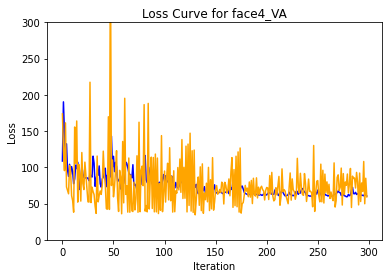

In [ ]:
model_face = create_trainable_Network_Face((1+70)*3)      
train_for_dataset(model_face, "face5_VA_aligned", lr=0.00003, VA = True, feat='face', num_epochs = 300)

204 1
training_slice set shape is torch.Size([6384, 1, 67, 3])
validation_slice set shape is torch.Size([1950, 1, 67, 3])
Epoch: 0, Iteration 0, loss = 439.5964
Epoch: 0, Iteration 5 validation, loss = 450.0819
Epoch: 10, Iteration 0, loss = 104.5801
Epoch: 10, Iteration 5 validation, loss = 105.7924
Epoch: 20, Iteration 0, loss = 99.8490
Epoch: 20, Iteration 5 validation, loss = 64.5951
Epoch: 30, Iteration 0, loss = 76.2270
Epoch: 30, Iteration 5 validation, loss = 86.3401
Epoch: 40, Iteration 0, loss = 165.5998
Epoch: 40, Iteration 5 validation, loss = 50.6725
Epoch: 50, Iteration 0, loss = 87.1508
Epoch: 50, Iteration 5 validation, loss = 52.9680
Epoch: 60, Iteration 0, loss = 59.5053
Epoch: 60, Iteration 5 validation, loss = 70.9171
Epoch: 70, Iteration 0, loss = 122.3158
Epoch: 70, Iteration 5 validation, loss = 116.4023
Epoch: 80, Iteration 0, loss = 107.4077
Epoch: 80, Iteration 5 validation, loss = 107.9661
Epoch: 90, Iteration 0, loss = 84.6846
Epoch: 90, Iteration 5 validati

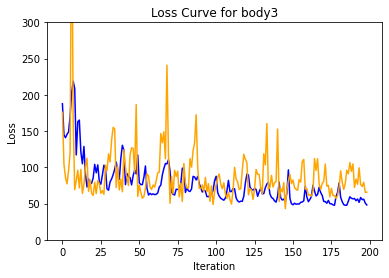

In [ ]:
model_body = create_trainable_Network_Body((1 + 2*21 + 25)*3)      
train_for_dataset(model_body, "body3", feat='pose', lr=0.00005, num_epochs = 200)

### Voice test set score

(56,)
57
no of ratings 56
no of video clips 56
error for svm on test set: 70.20949752067267
weighted error for svm on test set: 47.385735865385016


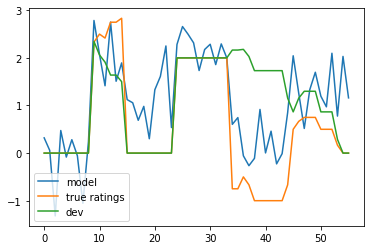

no of ratings 56
no of video clips 56
error for rdmfor on test set: 66.21980266666665
weighted error for rdmfor on test set: 43.11108702861455


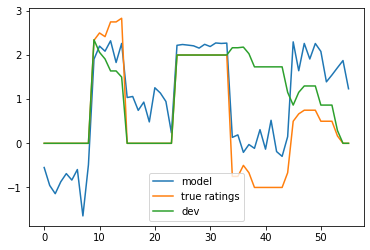

In [ ]:
# audio processing
audios = []
path = f'{content_path}/dataset/aud/test/'

ratings = np.load(f"{content_path}/opinions/audio_ratings_labels_test.npy")
ratings_dev = np.load(f"{content_path}/opinions/audio_ratings_devs_labels_test.npy")

print(ratings.shape)
print(len(os.listdir(path)))
score = 0
score_w = 0

for j, filename in enumerate(os.listdir(path)):
  if(filename[-3:] == "wav"):
    v, l = aT.file_regression(f'{content_path}/dataset/aud/test/{filename}', f"{content_path}/models/voice_svm", "svm")
    # print(v, l, )
    acc = v[0]
    score_w += (ratings[j-1] - acc)**2 *(1/(1+ratings_dev[j-1]))
    score += (ratings[j-1] - acc)**2
    audios.append(acc)

# plt.figure(figsize=(15, 15))
print('no of ratings', len(ratings))
print('no of video clips', len(audios))
plt.plot(range(len(audios)), audios, label = 'model')
plt.plot(range(len(ratings)), ratings, label='true ratings')
plt.plot(range(len(ratings_dev)), ratings_dev, label='dev')

print(f'error for svm on test set: {score}')
print(f'weighted error for svm on test set: {score_w}')
plt.legend()
plt.show()

score = 0
score_w = 0
audios = []

for j, filename in enumerate(os.listdir(path)):
  if(filename[-3:] == "wav"):
    v, l = aT.file_regression(f'{content_path}/dataset/aud/test/{filename}', f"{content_path}/models/voice_rdmforrest", "randomforest")
    # print(v, l, )
    acc = v[0]
    score_w += (ratings[j-1] - acc)**2 *(1/(1+ratings_dev[j-1]))
    score += (ratings[j-1] - acc)**2
    audios.append(acc)

# plt.figure(figsize=(15, 15))
print('no of ratings', len(ratings))
print('no of video clips', len(audios))
plt.plot(range(len(audios)), audios, label = 'model')
plt.plot(range(len(ratings)), ratings, label='true ratings')
plt.plot(range(len(ratings_dev)), ratings_dev, label='dev')

print(f'error for rdmfor on test set: {score}')
print(f'weighted error for rdmfor on test set: {score_w}')

plt.legend()
plt.show()

### Graphs for overall performance


 Test sequence consists of 178.66666666666666 seconds
Score for the current model: 0.5738548890772607


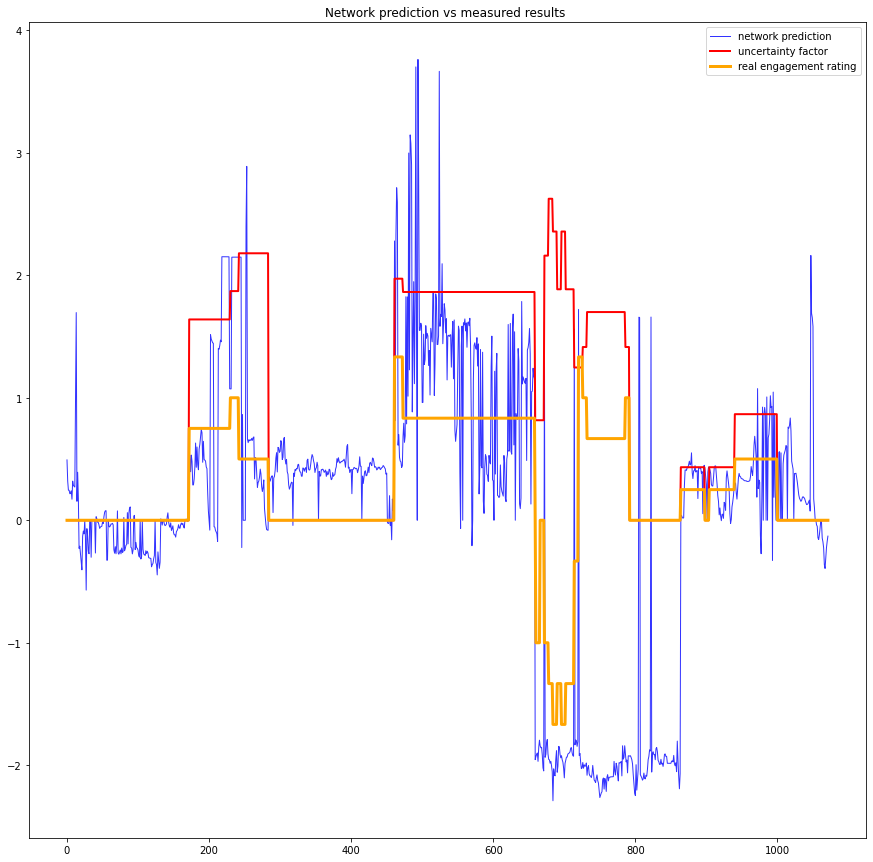

In [ ]:
test_dataset_face = torch.load(f"{content_path}/dataset/faces_videos_stack_test_slice").cpu()
test_dataset_pose = torch.load(f"{content_path}/dataset/poses_videos_stack_test_slice").cpu()

test_genders = torch.load(f"{content_path}/dataset/genders_test_slice")
test_face_ratings = np.load(f"{content_path}/opinions/face_ratings_labels_test_slice.npy")
test_pose_ratings = np.load(f"{content_path}/opinions/pose_ratings_labels_test_slice.npy")
test_overall_ratings = np.load(f"{content_path}/opinions/overall_ratings_labels_test_slice.npy")

test_overall_ratings_dev = np.load(f"{content_path}/opinions/overall_ratings_devs_test_slice.npy")

model_face = torch.load(f"{content_path}/models/face2")
model_pose = torch.load(f"{content_path}/models/body3")

outs=[]
for f in range(test_dataset_face.shape[0]):
  out_face = -5
  out_pose = -5

  model_face.eval()
  if not torch.all(test_dataset_face[f] == 0) and torch.any(test_dataset_face[f] > -99.0):
    with torch.no_grad():
      input = torch.cat((test_genders[f].float(), test_dataset_face[f].float()), 1).flatten(start_dim=1)
      out_face = model_face.forward(input).item()

  model_pose.eval()
  if not torch.all(test_dataset_pose[f] == 0) and torch.any(test_dataset_pose[f] > -99.0):
    with torch.no_grad():
      input = torch.cat((test_genders[f].float(), test_dataset_pose[f].float()), 1).flatten(start_dim=1)
      out_pose = model_pose.forward(input).item()

  if out_face>-5 and out_pose > -5:
    outs.append((2*out_face + out_pose)/3-1)
  elif out_face>-5:
    outs.append(out_face)
  elif out_pose > -5:
    outs.append(out_pose)
  else:
    outs.append(0)  

outs = np.array(outs)
print(f' Test sequence consists of {len(test_overall_ratings)/6} seconds')
# fig, ax = plt.subplots()
plt.figure(figsize=(15, 15))
plt.title(f'Network prediction vs measured results ')

plt.plot(range(len(outs)), outs, color='blue', alpha=0.8, linewidth=1.0, label='network prediction')
plt.plot(range(len(test_overall_ratings_dev)), test_overall_ratings_dev, color='red', linewidth=2.0, label = 'uncertainty factor')
plt.plot(range(len(test_overall_ratings)), test_overall_ratings, color='orange', linewidth=3.0, label= 'real engagement rating')

score = 1.0 - (np.sum(np.abs(np.array(outs) - test_overall_ratings) * (1/(1+test_overall_ratings_dev)))) / len(outs)
print(f"Score for the current model: {score}")

plt.legend()
plt.show()

 Test sequence consists of 178.66666666666666 seconds
Score for the current model: 0.6164551443635471


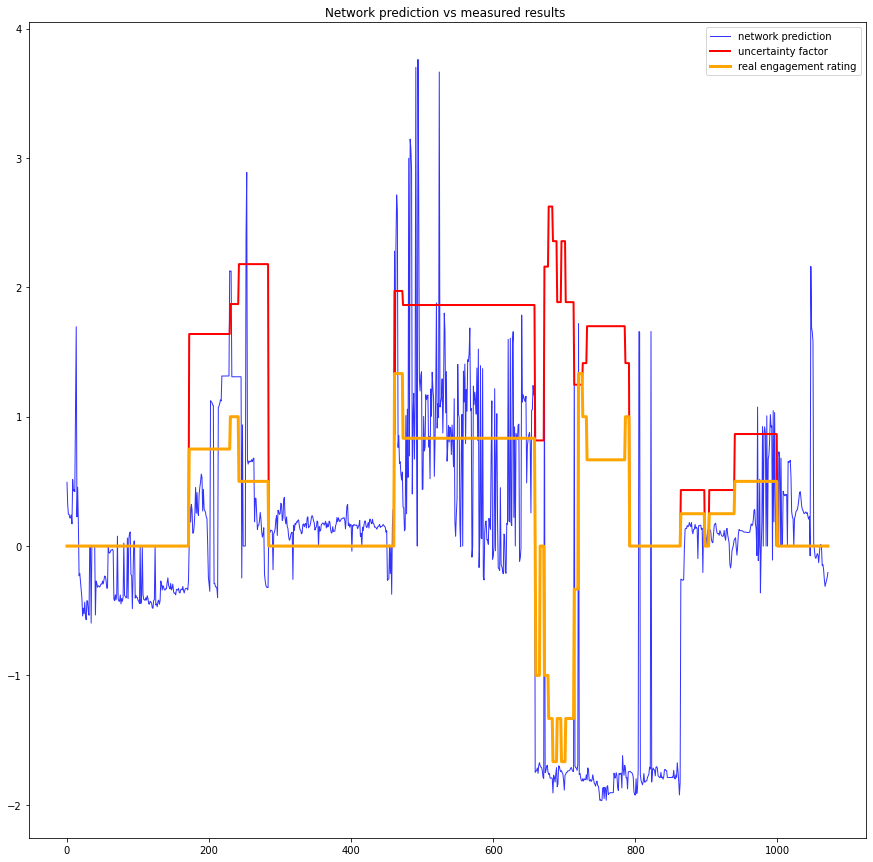

In [ ]:
test_dataset_face = torch.load(f"{content_path}/dataset/faces_videos_stack_test_slice").cpu()
test_dataset_pose = torch.load(f"{content_path}/dataset/poses_videos_stack_test_slice").cpu()

test_genders = torch.load(f"{content_path}/dataset/genders_test_slice")
test_face_ratings = np.load(f"{content_path}/opinions/face_ratings_labels_test_slice.npy")
test_pose_ratings = np.load(f"{content_path}/opinions/pose_ratings_labels_test_slice.npy")
test_overall_ratings = np.load(f"{content_path}/opinions/overall_ratings_labels_test_slice.npy")

test_overall_ratings_dev = np.load(f"{content_path}/opinions/overall_ratings_devs_test_slice.npy")

model_face = torch.load(f"{content_path}/models/face4_VA")
model_pose = torch.load(f"{content_path}/models/body3")

outs=[]
for f in range(test_dataset_face.shape[0]):
  out_face = -5
  out_pose = -5

  model_face.eval()
  if not torch.all(test_dataset_face[f] == 0) and torch.all(test_dataset_face[f] > -99.0):
    with torch.no_grad():
      input = torch.cat((test_genders[f].float(), test_dataset_face[f].float()), 1).flatten(start_dim=1)
      out_face = model_face.forward(input).item()

  model_pose.eval()
  if not torch.all(test_dataset_pose[f] == 0) and torch.all(test_dataset_pose[f] > -99.0):
    with torch.no_grad():
      input = torch.cat((test_genders[f].float(), test_dataset_pose[f].float()), 1).flatten(start_dim=1)
      out_pose = model_pose.forward(input).item()

  if out_face>-5 and out_pose > -5:
    outs.append((2*out_face + out_pose)/3-1)
  elif out_face>-5:
    outs.append(out_face)
  elif out_pose > -5:
    outs.append(out_pose)
  else:
    outs.append(0)  

outs = np.array(outs)
print(f' Test sequence consists of {len(test_overall_ratings)/6} seconds')
# fig, ax = plt.subplots()
plt.figure(figsize=(15, 15))
plt.title(f'Network prediction vs measured results ')

plt.plot(range(len(outs)), outs, color='blue', alpha=0.8, linewidth=1.0, label='network prediction')
plt.plot(range(len(test_overall_ratings_dev)), test_overall_ratings_dev, color='red', linewidth=2.0, label = 'uncertainty factor')
plt.plot(range(len(test_overall_ratings)), test_overall_ratings, color='orange', linewidth=3.0, label= 'real engagement rating')

score = 1.0 - (np.sum(np.abs(np.array(outs) - test_overall_ratings) * (1/(1+test_overall_ratings_dev)))) / len(outs)
print(f"Score for the current model: {score}")

plt.legend()
plt.show()

In [ ]:
test_dataset_face = torch.load(f"{content_path}/dataset/faces_videos_stack_test_slice").cpu()
test_dataset_pose = torch.load(f"{content_path}/dataset/poses_videos_stack_test_slice").cpu()

test_genders = torch.load(f"{content_path}/dataset/genders_test_slice")
test_face_ratings = np.load(f"{content_path}/opinions/face_ratings_labels_test_slice.npy")
test_pose_ratings = np.load(f"{content_path}/opinions/pose_ratings_labels_test_slice.npy")
test_overall_ratings = np.load(f"{content_path}/opinions/overall_ratings_labels_test_slice.npy")

test_overall_ratings_dev = np.load(f"{content_path}/opinions/overall_ratings_devs_test_slice.npy")

model_face = torch.load(f"{content_path}/models/face4_VA")
model_pose = torch.load(f"{content_path}/models/body3")
# model_voice = torch.load(f"{content_path}/models/voice1")

# audio processing
audios = []
path = f'{content_path}/dataset/aud/test/'

for j, filename in enumerate(os.listdir(path)):
  if(filename[-3:] == "wav"):
    v, l = aT.file_regression(f'{content_path}/dataset/aud/test/{filename}', f"{content_path}/models/voice_rdmforrest", "randomforest")
    # print(v, l, )
    audios.append(v[0])

print('no of video clips', len(audios))

audio_models = np.repeat(audios, 3*6) 
pad = np.full((test_dataset_face.shape[0] - len(audio_models),), 0.0)
audio_models = np.concatenate([pad, audio_models])

outs=[]
for f in range(test_dataset_face.shape[0]):
  out_face = -5
  out_pose = -5

  model_face.eval()
  if not torch.all(test_dataset_face[f] == 0) and torch.all(test_dataset_face[f] > -99.0):
    with torch.no_grad():
      input = torch.cat((test_genders[f].float(), test_dataset_face[f].float()), 1).flatten(start_dim=1)
      out_face = model_face.forward(input).item()

  model_pose.eval()
  if not torch.all(test_dataset_pose[f] == 0) and torch.all(test_dataset_pose[f] > -99.0):
    with torch.no_grad():
      input = torch.cat((test_genders[f].float(), test_dataset_pose[f].float()), 1).flatten(start_dim=1)
      out_pose = model_pose.forward(input).item()

  if out_face>-5 and out_pose > -5:
    # this formula obtained 0.71
    outs.append((2*out_face + out_pose + audio_models[f])/5 - 0.5 )

    # this obtains 0.65
    # outs.append((2*out_face + out_pose + audio_models[f])/4 - 1)
  elif out_face>-5:
    outs.append((2*out_face+audio_models[f])/4)
  elif out_pose > -5:
    outs.append((out_pose + audio_models[f])/4)
  else:
    outs.append(0)  

outs = np.array(outs)
print(f' Test sequence consists of {len(test_overall_ratings)/6} seconds')

score = 1.0 - (np.sum(np.abs(np.array(outs) - test_overall_ratings) * (1/(1+test_overall_ratings_dev)))) / len(outs)
print(f"Score for the current model: {score}")


plt.figure(figsize=(15, 15))
plt.title(f'Network prediction vs measured results ')

plt.plot(range(len(outs)), outs, color='blue', alpha=0.8, linewidth=1.0, label='network prediction')
plt.plot(range(len(test_overall_ratings_dev)), test_overall_ratings_dev, color='red', linewidth=2.0, label = 'uncertainty factor')
plt.plot(range(len(test_overall_ratings)), test_overall_ratings, color='orange', linewidth=3.0, label= 'real engagement rating')

plt.legend()
plt.show()

no of video clips 116
116
torch.Size([1072, 1, 70, 3])
 Test sequence consists of 178.66666666666666 seconds
Score for the current model: 0.7172124795135073
Score for the current model after smoothening: 0.7443733880701742
CCC for the current model after smoothening: 0.5261592918129291


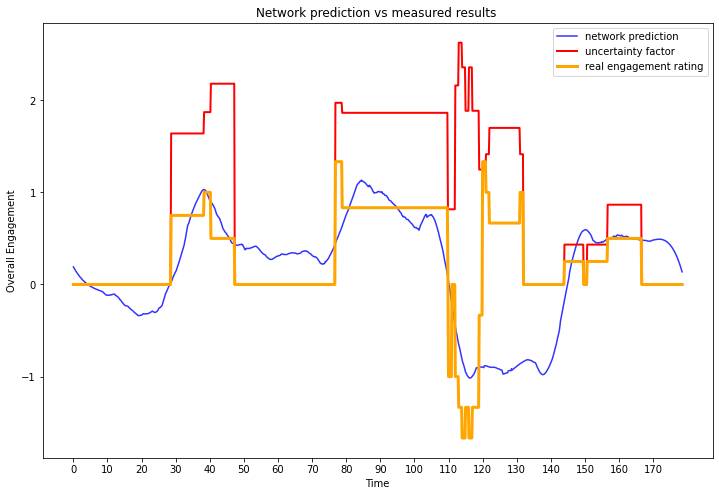

In [ ]:
# import matplotlib.pyplot as plt
# from importlib import reload
# plt = reload(plt)

test_dataset_face = torch.load(f"{content_path}/dataset/faces_videos_stack_test_slice").cpu()
test_dataset_pose = torch.load(f"{content_path}/dataset/poses_videos_stack_test_slice").cpu()

test_genders = torch.load(f"{content_path}/dataset/genders_test_slice")
test_face_ratings = np.load(f"{content_path}/opinions/face_ratings_labels_test_slice.npy")
test_pose_ratings = np.load(f"{content_path}/opinions/pose_ratings_labels_test_slice.npy")
test_overall_ratings = np.load(f"{content_path}/opinions/overall_ratings_labels_test_slice.npy")

test_overall_ratings_dev = np.load(f"{content_path}/opinions/overall_ratings_devs_test_slice.npy")

model_face = torch.load(f"{content_path}/models/face4_VA")
model_pose = torch.load(f"{content_path}/models/body3")
# model_voice = torch.load(f"{content_path}/models/voice1")

# audio processing
audios = []
path = f'{content_path}/dataset/aud/test/'

for j, filename in enumerate(os.listdir(path)):
  if(filename[-3:] == "wav"):
    v, l = aT.file_regression(f'{path}/{filename}', f"{content_path}/models/voice_rdmforrest", "randomforest")
    # print(v, l, )
    audios.append(v[0])

print('no of video clips', len(audios))

audio_models = np.repeat(audios, 3*3)
print(len(audios))
print(test_dataset_face.shape) 
pad = np.full((test_dataset_face.shape[0] - len(audio_models),), 0.0)
audio_models = np.concatenate([pad, audio_models])

outs=[]
for f in range(test_dataset_face.shape[0]):
  out_face = -5
  out_pose = -5

  model_face.eval()
  if not torch.all(test_dataset_face[f] == 0) and torch.all(test_dataset_face[f] > -99.0):
    with torch.no_grad():
      input = torch.cat((test_genders[f].float(), test_dataset_face[f].float()), 1).flatten(start_dim=1)
      out_face = model_face.forward(input).item()

  model_pose.eval()
  if not torch.all(test_dataset_pose[f] == 0) and torch.all(test_dataset_pose[f] > -99.0):
    with torch.no_grad():
      input = torch.cat((test_genders[f].float(), test_dataset_pose[f].float()), 1).flatten(start_dim=1)
      out_pose = model_pose.forward(input).item()

  if out_face>-5 and out_pose > -5:
    # this formula obtained 0.71
    outs.append((2*out_face + out_pose + audio_models[f])/5 - 0.5 )

    # this obtains 0.65
    # outs.append((2*out_face + out_pose + audio_models[f])/4 - 1)
  elif out_face>-5:
    outs.append((2*out_face+audio_models[f])/4)
  elif out_pose > -5:
    outs.append((out_pose + audio_models[f])/4)
  else:
    outs.append(0)  

outs = np.array(outs)
print(f' Test sequence consists of {len(test_overall_ratings)/6} seconds')

score = 1.0 - (np.sum(np.abs(np.array(outs) - test_overall_ratings) * (1/(1+test_overall_ratings_dev)))) / len(outs)
print(f"Score for the current model: {score}")

score = 1.0 - (np.sum(np.abs(np.array(p) - test_overall_ratings) * (1/(1+test_overall_ratings_dev)))) / len(p)
print(f"Score for the current model after smoothening: {score}")

ccc = ccc_loss(torch.tensor(p), torch.tensor(test_overall_ratings))
print(f"CCC for the current model after smoothening: {ccc}")

plt.figure(figsize=(12, 8))
plt.title(f'Network prediction vs measured results ')


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
    
seq=20
p = outs[:-12].reshape(len(outs)//seq,seq)
p = np.mean(p, axis=1)
p = np.repeat(p, seq)
# p = np.cumsum(p) / [1+i for i in range(len(p))]
from scipy.signal import savgol_filter

p = savgol_filter(outs, 101, 3)

plt.plot(range(len(p)), p, color='blue', alpha=0.8, linewidth=1.5, label='Network Prediction')
# plt.plot(range(len(outs)), np.cumsum(outs)/[1+i for i in range(len(outs))], color='blue', alpha=0.8, linewidth=1.0, label='network prediction')
# plt.plot(range(len(test_overall_ratings_dev)), test_overall_ratings_dev, color='red', linewidth=2.0, label = 'Uncertainty Factor')
plt.plot(range(len(test_overall_ratings)), test_overall_ratings, color='orange', linewidth=3.0, label= 'Real Engagement Ratings')
plt.fill_between(range(len(test_overall_ratings_dev)), test_overall_ratings+test_overall_ratings_dev/2, test_overall_ratings-test_overall_ratings_dev/2, facecolor='r', alpha=0.2)
  
# plt.text(2, 3, f'Score obtained for overall engagement: {score}',
#      horizontalalignment='center',
#      verticalalignment='center')

plt.xlabel('Time')
plt.ylabel('Overall Engagement')
x = list(range(10))
plt.xticks(range(0, len(p), 60), [i//6 for i in range(0, len(p), 60)])

# plt.xticks(list(range(len(outs))), range(len(outs)//6)) 
plt.legend()
plt.show()

no of video clips 116
116
torch.Size([1072, 1, 70, 3])
[-0.5 -0.5 -0.5 ...  0.   0.   0. ]
 Test sequence consists of 178.66666666666666 seconds
Score for the current model: 0.22567490819302694
Score for the current model after smoothening: 0.3018555112019202
CCC for the current model after smoothening: 0.8945564753826497


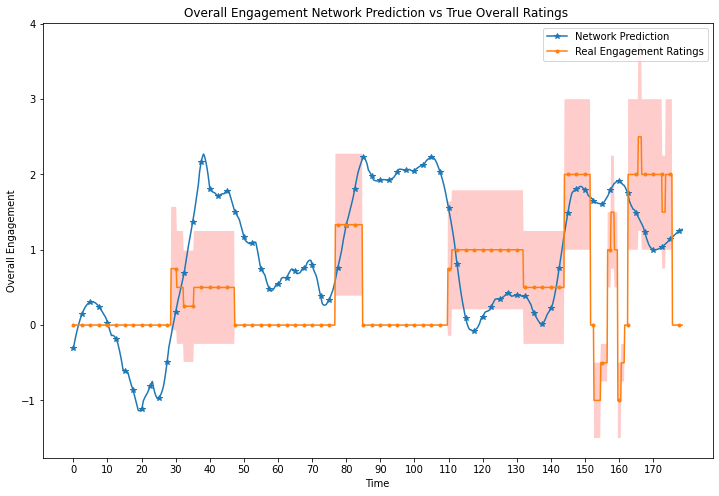

torch.Size([1])
torch.Size([0])
[3, 4, 4, 4, 5, 4, 4, 4]
tensor([-0.3154,  0.8592,  0.8713,  1.2158,  1.9565,  0.2700,  1.1167,  1.3697],
       dtype=torch.float64)

torch.Size([8])
torch.Size([8])


8


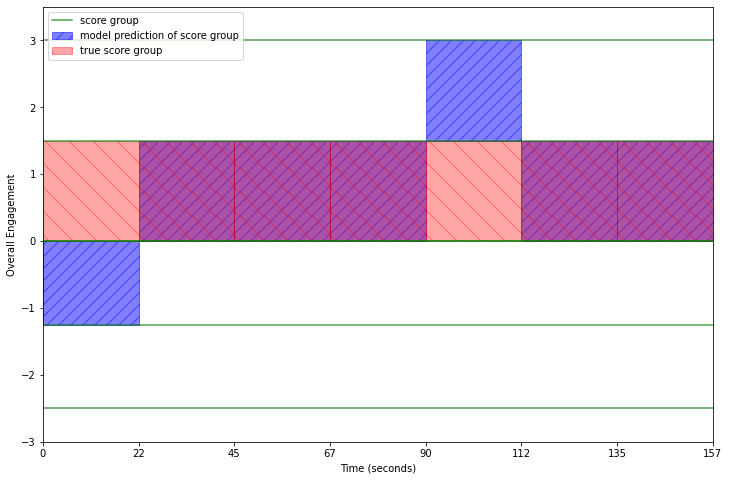

In [ ]:
# import matplotlib.pyplot as plt
# from importlib import reload
# plt = reload(plt)
execfile(f'{content_path}/API/helpers.py')

test_dataset_face = torch.load(f"{content_path}/dataset/faces_videos_stack_test_slice").cpu()
test_dataset_pose = torch.load(f"{content_path}/dataset/poses_videos_stack_test_slice").cpu()

test_genders = torch.load(f"{content_path}/dataset/genders_test_slice")
test_face_ratings = np.load(f"{content_path}/opinions/face_ratings_labels_test_unfiltered.npy")
test_pose_ratings_dev = np.load(f"{content_path}/opinions/pose_ratings_devs_test_unfiltered.npy")

test_pose_ratings = np.load(f"{content_path}/opinions/pose_ratings_labels_test_unfiltered.npy")
test_overall_ratings = np.load(f"{content_path}/opinions/overall_ratings_labels_test_slice.npy")

test_overall_ratings_dev = np.load(f"{content_path}/opinions/overall_ratings_devs_test_slice.npy")

model_face = torch.load(f"{content_path}/models/face4_VA")
model_pose = torch.load(f"{content_path}/models/body3")
# model_voice = torch.load(f"{content_path}/models/voice1")

# audio processing
audios = []
path = f'{content_path}/dataset/aud/test/'

for j, filename in enumerate(os.listdir(path)):
  if(filename[-3:] == "wav"):
    v, l = aT.file_regression(f'{path}/{filename}', f"{content_path}/models/voice_rdmforrest", "randomforest")
    # print(v, l, )
    audios.append(v[0])

print('no of video clips', len(audios))

audio_models = np.repeat(audios, 3*3)
print(len(audios))
print(test_dataset_face.shape) 
pad = np.full((test_dataset_face.shape[0] - len(audio_models),), 0.0)
audio_models = np.concatenate([pad, audio_models])

outs=[]
for f in range(test_dataset_face.shape[0]):
  out_face = 0
  out_pose = 0

  # model_face.eval()
  # if not torch.all(test_dataset_face[f] == 0) and torch.all(test_dataset_face[f] > -99.0):
  #   with torch.no_grad():
  #     input = torch.cat((test_genders[f].float(), test_dataset_face[f].float()), 1).flatten(start_dim=1)
  #     out_face = model_face.forward(input).item()

  # model_pose.eval()
  # if not torch.all(test_dataset_pose[f] == 0) and torch.all(test_dataset_pose[f] > -99.0):
  #   with torch.no_grad():
  #     input = torch.cat((test_genders[f].float(), test_dataset_pose[f].float()), 1).flatten(start_dim=1)
  #     out_pose = model_pose.forward(input).item()

  # if out_face>-5 and out_pose > -5:
  #   # this formula obtained 0.71
  #   outs.append((2*out_face + out_pose + audio_models[f])/5 - 0.5 )

  #   # this obtains 0.65
  #   # outs.append((2*out_face + out_pose + audio_models[f])/4 - 1)
  # elif out_face>-5:
  #   outs.append((2*out_face+audio_models[f])/4)
  # elif out_pose > -5:
  #   outs.append((out_pose + audio_models[f])/4)
  # else:
  #   outs.append(0)  
  # outs.append(out_pose)

outs = audio_models
plt.figure(figsize=(12, 8))
plt.title(f'Overall Engagement Network Prediction vs True Overall Ratings ')


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

outs = np.array(outs)    
seq=20

p = outs[:-12].reshape(len(outs)//seq,seq)
p = np.mean(p, axis=1)
p = np.repeat(p, seq)
# p = np.cumsum(p) / [1+i for i in range(len(p))]
from scipy.signal import savgol_filter

p = savgol_filter(outs, 101, 3)

test_overall_ratings=test_pose_ratings

print(test_face_ratings)
test_overall_ratings_dev=test_pose_ratings_dev


plt.plot(range(len(p)), p, label='Network Prediction', marker = '*',markevery=15)
# plt.plot(range(len(outs)), np.cumsum(outs)/[1+i for i in range(len(outs))], color='blue', alpha=0.8, linewidth=1.0, label='network prediction')
# plt.plot(range(len(test_overall_ratings_dev)), test_overall_ratings_dev, color='red', linewidth=2.0, label = 'Uncertainty Factor')
plt.plot(range(len(test_overall_ratings)), test_overall_ratings, label= 'Real Engagement Ratings', marker = '.',markevery=15)
plt.fill_between(range(len(test_overall_ratings_dev)), test_overall_ratings+test_overall_ratings_dev/2, test_overall_ratings-test_overall_ratings_dev/2, facecolor='r', alpha=0.2)


#############################
# plt.plot(range(len(test_face_ratings)), test_face_ratings, label= 'Real Engagement Ratings', marker = '.',markevery=15)
# plt.fill_between(range(len(test_face_ratings_dev)), test_face_ratings+test_face_ratings_dev/2,
#                  test_face_ratings-test_face_ratings_dev/2, facecolor='r', alpha=0.2)

##########################
print(f' Test sequence consists of {len(test_overall_ratings)/6} seconds')

score = 1.0 - (np.sum(np.abs(np.array(outs) - test_overall_ratings) * (1/(1+test_overall_ratings_dev)))) / len(outs)
print(f"Score for the current model: {score}")

score = 1.0 - (np.sum(np.abs(np.array(p) - test_overall_ratings) * (1/(1+test_overall_ratings_dev)))) / len(p)
print(f"Score for the current model after smoothening: {score}")

ccc = ccc_loss(torch.tensor(p), torch.tensor(test_overall_ratings))
print(f"CCC for the current model after smoothening: {ccc}")

# plt.text(2, 3, f'Score obtained for overall engagement: {score}',
#      horizontalalignment='center',
#      verticalalignment='center')

plt.xlabel('Time')
plt.ylabel('Overall Engagement')
x = list(range(10))
plt.xticks(range(0, len(p), 60), [i//6 for i in range(0, len(p), 60)])

# plt.xticks(list(range(len(outs))), range(len(outs)//6)) 
plt.legend()
plt.show()

outs = torch.tensor(outs)
test_overall_ratings = torch.tensor(test_overall_ratings)
test_ratings = test_overall_ratings

torch.save(outs, "face_regression_outputs")

seq = 9
outs_p = outs[: (len(outs)//seq) *seq]
outs_short = outs[(len(outs)//seq) *seq:]
print(outs_short.shape)
outs = outs_p.reshape((len(outs_p)//seq, seq))
outs = outs.mean(axis= 1)

if outs_short.shape[0] > 0:
  outs = torch.cat((outs, outs_short.mean().unsqueeze(0)), 0)

test_ratings_p = test_ratings[: (len(test_ratings)//seq) *seq]
test_ratings_short = test_ratings[(len(test_ratings)//seq) *seq:]
test_ratings = test_ratings_p.reshape((len(test_ratings_p)//seq, seq))
test_ratings = test_ratings.mean(axis=1)

eval_fusion_score_group(outs, test_ratings)

no of video clips 0
0
torch.Size([1072, 1, 70, 3])
[-0.5 -0.5 -0.5 ...  0.   0.   0. ]
 Test sequence consists of 178.66666666666666 seconds
Score for the current model: 0.4293342284713487
Score for the current model after smoothening: 0.46865056570460095
CCC for the current model after smoothening: 0.6774522911098936


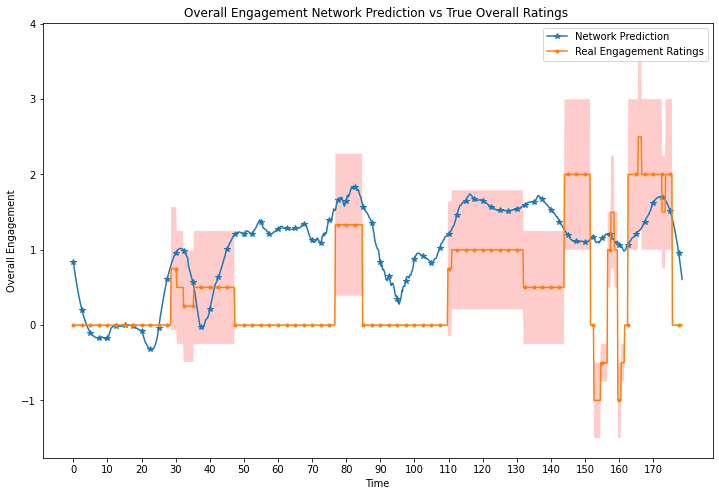

torch.Size([1])
torch.Size([0])
[4, 4, 4, 4, 4, 5, 4, 4]
tensor([0.0082, 0.4711, 1.2337, 1.4292, 0.8222, 1.5870, 1.2896, 1.2870],
       dtype=torch.float64)

torch.Size([8])
torch.Size([8])


8


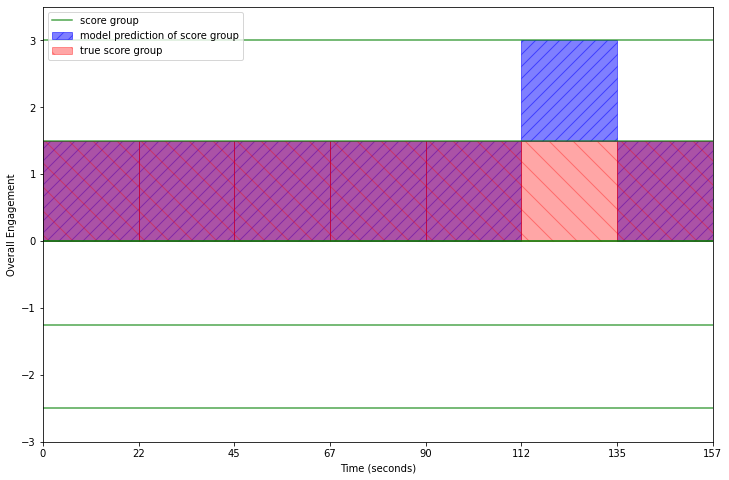

In [ ]:
# import matplotlib.pyplot as plt
# from importlib import reload
# plt = reload(plt)
execfile(f'{content_path}/API/helpers.py')

test_dataset_face = torch.load(f"{content_path}/dataset/faces_videos_stack_test_slice").cpu()
test_dataset_pose = torch.load(f"{content_path}/dataset/poses_videos_stack_test_slice").cpu()

test_genders = torch.load(f"{content_path}/dataset/genders_test_slice")
test_face_ratings = np.load(f"{content_path}/opinions/face_ratings_labels_test_unfiltered.npy")
test_pose_ratings_dev = np.load(f"{content_path}/opinions/pose_ratings_devs_test_unfiltered.npy")

test_pose_ratings = np.load(f"{content_path}/opinions/pose_ratings_labels_test_unfiltered.npy")
test_overall_ratings = np.load(f"{content_path}/opinions/overall_ratings_labels_test_slice.npy")

test_overall_ratings_dev = np.load(f"{content_path}/opinions/overall_ratings_devs_test_slice.npy")

model_face = torch.load(f"{content_path}/models/face4_VA")
model_pose = torch.load(f"{content_path}/models/body3")
# model_voice = torch.load(f"{content_path}/models/voice1")

# audio processing
audios = []
path = f'{content_path}/dataset/aud/test/'

# for j, filename in enumerate(os.listdir(path)):
#   if(filename[-3:] == "wav"):
#     v, l = aT.file_regression(f'{path}/{filename}', f"{content_path}/models/voice_rdmforrest", "randomforest")
#     # print(v, l, )
#     audios.append(v[0])

print('no of video clips', len(audios))

audio_models = np.repeat(audios, 3*3)
print(len(audios))
print(test_dataset_face.shape) 
pad = np.full((test_dataset_face.shape[0] - len(audio_models),), 0.0)
audio_models = np.concatenate([pad, audio_models])

outs=[]
for f in range(test_dataset_face.shape[0]):
  out_face = 0
  out_pose = 0

  # model_face.eval()
  # if not torch.all(test_dataset_face[f] == 0) and torch.all(test_dataset_face[f] > -99.0):
  #   with torch.no_grad():
  #     input = torch.cat((test_genders[f].float(), test_dataset_face[f].float()), 1).flatten(start_dim=1)
  #     out_face = model_face.forward(input).item()

  model_pose.eval()
  if not torch.all(test_dataset_pose[f] == 0) and torch.all(test_dataset_pose[f] > -99.0):
    with torch.no_grad():
      input = torch.cat((test_genders[f].float(), test_dataset_pose[f].float()), 1).flatten(start_dim=1)
      out_pose = model_pose.forward(input).item()

  # if out_face>-5 and out_pose > -5:
  #   # this formula obtained 0.71
  #   outs.append((2*out_face + out_pose + audio_models[f])/5 - 0.5 )

  #   # this obtains 0.65
  #   # outs.append((2*out_face + out_pose + audio_models[f])/4 - 1)
  # elif out_face>-5:
  #   outs.append((2*out_face+audio_models[f])/4)
  # elif out_pose > -5:
  #   outs.append((out_pose + audio_models[f])/4)
  # else:
  #   outs.append(0)  
  outs.append(out_pose)

plt.figure(figsize=(12, 8))
plt.title(f'Overall Engagement Network Prediction vs True Overall Ratings ')


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

outs = np.array(outs)    
seq=20

p = outs[:-12].reshape(len(outs)//seq,seq)
p = np.mean(p, axis=1)
p = np.repeat(p, seq)
# p = np.cumsum(p) / [1+i for i in range(len(p))]
from scipy.signal import savgol_filter

p = savgol_filter(outs, 101, 3)

test_overall_ratings=test_pose_ratings

print(test_face_ratings)
test_overall_ratings_dev=test_pose_ratings_dev


plt.plot(range(len(p)), p, label='Network Prediction', marker = '*',markevery=15)
# plt.plot(range(len(outs)), np.cumsum(outs)/[1+i for i in range(len(outs))], color='blue', alpha=0.8, linewidth=1.0, label='network prediction')
# plt.plot(range(len(test_overall_ratings_dev)), test_overall_ratings_dev, color='red', linewidth=2.0, label = 'Uncertainty Factor')
plt.plot(range(len(test_overall_ratings)), test_overall_ratings, label= 'Real Engagement Ratings', marker = '.',markevery=15)
plt.fill_between(range(len(test_overall_ratings_dev)), test_overall_ratings+test_overall_ratings_dev/2, test_overall_ratings-test_overall_ratings_dev/2, facecolor='r', alpha=0.2)


#############################
# plt.plot(range(len(test_face_ratings)), test_face_ratings, label= 'Real Engagement Ratings', marker = '.',markevery=15)
# plt.fill_between(range(len(test_face_ratings_dev)), test_face_ratings+test_face_ratings_dev/2,
#                  test_face_ratings-test_face_ratings_dev/2, facecolor='r', alpha=0.2)

##########################
print(f' Test sequence consists of {len(test_overall_ratings)/6} seconds')

score = 1.0 - (np.sum(np.abs(np.array(outs) - test_overall_ratings) * (1/(1+test_overall_ratings_dev)))) / len(outs)
print(f"Score for the current model: {score}")

score = 1.0 - (np.sum(np.abs(np.array(p) - test_overall_ratings) * (1/(1+test_overall_ratings_dev)))) / len(p)
print(f"Score for the current model after smoothening: {score}")

ccc = ccc_loss(torch.tensor(p), torch.tensor(test_overall_ratings))
print(f"CCC for the current model after smoothening: {ccc}")

# plt.text(2, 3, f'Score obtained for overall engagement: {score}',
#      horizontalalignment='center',
#      verticalalignment='center')

plt.xlabel('Time')
plt.ylabel('Overall Engagement')
x = list(range(10))
plt.xticks(range(0, len(p), 60), [i//6 for i in range(0, len(p), 60)])

# plt.xticks(list(range(len(outs))), range(len(outs)//6)) 
plt.legend()
plt.show()

outs = torch.tensor(outs)
test_overall_ratings = torch.tensor(test_overall_ratings)
test_ratings = test_overall_ratings

torch.save(outs, "face_regression_outputs")

seq = 9
outs_p = outs[: (len(outs)//seq) *seq]
outs_short = outs[(len(outs)//seq) *seq:]
print(outs_short.shape)
outs = outs_p.reshape((len(outs_p)//seq, seq))
outs = outs.mean(axis= 1)

if outs_short.shape[0] > 0:
  outs = torch.cat((outs, outs_short.mean().unsqueeze(0)), 0)

test_ratings_p = test_ratings[: (len(test_ratings)//seq) *seq]
test_ratings_short = test_ratings[(len(test_ratings)//seq) *seq:]
test_ratings = test_ratings_p.reshape((len(test_ratings_p)//seq, seq))
test_ratings = test_ratings.mean(axis=1)

eval_fusion_score_group(outs, test_ratings)

no of video clips 0
0
torch.Size([1072, 1, 70, 3])
[-0.5 -0.5 -0.5 ...  0.   0.   0. ]
 Test sequence consists of 178.66666666666666 seconds
Score for the current model: 0.23271647211716218
Score for the current model after smoothening: 0.2554634197519918
CCC for the current model after smoothening: 0.6157719846564368


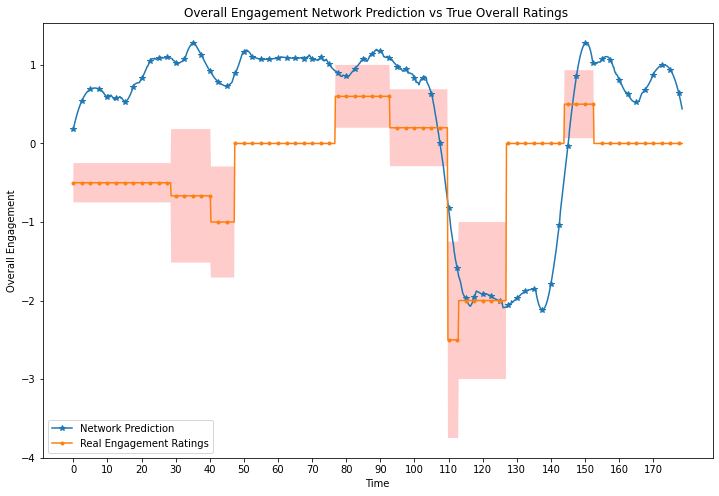

torch.Size([1])
torch.Size([0])
[4, 4, 4, 4, 4, 2, 3, 4]
tensor([ 0.6364,  1.0096,  1.0858,  1.0255,  0.4815, -1.9353, -0.1485,  0.7805],
       dtype=torch.float64)

torch.Size([8])
torch.Size([8])


8


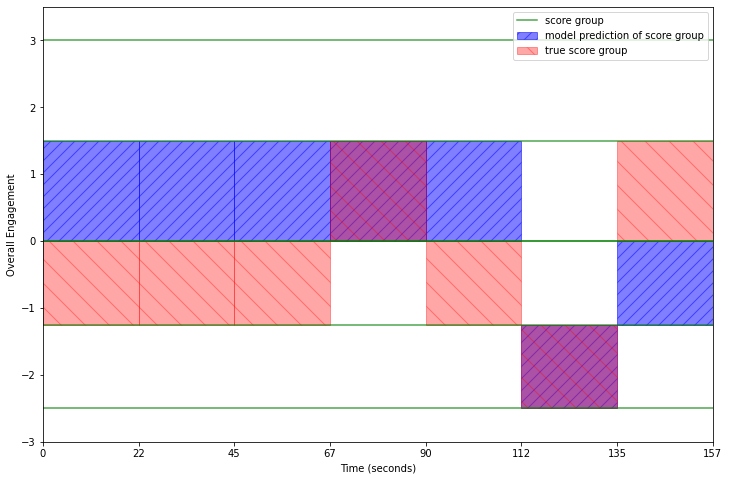

In [ ]:
# import matplotlib.pyplot as plt
# from importlib import reload
# plt = reload(plt)
execfile(f'{content_path}/API/helpers.py')

test_dataset_face = torch.load(f"{content_path}/dataset/faces_videos_stack_test_slice").cpu()
test_dataset_pose = torch.load(f"{content_path}/dataset/poses_videos_stack_test_slice").cpu()

test_genders = torch.load(f"{content_path}/dataset/genders_test_slice")
test_face_ratings = np.load(f"{content_path}/opinions/face_ratings_labels_test_unfiltered.npy")
test_face_ratings_dev = np.load(f"{content_path}/opinions/face_ratings_devs_test_unfiltered.npy")

test_pose_ratings = np.load(f"{content_path}/opinions/pose_ratings_labels_test_slice.npy")
test_overall_ratings = np.load(f"{content_path}/opinions/overall_ratings_labels_test_slice.npy")

test_overall_ratings_dev = np.load(f"{content_path}/opinions/overall_ratings_devs_test_slice.npy")

model_face = torch.load(f"{content_path}/models/face4_VA")
model_pose = torch.load(f"{content_path}/models/body3")
# model_voice = torch.load(f"{content_path}/models/voice1")

# audio processing
audios = []
path = f'{content_path}/dataset/aud/test/'

# for j, filename in enumerate(os.listdir(path)):
#   if(filename[-3:] == "wav"):
#     v, l = aT.file_regression(f'{path}/{filename}', f"{content_path}/models/voice_rdmforrest", "randomforest")
#     # print(v, l, )
#     audios.append(v[0])

print('no of video clips', len(audios))

audio_models = np.repeat(audios, 3*3)
print(len(audios))
print(test_dataset_face.shape) 
pad = np.full((test_dataset_face.shape[0] - len(audio_models),), 0.0)
audio_models = np.concatenate([pad, audio_models])

outs=[]
for f in range(test_dataset_face.shape[0]):
  out_face = 0
  out_pose = -5

  model_face.eval()
  if not torch.all(test_dataset_face[f] == 0) and torch.all(test_dataset_face[f] > -99.0):
    with torch.no_grad():
      input = torch.cat((test_genders[f].float(), test_dataset_face[f].float()), 1).flatten(start_dim=1)
      out_face = model_face.forward(input).item()

  # model_pose.eval()
  # if not torch.all(test_dataset_pose[f] == 0) and torch.all(test_dataset_pose[f] > -99.0):
  #   with torch.no_grad():
  #     input = torch.cat((test_genders[f].float(), test_dataset_pose[f].float()), 1).flatten(start_dim=1)
  #     out_pose = model_pose.forward(input).item()

  # if out_face>-5 and out_pose > -5:
  #   # this formula obtained 0.71
  #   outs.append((2*out_face + out_pose + audio_models[f])/5 - 0.5 )

  #   # this obtains 0.65
  #   # outs.append((2*out_face + out_pose + audio_models[f])/4 - 1)
  # elif out_face>-5:
  #   outs.append((2*out_face+audio_models[f])/4)
  # elif out_pose > -5:
  #   outs.append((out_pose + audio_models[f])/4)
  # else:
  #   outs.append(0)  
  outs.append(out_face)

plt.figure(figsize=(12, 8))
plt.title(f'Overall Engagement Network Prediction vs True Overall Ratings ')


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

outs = np.array(outs)    
seq=20
p = outs[:-12].reshape(len(outs)//seq,seq)
p = np.mean(p, axis=1)
p = np.repeat(p, seq)
# p = np.cumsum(p) / [1+i for i in range(len(p))]
from scipy.signal import savgol_filter

p = savgol_filter(outs, 101, 3)

test_overall_ratings=test_face_ratings

print(test_face_ratings)
test_overall_ratings_dev=test_face_ratings_dev


plt.plot(range(len(p)), p, label='Network Prediction', marker = '*',markevery=15)
# plt.plot(range(len(outs)), np.cumsum(outs)/[1+i for i in range(len(outs))], color='blue', alpha=0.8, linewidth=1.0, label='network prediction')
# plt.plot(range(len(test_overall_ratings_dev)), test_overall_ratings_dev, color='red', linewidth=2.0, label = 'Uncertainty Factor')
plt.plot(range(len(test_overall_ratings)), test_overall_ratings, label= 'Real Engagement Ratings', marker = '.',markevery=15)
plt.fill_between(range(len(test_overall_ratings_dev)), test_overall_ratings+test_overall_ratings_dev/2, test_overall_ratings-test_overall_ratings_dev/2, facecolor='r', alpha=0.2)


#############################
# plt.plot(range(len(test_face_ratings)), test_face_ratings, label= 'Real Engagement Ratings', marker = '.',markevery=15)
# plt.fill_between(range(len(test_face_ratings_dev)), test_face_ratings+test_face_ratings_dev/2,
#                  test_face_ratings-test_face_ratings_dev/2, facecolor='r', alpha=0.2)

##########################
print(f' Test sequence consists of {len(test_overall_ratings)/6} seconds')

score = 1.0 - (np.sum(np.abs(np.array(outs) - test_overall_ratings) * (1/(1+test_overall_ratings_dev)))) / len(outs)
print(f"Score for the current model: {score}")

score = 1.0 - (np.sum(np.abs(np.array(p) - test_overall_ratings) * (1/(1+test_overall_ratings_dev)))) / len(p)
print(f"Score for the current model after smoothening: {score}")

ccc = ccc_loss(torch.tensor(p), torch.tensor(test_overall_ratings))
print(f"CCC for the current model after smoothening: {ccc}")

# plt.text(2, 3, f'Score obtained for overall engagement: {score}',
#      horizontalalignment='center',
#      verticalalignment='center')

plt.xlabel('Time')
plt.ylabel('Overall Engagement')
x = list(range(10))
plt.xticks(range(0, len(p), 60), [i//6 for i in range(0, len(p), 60)])

# plt.xticks(list(range(len(outs))), range(len(outs)//6)) 
plt.legend()
plt.show()

outs = torch.tensor(outs)
test_overall_ratings = torch.tensor(test_overall_ratings)
test_ratings = test_overall_ratings

torch.save(outs, "face_regression_outputs")

seq = 9
outs_p = outs[: (len(outs)//seq) *seq]
outs_short = outs[(len(outs)//seq) *seq:]
print(outs_short.shape)
outs = outs_p.reshape((len(outs_p)//seq, seq))
outs = outs.mean(axis= 1)

if outs_short.shape[0] > 0:
  outs = torch.cat((outs, outs_short.mean().unsqueeze(0)), 0)

test_ratings_p = test_ratings[: (len(test_ratings)//seq) *seq]
test_ratings_short = test_ratings[(len(test_ratings)//seq) *seq:]
test_ratings = test_ratings_p.reshape((len(test_ratings_p)//seq, seq))
test_ratings = test_ratings.mean(axis=1)

eval_fusion_score_group(outs, test_ratings)

In [ ]:
plt.rcParams.update({'font.size': 18})

no of video clips 116
116
torch.Size([1072, 1, 70, 3])
 Test sequence consists of 178.66666666666666 seconds
Score for the current model: 0.7172124795135073
Score for the current model after smoothening: 0.7443733880701742
CCC for the current model after smoothening: 0.5261592918129291


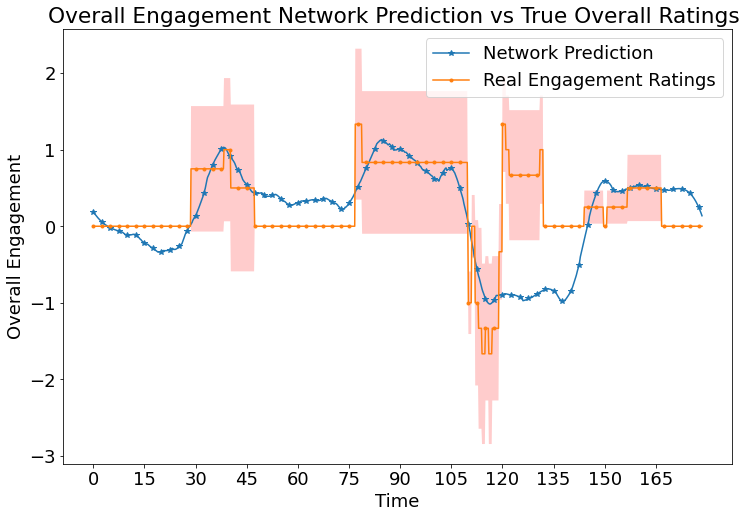

torch.Size([1])
torch.Size([0])
[3, 4, 4, 4, 4, 3, 3, 4]
tensor([-0.1321,  0.4410,  0.3582,  0.6687,  0.5942, -0.8855, -0.0728,  0.4489],
       dtype=torch.float64)

torch.Size([8])
torch.Size([8])


8


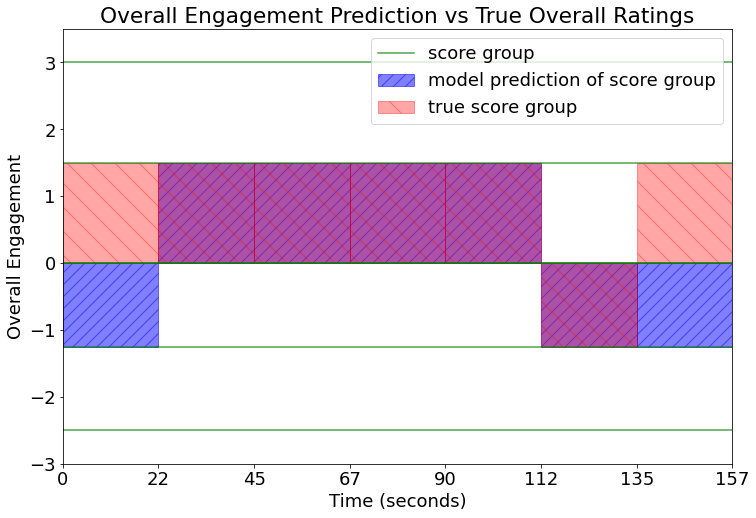

In [ ]:
# import matplotlib.pyplot as plt
# from importlib import reload
# plt = reload(plt)
execfile(f'{content_path}/API/helpers.py')

test_dataset_face = torch.load(f"{content_path}/dataset/faces_videos_stack_test_slice").cpu()
test_dataset_pose = torch.load(f"{content_path}/dataset/poses_videos_stack_test_slice").cpu()

test_genders = torch.load(f"{content_path}/dataset/genders_test_slice")
test_face_ratings = np.load(f"{content_path}/opinions/face_ratings_labels_test_slice.npy")
test_pose_ratings = np.load(f"{content_path}/opinions/pose_ratings_labels_test_slice.npy")
test_overall_ratings = np.load(f"{content_path}/opinions/overall_ratings_labels_test_slice.npy")

test_overall_ratings_dev = np.load(f"{content_path}/opinions/overall_ratings_devs_test_slice.npy")

model_face = torch.load(f"{content_path}/models/face4_VA")
model_pose = torch.load(f"{content_path}/models/body3")
# model_voice = torch.load(f"{content_path}/models/voice1")

# audio processing
audios = []
path = f'{content_path}/dataset/aud/test/'

for j, filename in enumerate(os.listdir(path)):
  if(filename[-3:] == "wav"):
    v, l = aT.file_regression(f'{path}/{filename}', f"{content_path}/models/voice_rdmforrest", "randomforest")
    # print(v, l, )
    audios.append(v[0])

print('no of video clips', len(audios))

audio_models = np.repeat(audios, 3*3)
print(len(audios))
print(test_dataset_face.shape) 
pad = np.full((test_dataset_face.shape[0] - len(audio_models),), 0.0)
audio_models = np.concatenate([pad, audio_models])

outs=[]
outs_rnn=[]
for f in range(test_dataset_face.shape[0]):
  out_face = -5
  out_pose = -5

  model_face.eval()
  if not torch.all(test_dataset_face[f] == 0) and torch.all(test_dataset_face[f] > -99.0):
    with torch.no_grad():
      input = torch.cat((test_genders[f].float(), test_dataset_face[f].float()), 1).flatten(start_dim=1)
      out_face = model_face.forward(input).item()
      outs_rnn.append(model_face.forward(input).item())

  model_pose.eval()
  if not torch.all(test_dataset_pose[f] == 0) and torch.all(test_dataset_pose[f] > -99.0):
    with torch.no_grad():
      input = torch.cat((test_genders[f].float(), test_dataset_pose[f].float()), 1).flatten(start_dim=1)
      out_pose = model_pose.forward(input).item()

  if out_face>-5 and out_pose > -5:
    # this formula obtained 0.71
    outs.append((2*out_face + out_pose + audio_models[f])/5 - 0.5 )

    # this obtains 0.65
    # outs.append((2*out_face + out_pose + audio_models[f])/4 - 1)
  elif out_face>-5:
    outs.append((2*out_face+audio_models[f])/4)
  elif out_pose > -5:
    outs.append((out_pose + audio_models[f])/4)
  else:
    outs.append(0)  

plt.figure(figsize=(12, 8))
plt.title(f'Overall Engagement Network Prediction vs True Overall Ratings ')


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

outs = np.array(outs)    
seq=20
# p = outs[:-12].reshape(len(outs)//seq,seq)
# p = np.mean(p, axis=1)
# p = np.repeat(p, seq)
# p = np.cumsum(p) / [1+i for i in range(len(p))]
from scipy.signal import savgol_filter

p = savgol_filter(outs, 101, 3)

plt.plot(range(len(p)), p, label='Network Prediction', marker = '*',markevery=15)
# plt.plot(range(len(outs)), np.cumsum(outs)/[1+i for i in range(len(outs))], color='blue', alpha=0.8, linewidth=1.0, label='network prediction')
# plt.plot(range(len(test_overall_ratings_dev)), test_overall_ratings_dev, color='red', linewidth=2.0, label = 'Uncertainty Factor')
plt.plot(range(len(test_overall_ratings)), test_overall_ratings, label= 'Real Engagement Ratings', marker = '.',markevery=15)
plt.fill_between(range(len(test_overall_ratings_dev)), test_overall_ratings+test_overall_ratings_dev/2, test_overall_ratings-test_overall_ratings_dev/2, facecolor='r', alpha=0.2)

print(f' Test sequence consists of {len(test_overall_ratings)/6} seconds')

score = 1.0 - (np.sum(np.abs(np.array(outs) - test_overall_ratings) * (1/(1+test_overall_ratings_dev)))) / len(outs)
print(f"Score for the current model: {score}")

score = 1.0 - (np.sum(np.abs(np.array(p) - test_overall_ratings) * (1/(1+test_overall_ratings_dev)))) / len(p)
print(f"Score for the current model after smoothening: {score}")

ccc = ccc_loss(torch.tensor(p), torch.tensor(test_overall_ratings))
print(f"CCC for the current model after smoothening: {ccc}")

# plt.text(2, 3, f'Score obtained for overall engagement: {score}',
#      horizontalalignment='center',
#      verticalalignment='center')

plt.xlabel('Time')
plt.ylabel('Overall Engagement')
x = list(range(10))
plt.xticks(range(0, len(p), 90), [i//6 for i in range(0, len(p), 90)])

# plt.xticks(list(range(len(outs))), range(len(outs)//6)) 
plt.legend()
plt.show()

outs = torch.tensor(outs)
test_overall_ratings = torch.tensor(test_overall_ratings)
test_ratings = test_overall_ratings

seq = 9
outs_p = outs[: (len(outs)//seq) *seq]
outs_short = outs[(len(outs)//seq) *seq:]
print(outs_short.shape)
outs = outs_p.reshape((len(outs_p)//seq, seq))
outs = outs.mean(axis= 1)

if outs_short.shape[0] > 0:
  outs = torch.cat((outs, outs_short.mean().unsqueeze(0)), 0)

test_ratings_p = test_ratings[: (len(test_ratings)//seq) *seq]
test_ratings_short = test_ratings[(len(test_ratings)//seq) *seq:]
test_ratings = test_ratings_p.reshape((len(test_ratings_p)//seq, seq))
test_ratings = test_ratings.mean(axis=1)

eval_fusion_score_group(outs, test_ratings, title="Overall Engagement Prediction vs True Overall Ratings")

### Values recorded as accuraccy using custom weighted MSE:

| Face  |Pose   |Voice   |Accuraccy |
|---|---|---|---|
| face2  | body3  | x  | 0.57   |
| face4_VA  | body3 | voice1 (svm) | 0.65  |
| face2  | body3   | voice1 (svm)   |0.61   |
| face4_VA | body3 | voice_rdmforrest| 0.63 |



## LSTMs

### Experiments

#### VA tests

tensor([335.2640, 385.8000])
tensor([-5.3801,  0.5725], device='cuda:0')
tensor([[-5.3801,  0.5725, -3.2393, -5.5414,  4.5892, -0.8475, -1.3240, -4.2291]],
       device='cuda:0')


/usr/local/lib/python3.7/dist-packages/pyAudioAnalysis/../torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


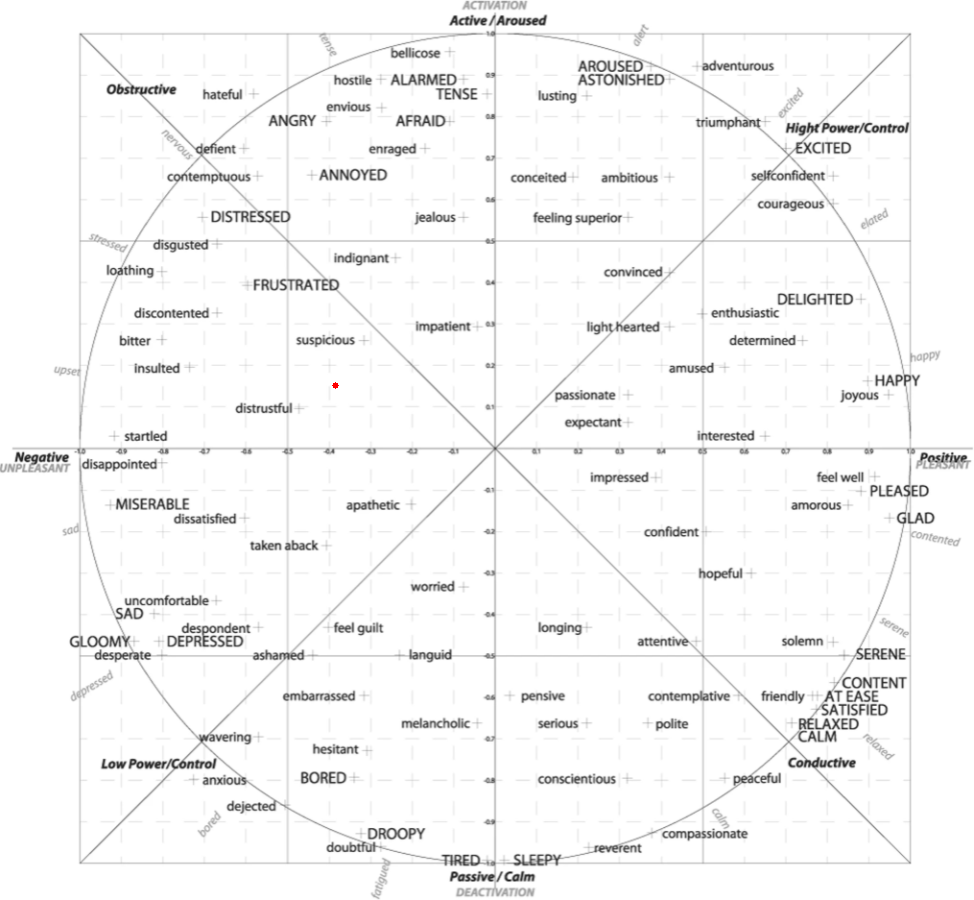

In [ ]:
import PIL
# feat_dataset = torch.load(f"{content_path}/frames/test_frames/CF3.png") 
# # feat_dataset = torch.load(f"{content_path}/dataset/face_training") 
# va = torch.load(f"{content_path}/opinions/face_va_best_training")

# img_no=10

# filename = os.listdir(f"{content_path}/test_pipeline3/frames/")[img_no]
# filename = os.listdir(f"{content_path}/frames/Images_frames_for_video1/")[img_no]
# img_path = f"{content_path}/frames/Images_frames_for_video1/{filename}"  
img_path = f"{content_path}/frames/test_frames/GF2 (1).png" 

wheel = cv2.imread(f"{content_path}/video_features/wheel.PNG")
# va= torch.cat(va,0)
# print(va[img_no].detach()) 

dims = torch.tensor(wheel.shape)
center = torch.Tensor([45,-40]) + dims[:2]/2
# cv2.circle(wheel, (center[0], center[1]), radius=3, color=(0, 0, 255), thickness=-3)

w_step = dims[1]/2.5
h_step= - dims[0]/2.5

va_vals = torch.tensor([-0.41, 0.17])

va_coord = va_vals * torch.tensor([w_step, h_step]) + center
print(va_coord)

cv2.circle(wheel, (va_coord[0], va_coord[1]), radius=3, color=(0, 0, 255), thickness=-3)

model = torch.load(f'{content_path}/models/enet_b0_8_best_afew.pt', map_location='cuda:0')
model.eval() 

# res_img, img = align_crop_resize_per_frame("face", img_size=img.shape[:2], data_feature=None, show_ref_images=True, img_path=img_path)

img = Image.open(img_path)
# Preprocess image
# img = Image.fromarray(img)
tfms = transforms.Compose([transforms.Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR),  
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])
img = tfms(img).unsqueeze(0)

with torch.no_grad():
  values = model(img.cuda())
  print(values[0][:2].detach())
  print(values)

va_vals = torch.tensor(values[0][:2]).cpu()
va_coord = torch.tensor([-va_vals[0], va_vals[1]]) * torch.tensor([w_step, h_step]) + center
# print(va_coord)  

cv2.circle(wheel, (va_coord[0], va_coord[1]), radius=3, color=(255, 0, 0), thickness=-3)
 
cv2_imshow(wheel)

In [ ]:
!pip install deepface
from deepface import DeepFace

execfile(f'{content_path}/va_extractor_model/VA_face/run_pretrained_model.py')

img_path = f"{content_path}/frames/test_frames/GF2 (1).png" 

folder = f'{content_path}/frames/test_frames' 
for img_name in os.listdir(folder):
  print(img_name)
  if img_name[-3:] not in ['png', 'jpg']:
    continue
  img = f'{folder}/{img_name}'
  print(img)
  pic = cv2.imread(img)
  cv2_imshow(pic)
  face = DeepFace.detectFace(pic)
  plt.imshow(face)
  print(f'{folder}/aligned_frames/{img_name}')
  plt.imsave(f'{folder}/aligned_frames/{img_name}', face)

path = f'{content_path}/frames/test_frames/aligned_frames/'
res = f'/results_va_aligned'

extract_VA(path,res)

ModuleNotFoundError: ignored

In [ ]:
va = []
f = open("/content/results_va_aligned2/merged/VA.txt", "r")
for i, x in enumerate(f):
  if i == 0:
    continue
  v,a = x.split(",")
  v,a = float(v), float(a)
  va.append(torch.tensor([v,a]))

va = pd.read_csv("/content/results_va_aligned2/merged/VA.txt")
print(va[2])
wheel = cv2.imread(f"{content_path}/video_features/wheel.PNG")
# va= torch.cat(va,0)
# print(va[img_no].detach()) 

dims = torch.tensor(wheel.shape)
center = torch.Tensor([45,-40]) + dims[:2]/2
# cv2.circle(wheel, (center[0], center[1]), radius=3, color=(0, 0, 255), thickness=-3)

w_step = dims[1]/2.5
h_step= - dims[0]/2.5

va_vals = va[2]

va_coord = va_vals * torch.tensor([w_step, h_step]) + center
# print(va_coord)

cv2.circle(wheel, (va_coord[0], va_coord[1]), radius=3, color=(0, 0, 255), thickness=-3)
cv2_imshow(wheel)

FileNotFoundError: ignored

#### Augmentation 

tensor([-0.3261,  0.2813])
tensor([-133.2474, -113.4362])
tensor([361.7526, 333.5638])


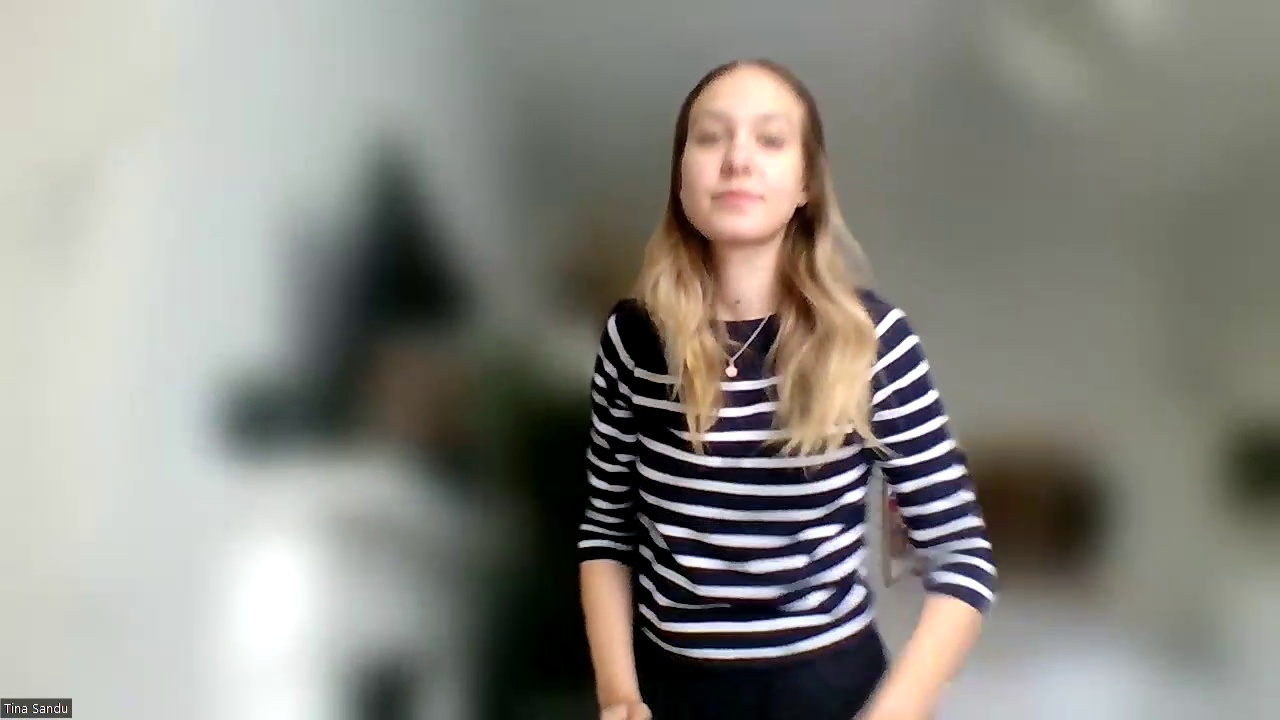

2764800


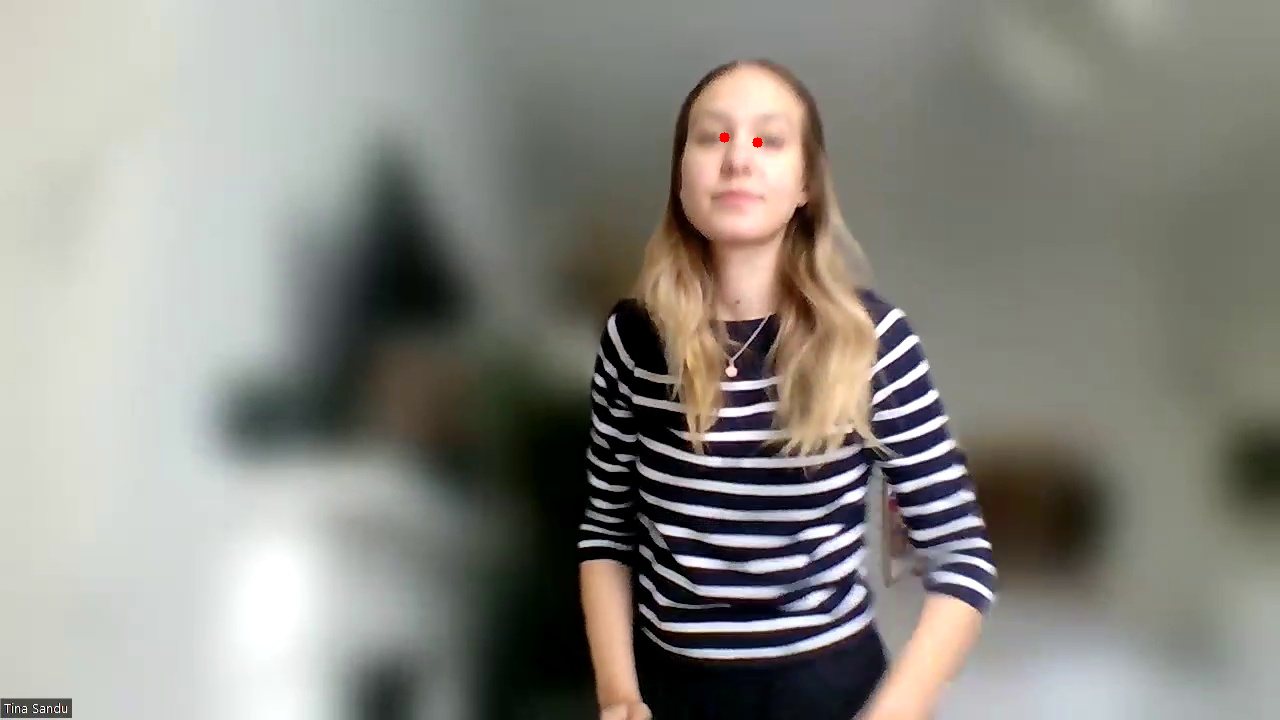

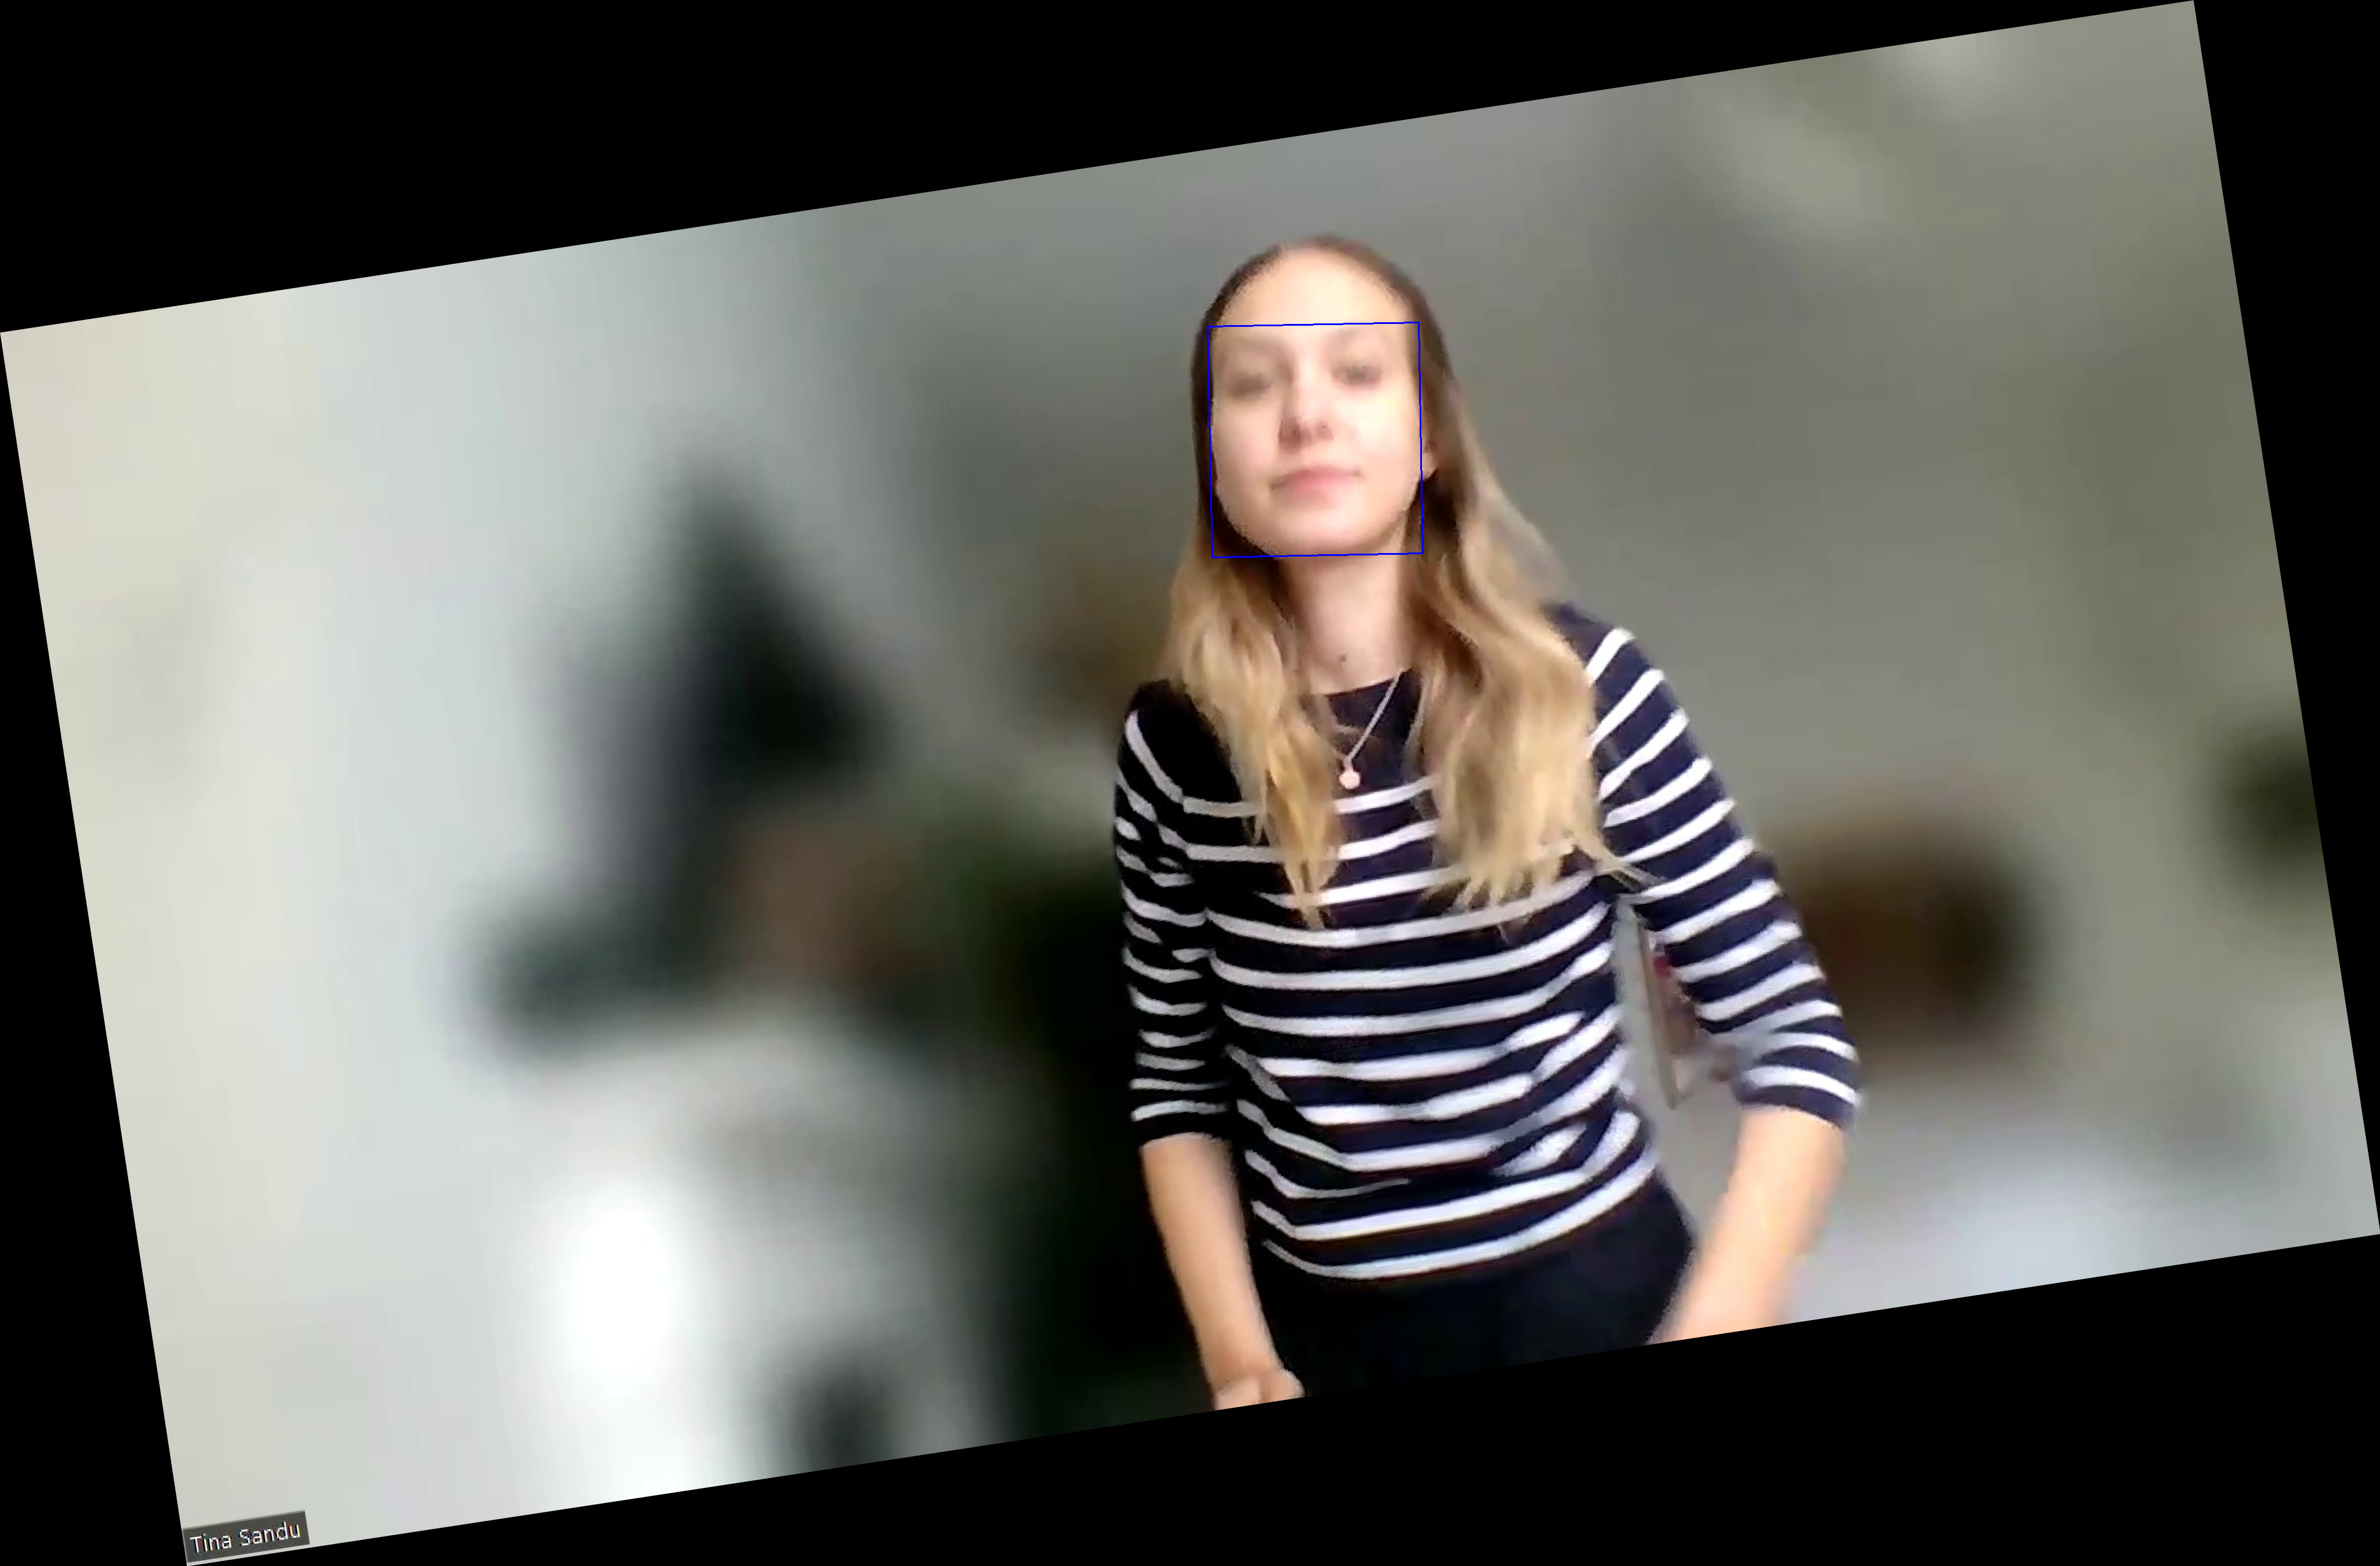

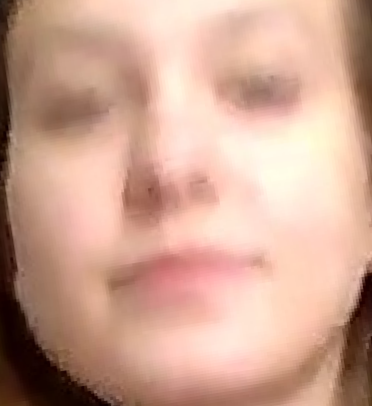

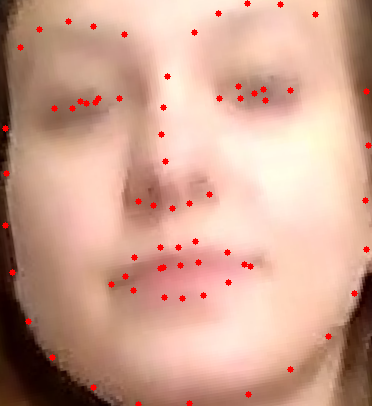

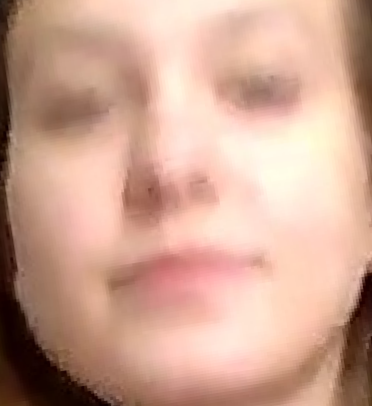

flipped


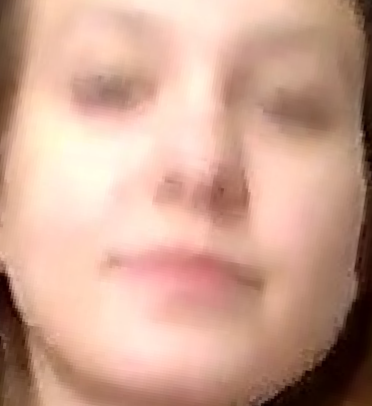

In [ ]:
feat_dataset = torch.load(f"{content_path}/test_pipeline3/features/face_features") 
# feat_dataset = torch.load(f"{content_path}/dataset/face_training") 
va = torch.load(f"{content_path}/opinions/face_va_best_training")

img_no=10

filename = os.listdir(f"{content_path}/test_pipeline3/frames/")[img_no]
# filename = os.listdir(f"{content_path}/frames/Images_frames_for_video1/")[img_no]
# img_path = f"{content_path}/frames/Images_frames_for_video1/{filename}"  
img_path = f"{content_path}/test_pipeline3/frames/{filename}"  

wheel = cv2.imread(f"{content_path}/video_features/wheel.PNG")
va= torch.cat(va,0)
print(va[img_no].detach()) 

dims = torch.tensor(wheel.shape)
center = torch.Tensor([45,-40]) + dims[:2]/2
cv2.circle(wheel, (center[0], center[1]), radius=3, color=(0, 0, 255), thickness=-3)

w_step = dims[1]/2.8
h_step= - dims[0]/1.9

va_vals = torch.tensor([va[img_no][1] * h_step, va[img_no][0] * w_step])
print(va_vals)
va_coord = va_vals + center
print(va_coord)

cv2.circle(wheel, (va_coord[0], va_coord[1]), radius=3, color=(0, 0, 255), thickness=-3)
cv2_imshow(wheel)

lady = cv2.imread(img_path)
cv2_imshow(lady)
print(lady.size)
res_img, img = align_crop_resize_per_frame("face", img_size=lady.shape[:2], data_feature=feat_dataset[img_no], show_ref_images=True, img_path=img_path)

cv2_imshow(img)

dims = img.shape[:2]

def flip_vec(feat_vec, image=None):
  flip_vec = feat_vec 
  height, width = (360, 640)

  if image is not None:
    flip_image = cv2.flip(image, 1)
    height, width = image.shape[:2]

  col = width - flip_vec[0,:,0]
  flip_vec[0,:,0] =  col

  if image is not None: 
    return flip_vec, flip_image
  return flip_vec  

print("flipped")
frame, img = flip_vec(res_img, img)
cv2_imshow(img)


def rotate_vec(feat_vec, angle, image=None):
  feat_vec = feat_vec[0,:,:2]
  theta = math.radians(angle)
  if image is not None:
    height, width = image[:2]
  else:
    height, width = (360, 640)
  (cX, cY) = (width // 2, height // 2)
  M = cv2.getRotationMatrix2D((cX, cY), np.degrees(theta), 1.0)
  cos = np.abs(M[0, 0])
  sin = np.abs(M[0, 1]) 
  nW = int((height * sin) + (width * cos))
  nH = int((height * cos) + (width * sin)) 
  M[0, 2] += (nW / 2) - cX
  M[1, 2] += (nH / 2) - cY

  theta = -theta
  A = np.matrix([[np.cos(theta), -np.sin(theta)],
                [np.sin(theta), np.cos(theta)]])
  
  data_c = feat_vec-np.array([cX, cY])

  data_rotated = data_c @ A.T
  data_rotated += np.array([(nW/2, nH/2)])

  if image is not None:
    img_rot = cv2.warpAffine(img, M, (nW, nH))
    return data_rotated, img_rot

  return data_rotated  

# frame, img = rotate_vec(res_img, 10, img)

# print(frame.shape)

# for face_points in frame[0]:
#       face_points = np.array(face_points)
#       x = int(face_points[0])
#       y = int(face_points[1])
#       if x>0 and y>0:
#         cv2.circle(img, (x,y), radius=3, color=(0, 0, 255), thickness=-3)

# cv2_imshow(img)

# model = torch.load(f'{content_path}/models/enet_b2_8.pt', map_location='cuda:0')
# model.eval() 

# img = Image.open(f"{content_path}/frames/Images_frames_for_video1/{filename}" )
# Preprocess image
# img = Image.fromarray(img)
# tfms = transforms.Compose([transforms.Resize((dims[0], dims[1])),  
#       transforms.ToTensor(),
#       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
# img = tfms(img).unsqueeze(0)

# with torch.no_grad():
#   values = model(img.cuda())
#   print(values[0][:2])
#   print(values[0][1]-0.2, values[0][2])
#   print(values)

# print(va[img_no].detach()) 


In [ ]:
def augment_dataset(feature_vec):
  augs = 8
  aug_set = torch.Tensor(augs, feature_vec.shape[0], feature_vec.shape[1], feature_vec.shape[2], feature_vec.shape[3], feature_vec.shape[4])
  aug_set[0] = feature_vec

  for s, seq in enumerate(feature_vec):
    for f, frame in enumerate(seq):
      # flip
      aug_set[1][s][f] = flip_vec(frame)
      # rotate -5
      frame = frame.cpu()
      aug_set[2][s][f][0,:,:2] = rotate_vec(frame, -3)
      # rotate 5
      aug_set[3][s][f][0,:,:2] = rotate_vec(frame, 3)
      # rotate 10
      aug_set[4][s][f][0,:,:2] = rotate_vec(frame, -6)
      # rotate -10
      aug_set[5][s][f][0,:,:2] = rotate_vec(frame, 6)
      # rotate flip 5
      aug_set[6][s][f][0,:,:2] = rotate_vec(aug_set[1][s][f], -3)
      # rotate flip -5
      aug_set[7][s][f][0,:,:2] = rotate_vec(aug_set[1][s][f], 3)

  return aug_set  



In [ ]:
class VisualFeatureDatasetLSTMAug(Dataset):

    def __init__(self, feat, dataset, VA=True, transform=False, align=True, frames_per_seq=12, augment=True, device = 'cuda:0'):
        self.feat = feat
        self.dataset = dataset
        self.align = align
        self.transform = transform
        self.device = device
        self.VA = VA

        if VA:
          self.va = torch.load(f"{content_path}/opinions/{self.feat}_va_best_{self.dataset}")

        self.feat_dataset = torch.load(f"{content_path}/dataset/{self.feat}_{dataset}")
        self.genders = torch.load(f"{content_path}/dataset/genders_{dataset}")
        self.ratings = np.load(f"{content_path}/opinions/{self.feat}_ratings_labels_{dataset}.npy")
        self.ratings_std = np.load(f"{content_path}/opinions/{self.feat}_ratings_devs_{dataset}.npy")
        self.ratings = Tensor(self.ratings)
        self.ratings_std = Tensor(self.ratings_std)

        good = torch.where(self.ratings > 2.5, 1, 0)
        n_good = torch.where(torch.logical_and(self.ratings > 0,self.ratings <= 2.5), 1, 0)
        n_bad = torch.where(torch.logical_and(self.ratings > -2.5, self.ratings <= 0), 1, 0)
        bad = torch.where(self.ratings <= -2.5, 1, 0)

        print('good', torch.sum(good))
        print('n_good', torch.sum(n_good))
        print('n_bad', torch.sum(n_bad))
        print('bad', torch.sum(bad))

        if transform:
          self.ratings = F.pad(self.ratings, (0,(frames_per_seq- self.ratings.shape[0] % frames_per_seq)),  "constant", 0. )
          self.ratings = self.ratings.reshape(self.ratings.shape[0]//frames_per_seq, frames_per_seq)
          self.ratings= torch.mean(self.ratings, dim=1)

          self.feat_dataset = F.pad(self.feat_dataset, (0, 0, 0, 0, 0, 0, 0, (frames_per_seq- self.feat_dataset.shape[0] % frames_per_seq)),  "constant", 0. )
          self.feat_dataset = self.feat_dataset.reshape(self.feat_dataset.shape[0]//frames_per_seq, frames_per_seq, self.feat_dataset.shape[1], self.feat_dataset.shape[2], self.feat_dataset.shape[3]) 

          if VA:
            self.va = torch.cat(self.va, 0)
            self.va = F.pad(self.va, (0, 1 ,0,(frames_per_seq- self.va.shape[0] % frames_per_seq)),  "constant", 0. )
            self.va = self.va.reshape(self.va.shape[0]//frames_per_seq, frames_per_seq, 1, 1, 3)

          if augment:
            print(self.feat_dataset.shape)
            self.feat_dataset = augment_dataset(self.feat_dataset).flatten(start_dim=0, end_dim=1)
            print(self.feat_dataset.shape)

            print("ratings", self.ratings.shape)
            self.ratings = self.ratings.unsqueeze(0).repeat_interleave(8, dim=0).flatten(start_dim=0, end_dim=1)
            print("ratings aug", self.ratings.shape)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):

        gender = self.genders[idx]
        face_frame = self.feat_dataset[idx].to(device)

        rating = self.ratings[idx]
        rating_std = self.ratings_std[idx]

        if self.transform:
          if self.align:
            frame_seq = align_crop_resize_per_seq(self.feat, data=face_frame)
            frame_seq = frame_seq.flatten(start_dim=1)

          if self.VA:
            va = self.va[idx].to(device)
            frame_seq = torch.cat((va, frame_seq), 2).flatten(start_dim=1)

          features = frame_seq.float()

        return features, rating, rating_std


In [ ]:
batch_size = 64
seq_len = 9
train_dataset = VisualFeatureDatasetLSTMAug("pose", "training_unfiltered", False, True, True, seq_len, augment=True, device=device)
valid_dataset = VisualFeatureDatasetLSTMAug("pose", "validation_unfiltered", False, True, True, seq_len, augment=True, device=device)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

input_dim = len(train_dataset[0][0][0].flatten())
print(input_dim)

output_dim = 1
hidden_dim = 8
layer_dim = 1
learning_rate = 0.0001
model_name = "LSTM_body_aligned_seq_9_augmented2"
model_type = "LSTM"
num_epochs = 500
valid_freq = 5
patience = 5
bidir=False

va_padding = 1
VA=False

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

### Change the code below to try running different models:
## TODO: Also pass in bidirectional parameter and alter code for this.
# model = create_trainable_Network_Body((1+ 2*21 + 25)*3)  
model = RNNModel(model_type, input_dim, hidden_dim, layer_dim, output_dim, device, bidir=bidir)

# criterion = nn.MSELoss(reduction='sum')

# criterion = lambda out, res, std : torch.sum(2/(1+std) * (out - res.float()) ** 2)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train_for_feat_datasetLSTM(model, 
#                        (model_name, "pose", model_type), 
#                        train_loader, 
#                        valid_loader, 
#                        criterion='weighted_MSE', 
#                        optimiser=optimiser, 
#                        device=device, 
#                        num_epochs=num_epochs, 
#                        valid_freq=valid_freq,
#                        VA=(VA, va_padding),
#                        patience_threshold=patience)

# gen_feat_graph_and_score(model_name, "pose", model_type = model_type, VA=VA, frames_per_seq=seq_len, show_graph=True)

good tensor(1686, device='cuda:0')
n_good tensor(3552, device='cuda:0')
n_bad tensor(2254, device='cuda:0')
bad tensor(0, device='cuda:0')
torch.Size([833, 9, 1, 67, 3])


NameError: ignored

### LSTM functions (added to RNN.py)


In [ ]:
import os
import pandas as pd

def train_for_audio_dataset(network, name, loader_train, loader_val, criterion, optimiser, device="cpu", num_epochs=10, valid_freq=1, VA=False, patience_threshold = 5):
      network.to(device)

      losses = []
      losses_validation = []
      iterations = []
      patience = patience_threshold

      for epoch in range(num_epochs):
        network.train()
        loss_train = 0
        train_total = 0
        ############################### Loop over training iterations  
        for iter, (audio, labels, stds) in enumerate(loader_train):
          optimiser.zero_grad()
      
          seq_dim, input_dim = audio.shape[1], audio.shape[2]
          audio = Variable(audio.view(-1, seq_dim, input_dim).to(device))
          labels = Variable(labels.to(device))
          stds = Variable(stds.to(device))
 
          network_prediction = network(audio.float()).squeeze(-1)

          # loss = torch.nn.MSELoss()(network_prediction, y.float()) * y_dev
          # loss = torch.sum(2/(1+y_dev) * (network_prediction - y.float()) ** 2)
          if criterion == 'MSE':
            loss = torch.nn.MSELoss(reduction='sum')(network_prediction.float(), labels.float())
          elif criterion == "CCC":
                loss = ccc_loss(network_prediction, labels)
              
          else:
            loss = torch.sum(2/(1+ stds) * (network_prediction - labels) ** 2)

          loss.backward()
          loss_value = loss.item()

          train_total += labels.size(0)
          loss_train += loss_value

          optimiser.step()
          print('Epoch: %d, Iteration: %d, training loss = %.4f' % (epoch, iter, loss_value))         

        losses.append(loss_train/train_total)
        iterations.append(epoch)

        ###################### check performance on validation set
        if epoch % valid_freq == 0:
          network.eval()
          v_loss = 0
          v_total = 0
          with torch.no_grad():
            for v_iter, (v_audio, v_labels, v_stds) in enumerate(loader_val):
              v_audio = Variable(v_audio.view(-1, seq_dim, input_dim)).to(device)
              v_labels = Variable(v_labels.to(device))

              v_outputs = network(v_audio).squeeze(-1)
              v_stds = Variable(v_stds.to(device))

              v_total += v_labels.size(0)
              # loss = criterion(v_outputs.float(), v_labels.float())
              if criterion == 'MSE':
                loss = torch.nn.MSELoss(reduction='sum')(v_outputs.float(), v_labels.float())
              elif criterion == "CCC":
                loss = ccc_loss(v_outputs, v_labels)
              else:
                loss = torch.sum(2/(1+ v_stds) * (v_outputs - v_labels) ** 2)

              v_loss_value = loss.item()
              v_loss += v_loss_value
              print('Epoch: %d, Iteration: %d, valid loss = %.4f' % (epoch, v_iter, v_loss_value))         
              
          losses_validation.append(v_loss/v_total)

        # TODO: possibly rethink early stopping code here and check how it works.
        if epoch > 10 and (losses_validation[int(epoch / valid_freq) - 1] < losses_validation[int(epoch / valid_freq)]):
            patience -= 1
        else:
            patience = patience_threshold

        if patience == 0:
            break

      plot_loss_iters(name, content_path, valid_freq, losses, losses_validation)

      torch.save(network, f"{content_path}/models/{name}")

def align_crop_resize_per_seq(feat, data):
  for i in range(data.shape[0]):
    face_frame = align_crop_resize_per_frame(feature=feat, data_feature=data[i])
    data[i] =F.pad(face_frame, (0,1), "constant", 0.)
  return data  

def train_for_feat_datasetLSTM(network, name, loader_train, loader_val, criterion, optimiser, device="cpu", num_epochs=10, valid_freq=1, VA=False, patience_threshold = 5):
      (name, feat, model_type) = name
      VA, va_padding = VA
      network.to(device)

      losses = []
      losses_validation = []
      iterations = []
      patience = patience_threshold

      for epoch in range(num_epochs):
        network.train()
        loss_train = 0
        train_total = 0
        ############################### Loop over training iterations  
        for iter, (input, labels, stds) in enumerate(loader_train):
          optimiser.zero_grad()
          seq_dim = input.shape[1]
          input_dim = input.shape[-1]
          
          feature = Variable(input.view(-1, seq_dim, input_dim)).to(device)
          labels = Variable(labels.to(device))
          stds = Variable(stds.to(device))
                    
          network_prediction = network(feature.float()).squeeze(-1)
          
          if criterion == 'MSE':
            loss = torch.nn.MSELoss(reduction='sum')(network_prediction.float(), labels.float())
          else:
            loss = torch.sum(2/(1+ stds) * (network_prediction - labels) ** 2)

          loss.backward()
          loss_value = loss.item()

          train_total += labels.size(0)
          loss_train += loss_value

          optimiser.step()
          if epoch % 10 == 0 and iter % 20 == 0: 
            print('Epoch: %d, Iteration: %d, training loss = %.4f' % (epoch, iter, loss_value))         

        losses.append(loss_train/train_total)
        iterations.append(epoch)

        ###################### check performance on validation set
        if epoch % valid_freq == 0:
          network.eval()
          v_loss = 0
          v_total = 0
          with torch.no_grad():
            for v_iter, (input, v_labels, v_stds) in enumerate(loader_val):
              
              v_feat = Variable(input.view(-1, seq_dim, input_dim)).to(device)

              v_labels = Variable(v_labels.to(device))

              v_outputs = network(v_feat).squeeze(-1)
              v_stds = Variable(v_stds.to(device))

              v_total += v_labels.size(0)
              # loss = criterion(v_outputs.float(), v_labels.float())
              if criterion == 'MSE':
                loss = torch.nn.MSELoss(reduction='sum')(v_outputs.float(), v_labels.float())
              else:
                loss = torch.sum(2/(1+ v_stds) * (v_outputs - v_labels) ** 2)

              v_loss_value = loss.item()
              v_loss += v_loss_value

              if iter % 20 == 0: 
                print('Epoch: %d, Iteration: %d, valid loss = %.4f' % (epoch, v_iter, v_loss_value))         
              
          losses_validation.append(v_loss/v_total)

        if epoch > 10 and (losses_validation[int(epoch / valid_freq) - 1] < losses_validation[int(epoch / valid_freq)]):
            patience -= 1
        else:
            patience = patience_threshold

        if patience == 0:
            break

      plot_loss_iters(name, content_path, valid_freq, losses, losses_validation)
      torch.save(network, f"{content_path}/models/{name}")

class VisualFeatureDatasetLSTM(Dataset):

    def __init__(self, feat, dataset, VA=True, transform=False, align=True, frames_per_seq=12, device = 'cuda:0', out_seq=False):
        self.feat = feat
        self.dataset = dataset
        self.align = align
        self.transform = transform
        self.device = device
        self.VA = VA

        if VA:
          self.va = torch.load(f"{content_path}/opinions/{self.feat}_va_best_{self.dataset}")

        self.feat_dataset = torch.load(f"{content_path}/dataset/{self.feat}_{dataset}")
        self.genders = torch.load(f"{content_path}/dataset/genders_{dataset}")
        self.ratings = np.load(f"{content_path}/opinions/{self.feat}_ratings_labels_{dataset}.npy")
        self.ratings_std = np.load(f"{content_path}/opinions/{self.feat}_ratings_devs_{dataset}.npy")
        self.ratings = Tensor(self.ratings)
        self.ratings_std = Tensor(self.ratings_std)

        if transform:
          self.ratings = F.pad(self.ratings, (0,(frames_per_seq- self.ratings.shape[0] % frames_per_seq)),  "constant", 0. )
          self.ratings = self.ratings.reshape(self.ratings.shape[0]//frames_per_seq, frames_per_seq)

          self.ratings_std = F.pad(self.ratings_std, (0,(frames_per_seq- self.ratings_std.shape[0] % frames_per_seq)),  "constant", 0. )
          self.ratings_std = self.ratings_std.reshape(self.ratings_std.shape[0]//frames_per_seq, frames_per_seq)
          
          if not out_seq:
            self.ratings= torch.mean(self.ratings, dim=1)
            self.ratings_std= torch.mean(self.ratings_std, dim=1)


          self.feat_dataset = F.pad(self.feat_dataset, (0, 0, 0, 0, 0, 0, 0, (frames_per_seq- self.feat_dataset.shape[0] % frames_per_seq)),  "constant", 0. )
          self.feat_dataset = self.feat_dataset.reshape(self.feat_dataset.shape[0]//frames_per_seq, frames_per_seq, self.feat_dataset.shape[1], self.feat_dataset.shape[2], self.feat_dataset.shape[3]) 

          if VA:
            self.va = torch.cat(self.va, 0)
            self.va = F.pad(self.va, (0, 1 ,0,(frames_per_seq- self.va.shape[0] % frames_per_seq)),  "constant", 0. )
            self.va = self.va.reshape(self.va.shape[0]//frames_per_seq, frames_per_seq, 1, 1, 3)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):

        gender = self.genders[idx]
        face_frame = self.feat_dataset[idx].to(device)
        rating = self.ratings[idx]
        rating_std = self.ratings_std[idx]

        if self.transform:
          if self.align:
            frame_seq = align_crop_resize_per_seq(self.feat, data=face_frame)

          if self.VA:
            va = self.va[idx].to(device)
            frame_seq = torch.cat((va, frame_seq), 2)

          frame_seq = frame_seq.flatten(start_dim=1)
          features = frame_seq.float()

        return features, rating, rating_std

def align_crop_resize_per_frame(feature, img_size = None, data_feature=None, path=None, show_ref_images = False, img_path=None):
  if feature == "face":
    POIS = [42, 39]
    ideal_dist = 100.

  elif feature == "pose":
    POIS = [2, 5]
    ideal_dist = 200.
    
  else:
    return

  if img_size is None:
    h, w = (360, 640)
  else:
    h, w = img_size

  if data_feature is not None:
    datapoints = data_feature
    if show_ref_images:
      assert img_path is not None
      filename = img_path

  else:  
    datapoints = torch.load(path[0])
    filename = path[1]

  points = torch.full((datapoints.shape[0], datapoints.shape[1], datapoints.shape[2]-1), 0.)
  data_full = datapoints[0]

  if torch.all(data_full == 0):
    return points

  if show_ref_images:
    if(filename[-3:] not in ['jpg', 'png']):
      return
    img = cv2.imread(f'{filename}')
    img_copy = img.copy()

    # Draw human poses on image
    for face_points in [data_full[POIS[0]], data_full[POIS[1]]]:
        x = int(face_points[0])
        y = int(face_points[1])
        if x>0 and y>0:
          cv2.circle(img_copy, (x,y), radius=5, color=(0, 0, 255), thickness=-3)

    # Visualize Image
    cv2_imshow(img_copy)

  lx, ly, _ = data_full[POIS[0]]   #left shoulder    
  rx, ry, _ = data_full[POIS[1]]   #right shoulder
  dx = rx-lx
  dy = ry-ly

  if dx != 0:
    tan = dy/dx
    theta = np.arctan(tan.cpu())
  else:
    theta = 0. 
  
  dist =  torch.sqrt(((data_full[POIS[0]][:2] - data_full[POIS[1]][:2])**2).sum(axis=0).float())
  if dist == 0:
    return points
  ratio = float(ideal_dist/dist)
  
  width = int(w * ratio)
  height = int(h * ratio)
  
  # M, (nW, nH), center = rotate_bound(img, np.degrees(theta))
  (cX, cY) = (width // 2, height // 2)
  M = cv2.getRotationMatrix2D((cX, cY), np.degrees(theta), 1.0)
  cos = np.abs(M[0, 0])
  sin = np.abs(M[0, 1]) 
  nW = int((height * sin) + (width * cos))
  nH = int((height * cos) + (width * sin)) 
  M[0, 2] += (nW / 2) - cX
  M[1, 2] += (nH / 2) - cY 

  # rotation
  theta = -theta
  A = np.matrix([[np.cos(theta), -np.sin(theta)],
                [np.sin(theta), np.cos(theta)]])

  data = np.float32(data_full[:,:2].cpu())

  # strip of 0s and -100s
  ind = np.logical_and(np.array(data).sum(axis=1) != 0, np.array(data).sum(axis=1) != -200.)

  data = data[np.array(data).sum(axis=1) != 0.]
  data = data[np.array(data).sum(axis=1) != -200.]

  data *= (ratio)
  data_c = data-np.array([cX, cY])
  data_rotated = data_c @ A.T
  data_rotated += np.array([(nW/2, nH/2)])
  
  # crop  
  box = cv2.minAreaRect(np.int0(data_rotated))
  bbox = np.int0(cv2.boxPoints(box))
  data_cropped = data_rotated - [np.min(bbox[:,0]), np.min(bbox[:,1])]

  points[0][ind] = torch.Tensor(data_cropped)

  if show_ref_images:
    img = cv2.resize(img, (width, height), interpolation = cv2.INTER_AREA)
    img_rot = cv2.warpAffine(img, M, (nW, nH))

    img_copy = img_rot.copy()

    img_copy = cv2.drawContours(img_copy, [bbox], 0, (255, 0, 0), 2)
    # img_rot = cv2.circle(img_rot, (bbox[1][0], bbox[1][1]), 0, (255, 255, 0), 10)

    cv2_imshow(img_copy)

    img_crop = img_rot[np.min(bbox[:,1]):np.max(bbox[:,1]), np.min(bbox[:,0]):np.max(bbox[:,0]) ]    

    cv2_imshow(img_crop)
    img_copy = img_crop.copy()

    for face_points in data_cropped:
      face_points = np.array(face_points)
      x = int(face_points[0][0])
      y = int(face_points[0][1])
      if x>0 and y>0:
        cv2.circle(img_copy, (x,y), radius=3, color=(0, 0, 255), thickness=-3)

    # Visualize Image
    cv2_imshow(img_copy)

    return points, img_crop
  # print(points)
  return points  

class GRUModel_Att(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, device = "cpu", dropout_prob = 0.2, bidir=False):
        super(GRUModel_Att, self).__init__()
        self.device = device

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=bidir)

        # Fully connected layer
        if bidir:
          self.fc = nn.Linear(hidden_dim * 2, output_dim)
        else:  
          self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, return_h=False):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim, device=self.device).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h = self.gru(x, h0.detach())

        # Convert the final state to our desired output shape (batch_size, output_dim)
        
        if return_h:
          return out, h

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]
        
        out = self.fc(out)
        return out

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, device = "cpu", dropout_prob = 0.2, bidir=False):
        super(GRUModel, self).__init__()
        self.device = device

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=bidir)

        # Fully connected layer
        if bidir:
          self.fc = nn.Linear(hidden_dim * 2, output_dim)
        else:  
          self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=self.device).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out        

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, device = "cpu", dropout_prob = 0.2, bidir=False):
        super(LSTMModel, self).__init__()
        self.device = device

        ## TODO: add in bidirectional parameter

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=bidir)

        # Fully connected layer
        if bidir:
          self.fc = nn.Linear(hidden_dim * 2, output_dim)
        else: 
          self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=self.device).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.lstm(x)

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out
class RNNModel(nn.Module):
  def __init__(self, model_type, input_dim, hidden_dim, layer_dim, output_dim, device = "cpu", dropout_prob = 0.2, bidir=False):
    super(RNNModel, self).__init__()
    if model_type == "GRU":
      self.model = GRUModel(input_dim, hidden_dim, layer_dim, output_dim, device, dropout_prob, bidir)
    elif model_type == "LSTM":
      self.model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim, device, dropout_prob, bidir)
    elif model_type == "GRU_Att":
      self.model = GRUModel_Att(input_dim, hidden_dim, layer_dim, output_dim, device, dropout_prob, bidir)

  def forward(self, x):
    return self.model(x)

import os
import pandas as pd

class VisualFeatureDataset(Dataset):

    def __init__(self, feat, dataset, VA=True, transform=False, align=True, device = 'cuda:0'):
        self.feat = feat
        self.dataset = dataset
        self.align = align
        self.transform = transform
        self.device = device
        self.VA = VA

        if VA:
          self.va = torch.load(f"{content_path}/opinions/{self.feat}_va_best_{self.dataset}")

        # self.feat_dataset = torch.load(f"{content_path}/dataset/{self.feat}s_videos_stack_{dataset}")
        self.feat_dataset = torch.load(f"{content_path}/dataset/{self.feat}_{dataset}")
        self.genders = torch.load(f"{content_path}/dataset/genders_{dataset}")
        self.ratings = np.load(f"{content_path}/opinions/{self.feat}_ratings_labels_{dataset}.npy")
        self.ratings_std = np.load(f"{content_path}/opinions/{self.feat}_ratings_devs_{dataset}.npy")
        self.ratings = Tensor(self.ratings)
        self.ratings_std = Tensor(self.ratings_std)

        if transform:
          self.mask = self.feat_dataset[:, 0, 0 , 0] > -99.0
          self.feat_dataset = self.feat_dataset[self.mask]
          self.genders = self.genders[self.mask]
          self.ratings = self.ratings[self.mask]
          self.ratings_std = self.ratings_std[self.mask]

          if VA:
            self.va = torch.cat(self.va, 0)
            self.va = self.va[self.mask]

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):

        gender = self.genders[idx]
        face_frame = self.feat_dataset[idx]

        rating = self.ratings[idx]
        rating_std = self.ratings_std[idx]

        if self.transform:
          if self.align:
            face_frame = align_crop_resize_per_frame(self.feat, data_feature=face_frame)
            face_frame = F.pad(face_frame, (0,1), "constant", 0.)
          
          if self.VA:
            self.genders[:,0,0,1:] = self.va 
          features = torch.cat((gender.to(device), face_frame.to(device)), 1).flatten(start_dim=1)
          features = features.float()

        return features, rating, rating_std

class VocalSnippetsDataset(Dataset):

    def __init__(self, path, dataset, transform=False, VA=False):
        self.dataset = dataset
        self.transform = transform
        self.VA = VA
        self.img_labels = pd.read_csv(f'{path}/{dataset}/{dataset}_labels_stddev.csv')
        self.img_dir = f'{path}/{dataset}'

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        sample_file = f'{self.img_dir}/{self.img_labels.iloc[idx, 0]}'

        label = self.img_labels.iloc[idx, 1]
        std = self.img_labels.iloc[idx, 2]
        # print(std)

        if not self.transform:
          clip = read(sample_file)
          return clip, label, std
          
        else:
            # librosa
            clip = read(sample_file)
            features = librosa.feature.mfcc(y=clip[1].astype(float), sr=clip[0], hop_length=512, n_fft=2048).transpose().astype(np.float32)
            
            # pyAudio
            # [Fs, x] = audioBasicIO.read_audio_file(sample_file)
            # F, f_names = ShortTermFeatures.feature_extraction(x, Fs, 0.050*Fs, 0.025*Fs, deltas=False)
            # print(f_names)
            # mfcc features for now
            # features = F[8:20, :]
            if self.VA:
              va, l = aT.file_regression(sample_file, f"{content_path}/models/va_voice_svm", "svm")
              p1d = (0, features[1] - len(va))
              va = F.pad(torch.Tensor(va).view(1,2), (0, 18), "constant", 0)
              features = torch.cat((va, torch.tensor(features)), dim=0)
              return features, label, std
            else:
              return features, label, std


def plot_loss_iters(name, content_path, valid_freq, losses, losses_validation):
    # Plot and save the loss vs iterations graph
    fig, ax = plt.subplots()
    ax.set(xlabel='Iteration', ylabel='Loss', title=f'Loss Curve for {name}')
    ax.plot(range(len(losses[1:])), losses[1:], color='blue')
    ax.plot(range(0, len(losses_validation[1:]) * valid_freq, valid_freq), losses_validation[1:], color='orange')

    plt.show()
    fig.savefig(f"loss_vs_iterations - {name}.png")    

#### Experiment

torch.Size([9, 213])
cuda
Epoch: 0, Iteration: 0, training loss = 207.5474
Epoch: 10, Iteration: 0, training loss = 39.0758


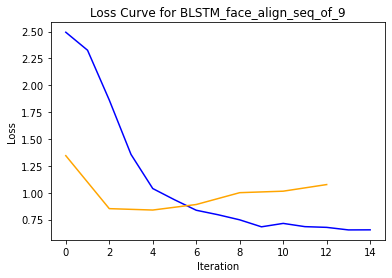

here 9
no of ratings 118
no of frames 118
error for BLSTM_face_align_seq_of_9 on test set: 242.52448613603943
weighted error for BLSTM_face_align_seq_of_9 on test set: 188.77349170269426
-----------------


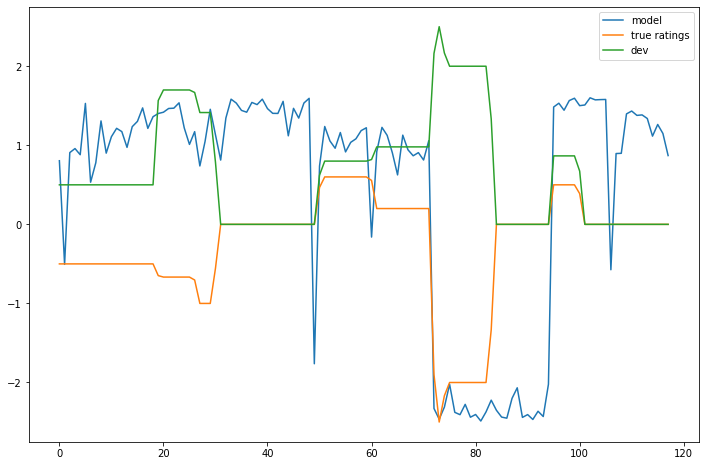

((tensor(242.5245, dtype=torch.float64),
  tensor(188.7735, dtype=torch.float64)),
 array([ 0.80475873, -0.50586975,  0.90743965,  0.95861274,  0.88079184,
         1.52952719,  0.53311539,  0.77905947,  1.30814826,  0.90079147,
         1.10844696,  1.21465182,  1.17308867,  0.97380257,  1.23538721,
         1.30220282,  1.47273469,  1.21377552,  1.3615818 ,  1.40192986,
         1.4182322 ,  1.4656049 ,  1.46930861,  1.53702736,  1.21935689,
         1.01097047,  1.17248392,  0.73872727, -5.        ,  1.04920554,
         1.45520782,  1.13254642,  0.813187  ,  1.34441674,  1.58325803,
         1.53384292,  1.44124997,  1.41863334,  1.54201531,  1.51465869,
         1.58335376,  1.46367896,  1.40415657,  1.40293717,  1.5557909 ,
         1.11974919,  1.4671905 ,  1.34405088,  1.5344137 ,  1.59394383,
        -1.76294196,  0.7377758 ,  1.23767781,  1.05503905,  0.96275103,
         1.16146982,  0.91638029,  1.03751266,  1.08220112,  1.18563974,
         1.22175169, -0.16066332,  0.9197

In [ ]:
# path= f'{content_path}/dataset/aud'
batch_size = 64

seq_len = 9
train_dataset = VisualFeatureDatasetLSTM("face", "training_unfiltered", VA=True, transform=True, align=True, frames_per_seq=seq_len, device=device)
valid_dataset = VisualFeatureDatasetLSTM("face", "validation_unfiltered", True, True, align=True, frames_per_seq=seq_len, device=device)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)
     
print(train_dataset[0][0].shape)     
seq_dim = train_dataset[0][0].shape[0]

va_padding = 1
VA=True

input_dim = (70 + va_padding)*3

output_dim = 1
hidden_dim = 128
layer_dim = 5
learning_rate = 0.00008
model_name = "BLSTM_face_align_seq_of_9"
model_type = "LSTM"
num_epochs = 100
valid_freq = 2
patience = 5
bidir=True

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

### Change the code below to try running different models:
## TODO: Also pass in bidirectional parameter and alter code for this.
model = RNNModel(model_type, input_dim, hidden_dim, layer_dim, output_dim, device, bidir=bidir)

# criterion = nn.MSELoss(reduction='sum')
# criterion = lambda out, res, std : torch.sum(2/(1+std) * (out - res.float()) ** 2)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_for_feat_datasetLSTM(model, 
                       (model_name, "face", model_type), 
                       train_loader, 
                       valid_loader, 
                       criterion='weighted_MSE', 
                       optimiser=optimiser, 
                       device=device, 
                       num_epochs=num_epochs, 
                       valid_freq=valid_freq,
                       VA=(VA, va_padding),
                       patience_threshold=patience)

gen_feat_graph_and_score(model_name, "face", model_type = model_type, VA=VA, frames_per_seq=seq_len, show_graph=True)


### Voice LSTM 

In [ ]:
execfile(f'{content_path}/API/helpers.py')
execfile(f'{content_path}/API/RNN.py')

In [ ]:
VA_available = False
batch_size = 32

path_labels = f"{content_path}/dataset/audio/opinions_audio.csv"
path_audio = f"{content_path}/dataset/audio/"

train_dataset = VocalSnippetsDatasetfromDF(path_labels, path_audio, "training", transform=True, VA=VA_available)
valid_dataset = VocalSnippetsDatasetfromDF(path_labels, path_audio, "validation", transform=True, VA=VA_available)
test_dataset = VocalSnippetsDatasetfromDF(path_labels, path_audio, "test", transform=True, VA=VA_available)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


1192
1192
1192


Epoch: 0, Iteration: 0, training loss = 100.0219
Epoch: 0, Iteration: 1, training loss = 76.4614
Epoch: 0, Iteration: 2, training loss = 67.8853
Epoch: 0, Iteration: 3, training loss = 80.0769
Epoch: 0, Iteration: 4, training loss = 57.2498
Epoch: 0, Iteration: 5, training loss = 63.6029
Epoch: 0, Iteration: 6, training loss = 51.7095
Epoch: 0, Iteration: 7, training loss = 38.9099
Epoch: 0, Iteration: 8, training loss = 34.6455
Epoch: 0, Iteration: 9, training loss = 33.4312
Epoch: 0, Iteration: 10, training loss = 43.9020
Epoch: 0, Iteration: 11, training loss = 25.3541
Epoch: 0, Iteration: 0, valid loss = 18.1013
Epoch: 0, Iteration: 1, valid loss = 2.1676
Epoch: 0, Iteration: 2, valid loss = 66.5075
Epoch: 0, Iteration: 3, valid loss = 45.5893
Epoch: 1, Iteration: 0, training loss = 38.0154
Epoch: 1, Iteration: 1, training loss = 30.6415
Epoch: 1, Iteration: 2, training loss = 36.3166
Epoch: 1, Iteration: 3, training loss = 45.9819
Epoch: 1, Iteration: 4, training loss = 25.9863
Ep

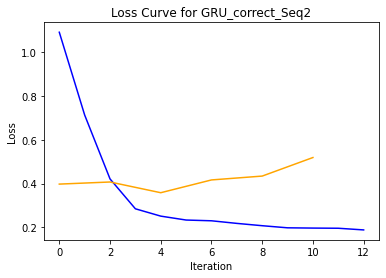


Weigthed score for GRU_voice_va_short_seq for voice after smoothening: 0.3646802564027075
CCC score for GRU_voice_va_short_seq for voice on test set: -0.19584423315962007


MSE error for GRU_voice_va_short_seq on test set: 272.5621643066406
weighted MSE error for GRU_voice_va_short_seq on test set: 188.91484330974515
55
55


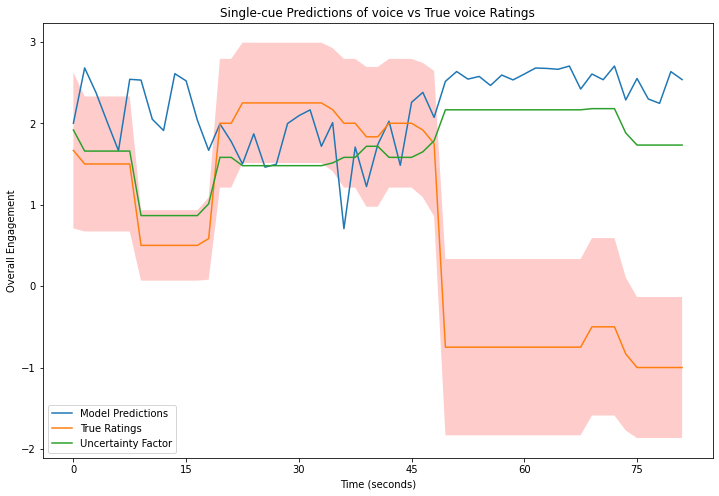

In [ ]:
output_dim = 1
hidden_dim = 100
layer_dim = 2
learning_rate = 0.0003
model_name = "GRU_correct_Seq2"
model_type = "GRU_Att"
num_epochs = 50
valid_freq = 2
patience = 3
seq_dim, input_dim = train_dataset[0][0].shape
device = "cuda" if torch.cuda.is_available() else "cpu"
bidir=True

model = GRUModel_Att(input_dim, hidden_dim, layer_dim, output_dim, device, dropout_prob=0.2, bidir=bidir)
      
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_for_audio_dataset(model, model_name, train_loader, valid_loader, 'weighted_MSE', optimiser, device, num_epochs, valid_freq, VA=False, patience_threshold=patience)
eval_single_cue("GRU_voice_va_short_seq", 'voice', test_dataset, smoothen=False)

# gen_voice_graph_and_score(model_name, model_type, VA=False)


Weigthed score for GRU_voice_va_short_seq for voice after smoothening: 0.48573644881711164
CCC score for GRU_voice_va_short_seq for voice on test set: -0.2636268607533711


MSE error for GRU_voice_va_short_seq on test set: 1342.113037109375
weighted MSE error for GRU_voice_va_short_seq on test set: 836.7508256047008
377
377


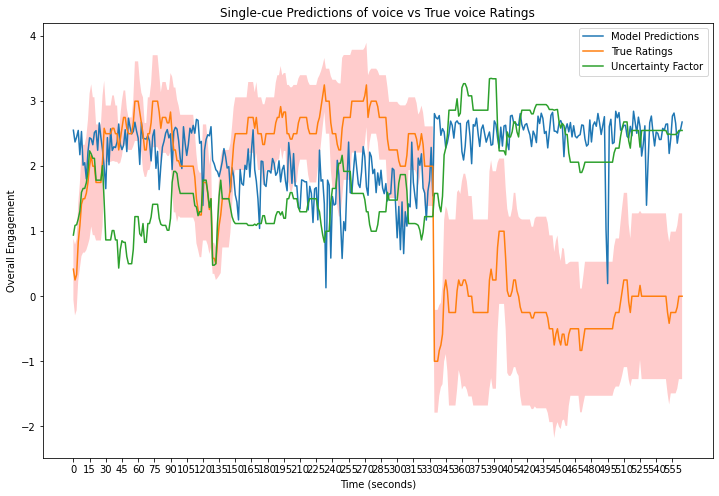

In [ ]:
eval_single_cue("GRU_voice_va_short_seq", 'voice', train_dataset, smoothen=False)

In [ ]:
seq_dim, input_dim = train_dataset[0][0].shape
print(seq_dim)
print(input_dim)

output_dim = 1
hidden_dim = 64
layer_dim = 5
learning_rate = 0.001
model_name = "GRU_voice1_std"
model_type = "GRU"
num_epochs = 50
valid_freq = 2
patience = 3

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

### Change the code below to try running different models:
## TODO: Also pass in bidirectional parameter and alter code for this.
model = RNNModel(model_type, input_dim, hidden_dim, layer_dim, output_dim, device)

# criterion = nn.MSELoss(reduction='sum')

# criterion = lambda out, res, std : torch.sum(2/(1+std) * (out - res.float()) ** 2)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)


#### Experiment

In [ ]:
path= f'{content_path}/dataset/aud_3s'
VA_available = False
batch_size = 64

train_dataset = VocalSnippetsDataset(path, "training", True, VA=VA_available)

valid_dataset = VocalSnippetsDataset(path, "validation", True, VA=VA_available)

test_dataset = VocalSnippetsDataset(path, "test", True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

output_dim = 1
hidden_dim = 70
layer_dim = 2
learning_rate = 0.0005
model_name = "GRU_voice_va_short_seq_attempt"
model_type = "GRU_Att"
num_epochs = 50
valid_freq = 2
patience = 3
seq_dim, input_dim = train_dataset[0][0].shape
device = "cuda" if torch.cuda.is_available() else "cpu"
bidir=True

model = GRUModel_Att(input_dim, hidden_dim, layer_dim, output_dim, device, dropout_prob=0.2, bidir=bidir)
      
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_for_audio_dataset(model, model_name, train_loader, valid_loader, 'weighted_MSE', optimiser, device, num_epochs, valid_freq, VA=True, patience_threshold=patience)
gen_voice_graph_and_score(model_name, model_type, VA=False)

In [ ]:
path= f'{content_path}/dataset/aud_3s'
VA_available = False
batch_size = 64

train_dataset = VocalSnippetsDataset(path, "training", True, VA=VA_available)

valid_dataset = VocalSnippetsDataset(path, "validation", True, VA=VA_available)

test_dataset = VocalSnippetsDataset(path, "test", True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

output_dim = 1
hidden_dim = 64
layer_dim = 2
learning_rate = 0.0005
model_name = "GRU_voice_va_short_seq"
model_type = "GRU_Att"
num_epochs = 50
valid_freq = 3
patience = 3
seq_dim, input_dim = train_dataset[0][0].shape
device = "cuda" if torch.cuda.is_available() else "cpu"
bidir=True

model = GRUModel_Att(input_dim, hidden_dim, layer_dim, output_dim, device, dropout_prob=0.2, bidir=bidir)
      
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_for_audio_dataset(model, model_name, train_loader, valid_loader, 'weighted_MSE', optimiser, device, num_epochs, valid_freq, VA=True, patience_threshold=patience)
gen_voice_graph_and_score(model_name, model_type, VA=False)

(116,)
118
no of ratings 116
no of video clips 115
error for GRU_voice_va_short_seq on test set: 237.68594278065612
weighted error for GRU_voice_va_short_seq on test set: 195.68987814886074


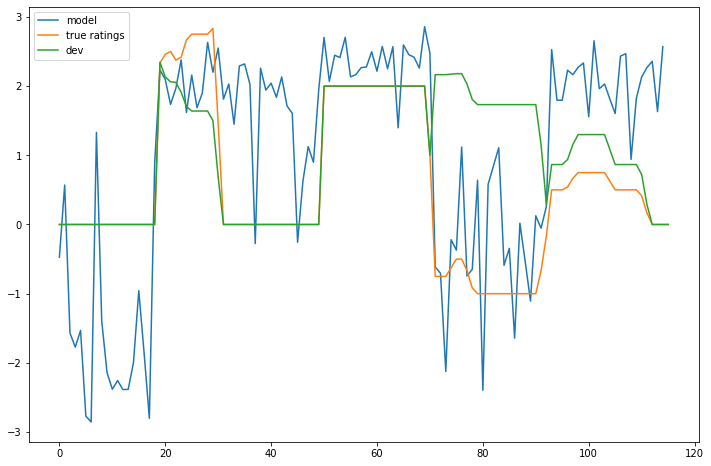

((237.68594278065612, 195.68987814886074),
 [-0.4735550582408905,
  0.570106029510498,
  -1.5690100193023682,
  -1.7717195749282837,
  -1.5306562185287476,
  -2.7679944038391113,
  -2.854525566101074,
  1.330424427986145,
  -1.3951793909072876,
  -2.1402933597564697,
  -2.3803961277008057,
  -2.2550296783447266,
  -2.385387659072876,
  -2.382345199584961,
  -1.9934329986572266,
  -0.9565272927284241,
  -1.8517807722091675,
  -2.8009986877441406,
  0.8823801279067993,
  2.2342417240142822,
  2.095534086227417,
  1.735073447227478,
  1.9659943580627441,
  2.379282236099243,
  1.6177841424942017,
  2.158811330795288,
  1.6884734630584717,
  1.897639513015747,
  2.6314127445220947,
  2.2003726959228516,
  2.5488078594207764,
  1.8111677169799805,
  2.0291833877563477,
  1.448809266090393,
  2.2893965244293213,
  2.320446014404297,
  2.0232961177825928,
  -0.276277631521225,
  2.2580764293670654,
  1.9420762062072754,
  2.041463851928711,
  1.8375449180603027,
  2.1316463947296143,
  1.7137

In [ ]:
gen_voice_graph_and_score(model_name, model_type, VA=False)


In [ ]:
train_for_audio_dataset(model, model_name, train_loader, valid_loader, 'weighted_MSE', optimiser, device, num_epochs, valid_freq, patience)

In [ ]:
output_dim = 1
hidden_dim = 64
layer_dim = 5
learning_rate = 0.001
model_name = "GRU_voice_va"
model_type = "GRU"
num_epochs = 50
valid_freq = 2
patience = 3

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = RNNModel(model_type, input_dim, hidden_dim, layer_dim, output_dim, device)

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_for_audio_dataset(model, model_name, train_loader, valid_loader, 'weighted_MSE', optimiser, device, num_epochs, valid_freq, VA=True, patience_threshold=patience)

In [ ]:
#  https://github.com/tyiannak/pyAudioAnalysis/tree/master/pyAudioAnalysis 

!pip install pyAudioAnalysis
!pip install eyed3
!pip install pydub

import eyed3
import pydub
from pyAudioAnalysis import audioTrainTest as aT

### Face LSTM


#### Tests


load from dataframe - raw frames
torch.Size([7492])
torch.Size([7492])
torch.Size([7492, 1, 70, 3])
torch.Size([833, 9, 1, 70, 3])
good 55
n_good 446
n_bad 203
bad 129

here - number of sequences for face
torch.Size([1201, 9, 1, 70, 3])
torch.Size([1201])

load from dataframe - raw frames
torch.Size([2140])
torch.Size([2140])
torch.Size([2140, 1, 70, 3])
torch.Size([238, 9, 1, 70, 3])

here - number of sequences for face
torch.Size([238, 9, 1, 70, 3])
torch.Size([238])

load from dataframe - raw frames
torch.Size([1072])
torch.Size([1072])
torch.Size([1072, 1, 70, 3])
torch.Size([120, 9, 1, 70, 3])

here - number of sequences for face
torch.Size([120, 9, 1, 70, 3])
torch.Size([120])
torch.Size([9, 210])
cuda
Epoch: 0, Iteration: 0, training loss = 167.4291
Epoch: 0, Iteration: 10, training loss = 169.8609
Epoch: 10, Iteration: 0, training loss = 96.3523
Epoch: 10, Iteration: 10, training loss = 118.2047
Epoch: 20, Iteration: 0, training loss = 113.3890
Epoch: 20, Iteration: 10, traini

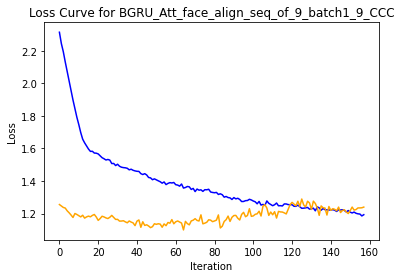


Weigthed score for BGRU_Att_face_align_seq_of_9_batch1_9_CCC for face after smoothening: 0.5204226591056696
CCC score for BGRU_Att_face_align_seq_of_9_batch1_9_CCC for face on test set: 0.6406804385576069


MSE error for BGRU_Att_face_align_seq_of_9_batch1_9_CCC on test set: 139.21157836914062
weighted MSE error for BGRU_Att_face_align_seq_of_9_batch1_9_CCC on test set: 141.29071471573286
120
120


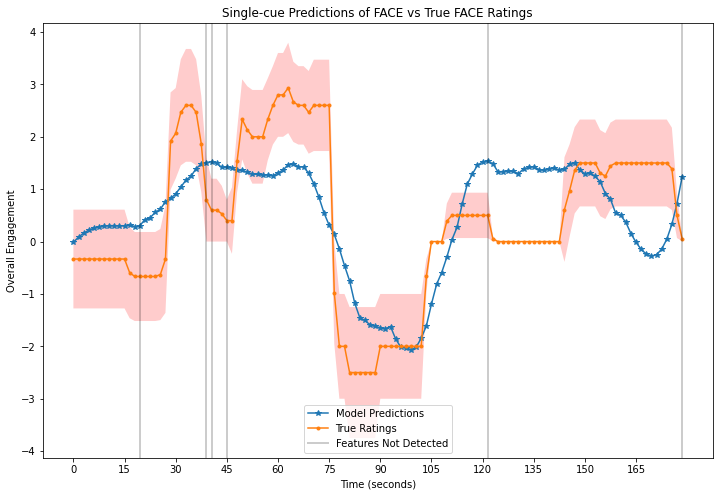


torch.Size([8])
torch.Size([8])
CCC score for BGRU_Att_face_align_seq_of_9_batch1_9_CCC for face on test set: 0


MSE error for BGRU_Att_face_align_seq_of_9_batch1_9_CCC on test set: 6.0625
weighted MSE error for BGRU_Att_face_align_seq_of_9_batch1_9_CCC on test set: 0
8
120


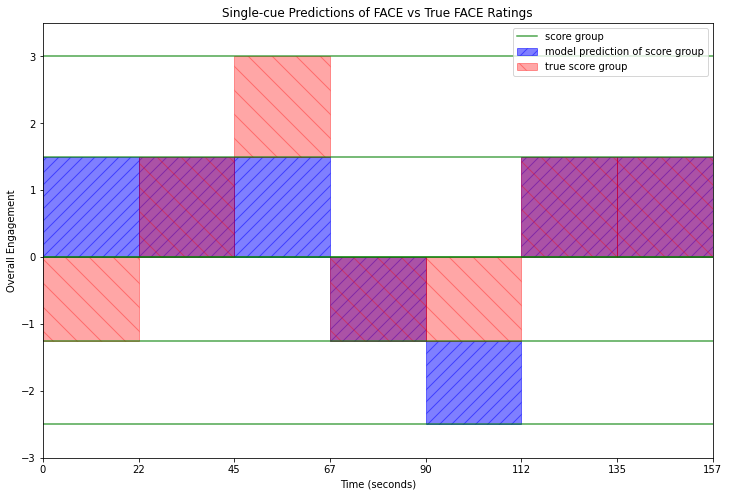

In [ ]:
execfile(f'{content_path}/API/helpers.py')
execfile(f'{content_path}/API/RNN.py')

# Attention
batch_size = 64

seq_len = 9
va_padding = 0
VA=False

path_labels=f'{content_path}/video_features/opinions_visual.csv'
path_frames=f'{content_path}/video_features/video_b1_'

train_dataset = VisualFeatureDatasetLSTMfromDF("face", "training", path_frames, path_labels, 
                                              VA=False, augment=True, transform=True, 
                                              align=True, frames_per_seq=seq_len, device=device)

valid_dataset = VisualFeatureDatasetLSTMfromDF("face", "validation", path_frames, path_labels, 
                                              VA=False, augment=False, transform=True , 
                                              align=True, frames_per_seq=seq_len, device=device)

test_dataset = VisualFeatureDatasetLSTMfromDF("face", "test", path_frames, path_labels, 
                                              VA=False, augment=False, transform=True , 
                                              align=True, frames_per_seq=seq_len, device=device)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

# train_dataset = VisualFeatureDatasetLSTM("face", "training_unfiltered", VA=VA, transform=True, align=True, frames_per_seq=seq_len, device=device)
# valid_dataset = VisualFeatureDatasetLSTM("face", "validation_unfiltered", VA, True, align=True, frames_per_seq=seq_len, device=device)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

print(train_dataset[0][0].shape)     
seq_dim = train_dataset[0][0].shape[0]

input_dim = (70 + va_padding)*3

output_dim = 1
# hidden_dim = 64
hidden_dim = 45
layer_dim = 2
learning_rate = 0.000065
model_name = "BGRU_Att_face_align_seq_of_9_batch1_9_CCC"
model_type = "GRU_Att"
num_epochs = 300
valid_freq = 1
patience = 5
bidir=True

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


model = GRUModel_Att(input_dim, hidden_dim, layer_dim, output_dim, device, dropout_prob=0.2, bidir=bidir)
      
# criterion = nn.MSELoss(reduction='sum')
# criterion = lambda out, res, std : torch.sum(2/(1+std) * (out - res.float()) ** 2)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_for_feat_datasetLSTM(model, 
                       (model_name, "face", model_type), 
                       train_loader, 
                       valid_loader, 
                       criterion='CCC', 
                       optimiser=optimiser, 
                       device=device, 
                       num_epochs=num_epochs, 
                       valid_freq=valid_freq,
                       VA=(VA, va_padding),
                       patience_threshold=patience)

eval_single_cue(model_name, 'face', test_dataset, smoothen=True)
eval_single_cue_with_score_classes(model_name, 'face', test_dataset, smoothen=True)


load from dataframe - raw frames
torch.Size([7492])
torch.Size([7492])
torch.Size([7492, 1, 70, 3])
torch.Size([833, 9, 1, 70, 3])
good 55
n_good 446
n_bad 203
bad 129

here - number of sequences for face
torch.Size([1201, 9, 1, 70, 3])
torch.Size([1201])

load from dataframe - raw frames
torch.Size([2140])
torch.Size([2140])
torch.Size([2140, 1, 70, 3])
torch.Size([238, 9, 1, 70, 3])

here - number of sequences for face
torch.Size([238, 9, 1, 70, 3])
torch.Size([238])

load from dataframe - raw frames
torch.Size([1072])
torch.Size([1072])
torch.Size([1072, 1, 70, 3])
torch.Size([120, 9, 1, 70, 3])

here - number of sequences for face
torch.Size([120, 9, 1, 70, 3])
torch.Size([120])
torch.Size([9, 210])
cuda
Epoch: 0, Iteration: 0, training loss = 198.5163
Epoch: 0, Iteration: 10, training loss = 144.5515
Epoch: 10, Iteration: 0, training loss = 148.6286
Epoch: 10, Iteration: 10, training loss = 108.9868
Epoch: 20, Iteration: 0, training loss = 100.0606
Epoch: 20, Iteration: 10, train

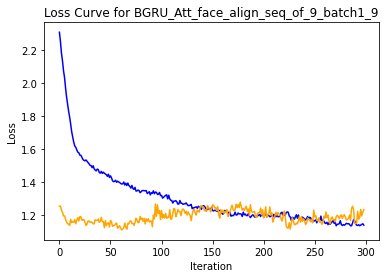


Weigthed score for BGRU_Att_face_align_seq_of_9_batch1_9 for face after smoothening: 0.5296043167721056
CCC score for BGRU_Att_face_align_seq_of_9_batch1_9 for face on test set: 0.5717600194337612


MSE error for BGRU_Att_face_align_seq_of_9_batch1_9 on test set: 152.63388061523438
weighted MSE error for BGRU_Att_face_align_seq_of_9_batch1_9 on test set: 143.40820769187894
120
120


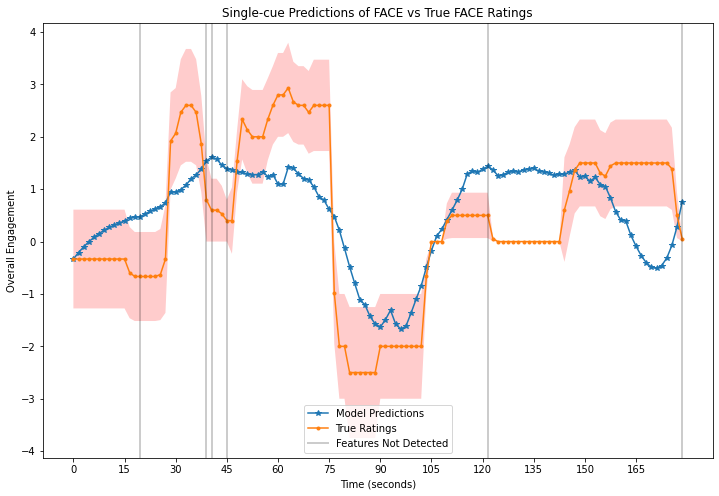


torch.Size([8])
torch.Size([8])
CCC score for BGRU_Att_face_align_seq_of_9_batch1_9 for face on test set: 0


MSE error for BGRU_Att_face_align_seq_of_9_batch1_9 on test set: 4.5
weighted MSE error for BGRU_Att_face_align_seq_of_9_batch1_9 on test set: 0
8
120


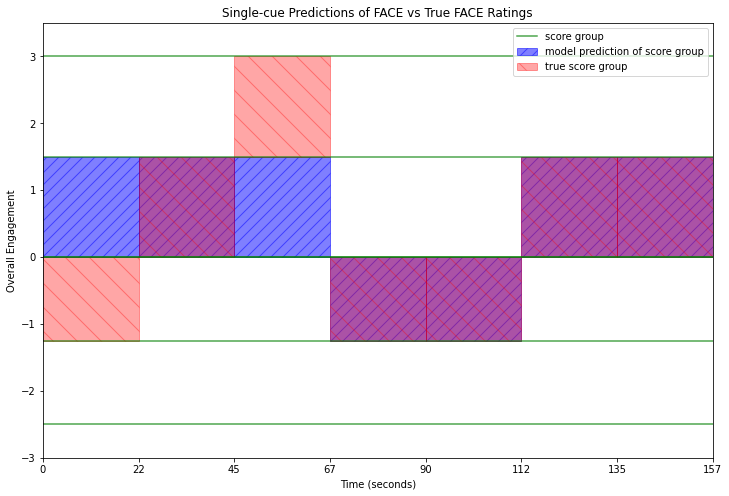

In [ ]:
execfile(f'{content_path}/API/helpers.py')
execfile(f'{content_path}/API/RNN.py')

# Attention
batch_size = 64

seq_len = 9
va_padding = 0
VA=False

path_labels=f'{content_path}/video_features/opinions_visual.csv'
path_frames=f'{content_path}/video_features/video_b1_'

train_dataset = VisualFeatureDatasetLSTMfromDF("face", "training", path_frames, path_labels, 
                                              VA=False, augment=True, transform=True, 
                                              align=True, frames_per_seq=seq_len, device=device)

valid_dataset = VisualFeatureDatasetLSTMfromDF("face", "validation", path_frames, path_labels, 
                                              VA=False, augment=False, transform=True , 
                                              align=True, frames_per_seq=seq_len, device=device)

test_dataset = VisualFeatureDatasetLSTMfromDF("face", "test", path_frames, path_labels, 
                                              VA=False, augment=False, transform=True , 
                                              align=True, frames_per_seq=seq_len, device=device)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

# train_dataset = VisualFeatureDatasetLSTM("face", "training_unfiltered", VA=VA, transform=True, align=True, frames_per_seq=seq_len, device=device)
# valid_dataset = VisualFeatureDatasetLSTM("face", "validation_unfiltered", VA, True, align=True, frames_per_seq=seq_len, device=device)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

print(train_dataset[0][0].shape)     
seq_dim = train_dataset[0][0].shape[0]

input_dim = (70 + va_padding)*3

output_dim = 1
# hidden_dim = 64
hidden_dim = 45
layer_dim = 2
learning_rate = 0.000065
model_name = "BGRU_Att_face_align_seq_of_9_batch1_9"
model_type = "GRU_Att"
num_epochs = 300
valid_freq = 1
patience = 5
bidir=True

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


model = GRUModel_Att(input_dim, hidden_dim, layer_dim, output_dim, device, dropout_prob=0.2, bidir=bidir)
      
# criterion = nn.MSELoss(reduction='sum')
# criterion = lambda out, res, std : torch.sum(2/(1+std) * (out - res.float()) ** 2)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_for_feat_datasetLSTM(model, 
                       (model_name, "face", model_type), 
                       train_loader, 
                       valid_loader, 
                       criterion='weighted_MSE', 
                       optimiser=optimiser, 
                       device=device, 
                       num_epochs=num_epochs, 
                       valid_freq=valid_freq,
                       VA=(VA, va_padding),
                       patience_threshold=patience)

eval_single_cue(model_name, 'face', test_dataset, smoothen=True)
eval_single_cue_with_score_classes(model_name, 'face', test_dataset, smoothen=True)

torch.Size([9, 210])
cuda

Weigthed score for BGRU_Att_face_align_seq_of_9 for face after smoothening: 0.6819178848631295
CCC score for BGRU_Att_face_align_seq_of_9 for face on test set: 0.1339958253096369


MSE error for BGRU_Att_face_align_seq_of_9 on test set: 83.37149047851562
weighted MSE error for BGRU_Att_face_align_seq_of_9 on test set: 75.60473331066086
121
121


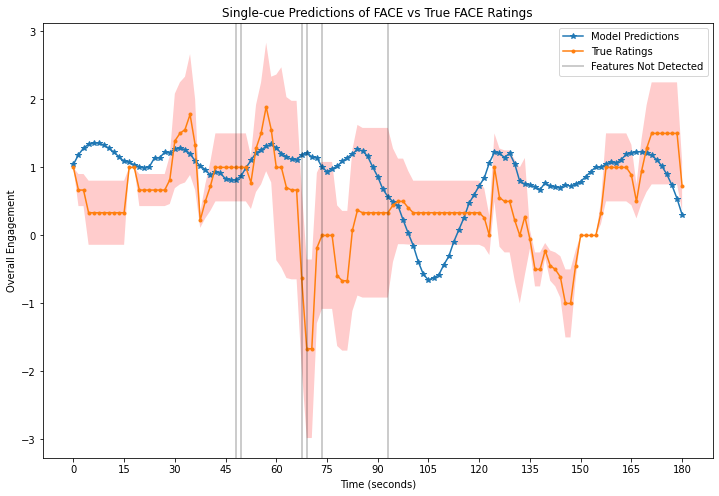


torch.Size([9])
torch.Size([9])
CCC score for BGRU_Att_face_align_seq_of_9 for face on test set: 0


MSE error for BGRU_Att_face_align_seq_of_9 on test set: 6.75
weighted MSE error for BGRU_Att_face_align_seq_of_9 on test set: 0
9
121


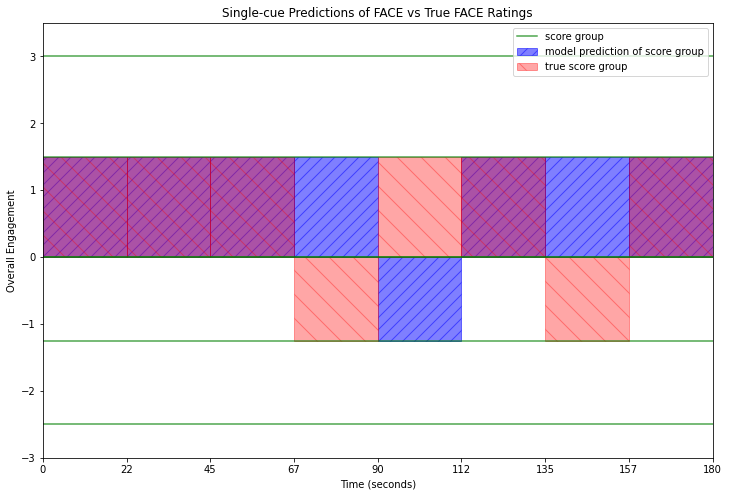

In [ ]:
# Attention
batch_size = 64

seq_len = 9
va_padding = 0
VA=False

train_dataset = VisualFeatureDatasetLSTM("face", "training_unfiltered", VA=VA, transform=True, align=True, frames_per_seq=seq_len, device=device)
valid_dataset = VisualFeatureDatasetLSTM("face", "validation_unfiltered", VA=VA, transform=True, align=True, frames_per_seq=seq_len, device=device)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)
     
print(train_dataset[0][0].shape)     
seq_dim = train_dataset[0][0].shape[0]

input_dim = (70 + va_padding)*3

output_dim = 1
# hidden_dim = 64
hidden_dim = 32
layer_dim = 3
learning_rate = 0.00008
model_name = "BGRU_Att_face_align_seq_of_9"
model_type = "GRU_Att"
num_epochs = 100
valid_freq = 2
patience = 3
bidir=True

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


# model = GRUModel_Att(input_dim, hidden_dim, layer_dim, output_dim, device, dropout_prob=0.2, bidir=bidir)
      
# # criterion = nn.MSELoss(reduction='sum')
# # criterion = lambda out, res, std : torch.sum(2/(1+std) * (out - res.float()) ** 2)
# optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train_for_feat_datasetLSTM(model, 
#                        (model_name, "face", model_type), 
#                        train_loader, 
#                        valid_loader, 
#                        criterion='weighted_MSE', 
#                        optimiser=optimiser, 
#                        device=device, 
#                        num_epochs=num_epochs, 
#                        valid_freq=valid_freq,
#                        VA=(VA, va_padding),
#                        patience_threshold=patience)

# gen_feat_graph_and_score(model_name, "face", model_type = model_type, VA=VA, frames_per_seq=seq_len, show_graph=True)
eval_single_cue(model_name, 'face', test_dataset, smoothen=True)
eval_single_cue_with_score_classes(model_name, 'face', test_dataset, smoothen=True)

In [ ]:
# Attention
batch_size = 64

seq_len = 9
va_padding = 0
VA=False

train_dataset = VisualFeatureDatasetLSTM("face", "training_unfiltered", VA=VA, transform=True, align=True, frames_per_seq=seq_len, device=device)
valid_dataset = VisualFeatureDatasetLSTM("face", "validation_unfiltered", VA, True, align=True, frames_per_seq=seq_len, device=device)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)
     
print(train_dataset[0][0].shape)     
seq_dim = train_dataset[0][0].shape[0]

input_dim = (70 + va_padding)*3

output_dim = 1
# hidden_dim = 64
hidden_dim = 32
layer_dim = 3
learning_rate = 0.00008
model_name = "BGRU_Att_test"
model_type = "GRU_Att"
num_epochs = 2
valid_freq = 2
patience = 3
bidir=True

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


model = GRUModel_Att(input_dim, hidden_dim, layer_dim, output_dim, device, dropout_prob=0.2, bidir=bidir)
      
# criterion = nn.MSELoss(reduction='sum')
# criterion = lambda out, res, std : torch.sum(2/(1+std) * (out - res.float()) ** 2)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_for_feat_datasetLSTM(model, 
                       (model_name, "face", model_type), 
                       train_loader, 
                       valid_loader, 
                       criterion='weighted_MSE', 
                       optimiser=optimiser, 
                       device=device, 
                       num_epochs=num_epochs, 
                       valid_freq=valid_freq,
                       VA=(VA, va_padding),
                       patience_threshold=patience)

gen_feat_graph_and_score(model_name, "face", model_type = model_type, VA=VA, frames_per_seq=seq_len, show_graph=True)


#### Experiments

In [ ]:
def train_for_feat_dataset(network, name, loader_train, loader_val, criterion, optimiser, device="cpu", num_epochs=10, valid_freq=1, VA=False, patience_threshold = 5):
      (name, feat, model_type) = name
      network.to(device)

      losses = []
      losses_validation = []
      iterations = []
      patience = patience_threshold

      for epoch in range(num_epochs):
        network.train()
        loss_train = 0
        train_total = 0
        ############################### Loop over training iterations  
        for iter, (input, labels, stds) in enumerate(loader_train):
          optimiser.zero_grad()
          feature = Variable(input.to(device))
          labels = Variable(labels.to(device))
          stds = Variable(stds.to(device))
 
          network_prediction = network(feature.float()).squeeze(-1)
          
          if criterion == 'MSE':
            loss = torch.nn.MSELoss(reduction='sum')(network_prediction.float(), labels.float())
          else:
            loss = torch.sum(2/(1+ stds) * (network_prediction - labels) ** 2)

          loss.backward()
          loss_value = loss.item()

          train_total += labels.size(0)
          loss_train += loss_value

          optimiser.step()
          if epoch % 10 == 0 and iter % 20 == 0: 
            print('Epoch: %d, Iteration: %d, training loss = %.4f' % (epoch, iter, loss_value))         

        losses.append(loss_train/train_total)
        iterations.append(epoch)

        ###################### check performance on validation set
        if epoch % valid_freq == 0:
          network.eval()
          v_loss = 0
          v_total = 0
          with torch.no_grad():
            for v_iter, (input, v_labels, v_stds) in enumerate(loader_val):

              v_feat = Variable(input.to(device))
              v_labels = Variable(v_labels.to(device))

              v_outputs = network(v_feat).squeeze(-1)
              v_stds = Variable(v_stds.to(device))

              v_total += v_labels.size(0)
              # loss = criterion(v_outputs.float(), v_labels.float())
              if criterion == 'MSE':
                loss = torch.nn.MSELoss(reduction='sum')(v_outputs.float(), v_labels.float())
              else:
                loss = torch.sum(2/(1+ v_stds) * (v_outputs - v_labels) ** 2)

              v_loss_value = loss.item()
              v_loss += v_loss_value

              if iter % 20 == 0: 
                print('Epoch: %d, Iteration: %d, valid loss = %.4f' % (epoch, v_iter, v_loss_value))         
              
          losses_validation.append(v_loss/v_total)

        # TODO: possibly rethink early stopping code here and check how it works.
        if epoch > 10 and (losses_validation[int(epoch / valid_freq) - 1] < losses_validation[int(epoch / valid_freq)]):
            patience -= 1
        else:
            patience = patience_threshold

        if patience == 0:
            break

      plot_loss_iters(name, content_path, valid_freq, losses, losses_validation)
      torch.save(network, f"{content_path}/models/{name}")
      gen_feat_graph_and_score(name, feat, model_type = model_type, VA=VA, show_graph=True)


cuda
Epoch: 0, Iteration: 0, training loss = 158.0479
Epoch: 0, Iteration: 20, training loss = 138.7172
Epoch: 0, Iteration: 40, training loss = 182.2883
Epoch: 0, Iteration: 60, training loss = 129.4575
Epoch: 0, Iteration: 80, training loss = 142.1012
Epoch: 10, Iteration: 0, training loss = 99.3650
Epoch: 10, Iteration: 20, training loss = 111.7342
Epoch: 10, Iteration: 40, training loss = 139.3652
Epoch: 10, Iteration: 60, training loss = 161.2144
Epoch: 10, Iteration: 80, training loss = 127.4048
Epoch: 20, Iteration: 0, training loss = 112.3052
Epoch: 20, Iteration: 20, training loss = 95.4238
Epoch: 20, Iteration: 40, training loss = 112.0909
Epoch: 20, Iteration: 60, training loss = 116.1348
Epoch: 20, Iteration: 80, training loss = 133.0669
Epoch: 30, Iteration: 0, training loss = 101.9267
Epoch: 30, Iteration: 20, training loss = 107.9475
Epoch: 30, Iteration: 40, training loss = 98.4119
Epoch: 30, Iteration: 60, training loss = 103.3208
Epoch: 30, Iteration: 80, training los

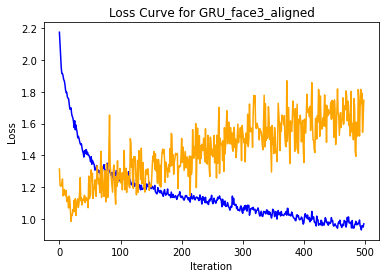

In [ ]:
seq_dim, input_dim = train_dataset[0][0].shape

output_dim = 1
hidden_dim = 64
layer_dim = 2
learning_rate = 0.0005
learning_rate = 0.0001
model_name = "GRU_face4_aligned"
model_type = "GRU"
num_epochs = 50
valid_freq = 5
patience = 5

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

### Change the code below to try running different models:
## TODO: Also pass in bidirectional parameter and alter code for this.
model = RNNModel(model_type, input_dim, hidden_dim, layer_dim, output_dim, device)

# criterion = nn.MSELoss(reduction='sum')

# criterion = lambda out, res, std : torch.sum(2/(1+std) * (out - res.float()) ** 2)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_for_feat_dataset(model, 
                       model_name, 
                       train_loader, 
                       valid_loader, 
                       criterion='weighted_MSE', 
                       optimiser=optimiser, 
                       device=device, 
                       num_epochs=num_epochs, 
                       valid_freq=valid_freq,
                       VA=True,
                       patience=patience)

cuda
Epoch: 0, Iteration: 0, training loss = 179.3006
Epoch: 0, Iteration: 20, training loss = 147.3824
Epoch: 0, Iteration: 40, training loss = 173.2258
Epoch: 0, Iteration: 60, training loss = 137.3612
Epoch: 0, Iteration: 80, training loss = 165.1259
Epoch: 10, Iteration: 0, training loss = 96.8388
Epoch: 10, Iteration: 20, training loss = 79.5676
Epoch: 10, Iteration: 40, training loss = 101.6895
Epoch: 10, Iteration: 60, training loss = 95.5882
Epoch: 10, Iteration: 80, training loss = 91.8057
Epoch: 20, Iteration: 0, training loss = 72.0323
Epoch: 20, Iteration: 20, training loss = 79.7727
Epoch: 20, Iteration: 40, training loss = 58.5444
Epoch: 20, Iteration: 60, training loss = 77.9447
Epoch: 20, Iteration: 80, training loss = 72.8512
Epoch: 30, Iteration: 0, training loss = 71.8694
Epoch: 30, Iteration: 20, training loss = 51.8841
Epoch: 30, Iteration: 40, training loss = 46.3558
Epoch: 30, Iteration: 60, training loss = 68.5872
Epoch: 30, Iteration: 80, training loss = 105.46

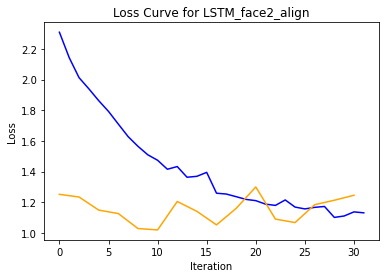

no of ratings 928
no of frames 928
error for LSTM_face2_align on test set: 1680.3355020913748
weighted error for LSTM_face2_align on test set: 1201.68178386119
-----------------


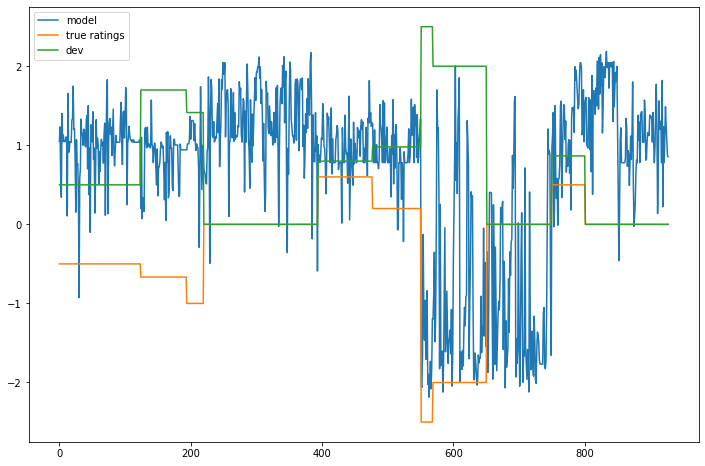

In [ ]:
# path= f'{content_path}/dataset/aud'
batch_size = 64

train_dataset = VisualFeatureDataset("face", "training", VA=True, transform=True, align=True, device=device)
valid_dataset = VisualFeatureDataset("face", "validation", True, True, align=True, device=device)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)
     
seq_dim, input_dim = train_dataset[0][0].shape

output_dim = 1
hidden_dim = 64
layer_dim = 2
learning_rate = 0.00008
model_name = "LSTM_face2_align"
model_type = "LSTM"
num_epochs = 100
valid_freq = 2
patience = 5
bidir=True

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

### Change the code below to try running different models:
## TODO: Also pass in bidirectional parameter and alter code for this.
model = RNNModel(model_type, input_dim, hidden_dim, layer_dim, output_dim, device)

# criterion = nn.MSELoss(reduction='sum')
# criterion = lambda out, res, std : torch.sum(2/(1+std) * (out - res.float()) ** 2)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_for_feat_dataset(model, 
                       (model_name, "face", model_type), 
                       train_loader, 
                       valid_loader, 
                       criterion='weighted_MSE', 
                       optimiser=optimiser, 
                       device=device, 
                       num_epochs=num_epochs, 
                       valid_freq=valid_freq,
                       VA=True,
                       patience_threshold=patience)

#### Good Models

torch.Size([9, 213])
cuda
Epoch: 0, Iteration: 0, training loss = 161.1638
Epoch: 10, Iteration: 0, training loss = 117.4593
Epoch: 20, Iteration: 0, training loss = 74.8920


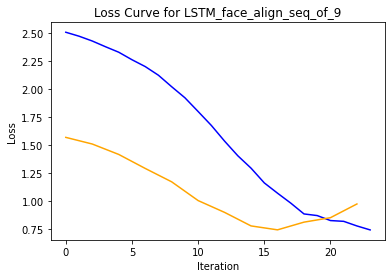

TypeError: ignored

In [ ]:
# path= f'{content_path}/dataset/aud'
batch_size = 64

seq_len = 9
train_dataset = VisualFeatureDatasetLSTM("face", "training_unfiltered", VA=True, transform=True, align=True, frames_per_seq=seq_len, device=device)
valid_dataset = VisualFeatureDatasetLSTM("face", "validation_unfiltered", True, True, align=True, frames_per_seq=seq_len, device=device)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)
     
print(train_dataset[0][0].shape)     
seq_dim = train_dataset[0][0].shape[0]

va_padding = 1
VA=True

input_dim = (70 + va_padding)*3

output_dim = 1
hidden_dim = 64
layer_dim = 2
learning_rate = 0.00008
model_name = "LSTM_face_align_seq_of_9"
model_type = "LSTM"
num_epochs = 100
valid_freq = 2
patience = 5
bidir=True

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

### Change the code below to try running different models:
## TODO: Also pass in bidirectional parameter and alter code for this.
model = RNNModel(model_type, input_dim, hidden_dim, layer_dim, output_dim, device)

# criterion = nn.MSELoss(reduction='sum')
# criterion = lambda out, res, std : torch.sum(2/(1+std) * (out - res.float()) ** 2)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_for_feat_datasetLSTM(model, 
                       (model_name, "face", model_type), 
                       train_loader, 
                       valid_loader, 
                       criterion='weighted_MSE', 
                       optimiser=optimiser, 
                       device=device, 
                       num_epochs=num_epochs, 
                       valid_freq=valid_freq,
                       VA=(VA, va_padding),
                       patience_threshold=patience)

gen_feat_graph_and_score(model_name, "face", model_type = model_type, VA=VA, frames_per_seq=seq_len, show_graph=True)


no of ratings 118
no of frames 118
error for LSTM_face_align_seq_of_9 on test set: 228.0698320157229
weighted error for LSTM_face_align_seq_of_9 on test set: 165.1841785698271
-----------------


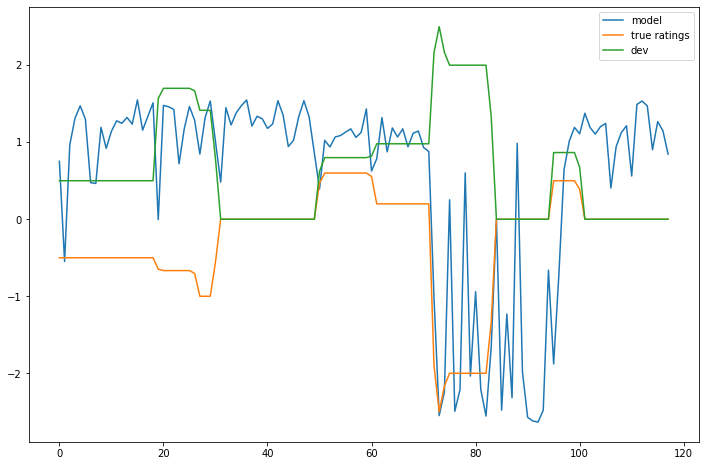

((tensor(228.0698, dtype=torch.float64),
  tensor(165.1842, dtype=torch.float64)),
 array([ 7.52198219e-01, -5.48940659e-01,  9.66107607e-01,  1.31151390e+00,
         1.47263885e+00,  1.29828739e+00,  4.74908888e-01,  4.64691043e-01,
         1.19314742e+00,  9.19951320e-01,  1.14204884e+00,  1.27827668e+00,
         1.24568057e+00,  1.32182026e+00,  1.23519313e+00,  1.54951167e+00,
         1.15692306e+00,  1.33507109e+00,  1.51143706e+00, -5.00615686e-03,
         1.47809041e+00,  1.45998216e+00,  1.42484987e+00,  7.20697522e-01,
         1.17533004e+00,  1.46358263e+00,  1.28441620e+00,  8.45953345e-01,
        -5.00000000e+00,  1.31511819e+00,  1.53508854e+00,  1.00932395e+00,
         4.81972694e-01,  1.44945478e+00,  1.22385371e+00,  1.38292861e+00,
         1.47660732e+00,  1.54773033e+00,  1.20971000e+00,  1.33689022e+00,
         1.30343199e+00,  1.17977071e+00,  1.23684478e+00,  1.53864121e+00,
         1.35362315e+00,  9.43773985e-01,  1.02485120e+00,  1.33008015e+00,
     

In [ ]:
gen_feat_graph_and_score(model_name, "face", model_type = model_type, VA=VA, frames_per_seq=seq_len, show_graph=True)


no of ratings 89
no of frames 89
error for LSTM_face4_align_seq on test set: 170.68267775305384
weighted error for LSTM_face4_align_seq on test set: 127.07215607075912
-----------------


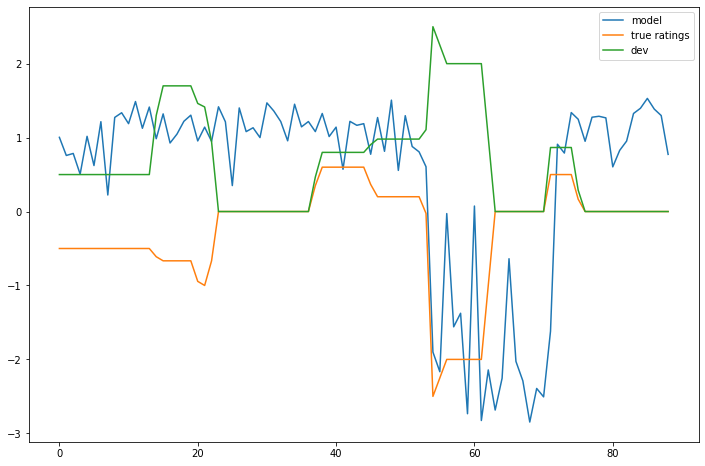

((tensor(170.6827, dtype=torch.float64),
  tensor(127.0722, dtype=torch.float64)),
 array([ 1.00338876,  0.75822175,  0.78558022,  0.5055564 ,  1.01715457,
         0.62205428,  1.21508253,  0.22368416,  1.27281427,  1.33591557,
         1.18856418,  1.48778713,  1.12597489,  1.41300726,  0.98483884,
         1.32059884,  0.92717451,  1.04735506,  1.22065341,  1.30325902,
         0.95488608, -5.        ,  1.14149797,  0.94949943,  1.41645741,
         1.2133882 ,  0.35092148,  1.40099978,  1.08093023,  1.13295686,
         1.00028026,  1.46939301,  1.35933864,  1.21730721,  0.95649058,
         1.45144522,  1.1454221 ,  1.21695018,  1.08126438,  1.32607067,
         1.01419079,  1.14134777,  0.57164532,  1.21968532,  1.1661334 ,
         1.18837929,  0.77462268,  1.27130723,  0.81439394,  1.50651157,
         0.55631411,  1.29629242,  0.87968385,  0.80688459,  0.60618371,
        -1.90095651, -2.16683984, -0.02776318, -1.55931091, -1.37569177,
        -2.73457313,  0.07429059, -2.8263

In [ ]:
gen_face_graph_and_score("LSTM_face4_align_seq", "LSTM", VA=False)

### Body LSTM


#### Tests

201
cuda
Epoch: 0, Iteration: 0, training loss = 227.2847
Epoch: 10, Iteration: 0, training loss = 223.2707
Epoch: 20, Iteration: 0, training loss = 198.8107
Epoch: 30, Iteration: 0, training loss = 176.1206
Epoch: 40, Iteration: 0, training loss = 171.4399
Epoch: 50, Iteration: 0, training loss = 113.1217


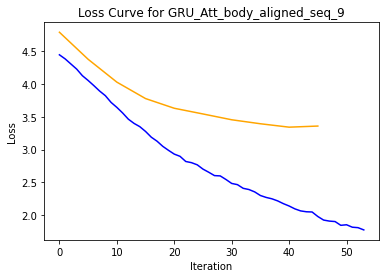

here 9
no of ratings 120
no of frames 120
error for GRU_Att_body_aligned_seq_9 on test set: 128.03049645584804
weighted error for GRU_Att_body_aligned_seq_9 on test set: 95.78093683358422
-----------------


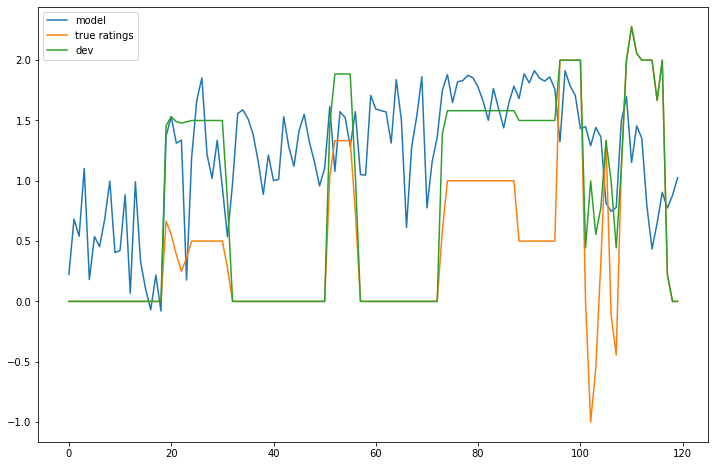

((tensor(128.0305, dtype=torch.float64), tensor(95.7809, dtype=torch.float64)),
 array([ 0.22383638,  0.68114656,  0.53963417,  1.10260534,  0.18096782,
         0.53837341,  0.45418555,  0.68216485,  0.99690956,  0.4053202 ,
         0.42198175,  0.88432634,  0.0684163 ,  0.99215728,  0.3347142 ,
         0.10212864, -0.0685645 ,  0.21864559, -0.07953627,  1.37009072,
         1.53301775,  1.31224394,  1.33705449,  0.17677571,  1.19474053,
         1.66731679,  1.85365856,  1.22020423,  1.0198108 ,  1.33650291,
         0.94492805,  0.53635931,  0.97935653,  1.55731153,  1.58818305,
         1.5167805 ,  1.38801587,  1.16312873,  0.88695681,  1.21389925,
         1.00244141,  1.01041567,  1.53155422,  1.27985656,  1.12030327,
         1.4159044 ,  1.55058765,  1.32349074,  1.15865183,  0.95697296,
         1.10410142,  1.61605787,  1.07844174,  1.57355201,  1.52459383,
         1.28461134,  1.5734421 ,  1.05193746,  1.04652655,  1.70831645,
         1.59509552,  1.5816294 ,  1.5709866

In [ ]:
batch_size = 64
seq_len = 9
train_dataset = VisualFeatureDatasetLSTM("pose", "training_unfiltered", False, True, True,seq_len, device)
valid_dataset = VisualFeatureDatasetLSTM("pose", "validation_unfiltered", False, True, True, seq_len, device)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

input_dim = len(train_dataset[0][0][0].flatten())
print(input_dim)

output_dim = 1
hidden_dim = 10
layer_dim = 3
learning_rate = 0.0001
model_name = "GRU_Att_body_aligned_seq_9"
model_type = "GruAtt"
num_epochs = 500
valid_freq = 5
patience = 5
bidir=True

va_padding = 1
VA=False

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

### Change the code below to try running different models:
## TODO: Also pass in bidirectional parameter and alter code for this.
# model = create_trainable_Network_Body((1+ 2*21 + 25)*3)  
model = GRUModel_Att(input_dim, hidden_dim, layer_dim, output_dim, device, dropout_prob=0.2, bidir=bidir)

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_for_feat_datasetLSTM(model, 
                       (model_name, "pose", model_type), 
                       train_loader, 
                       valid_loader, 
                       criterion='weighted_MSE', 
                       optimiser=optimiser, 
                       device=device, 
                       num_epochs=num_epochs, 
                       valid_freq=valid_freq,
                       VA=(VA, va_padding),
                       patience_threshold=patience)

gen_feat_graph_and_score(model_name, "pose", model_type = model_type, VA=VA, frames_per_seq=seq_len, show_graph=True)

201
cuda
Epoch: 0, Iteration: 0, training loss = 2248.4639
Epoch: 10, Iteration: 0, training loss = 2465.8433
Epoch: 20, Iteration: 0, training loss = 2226.6831
Epoch: 30, Iteration: 0, training loss = 1480.1863
Epoch: 40, Iteration: 0, training loss = 1038.7725
Epoch: 50, Iteration: 0, training loss = 1263.2410
Epoch: 60, Iteration: 0, training loss = 912.4617
Epoch: 70, Iteration: 0, training loss = 1050.8264


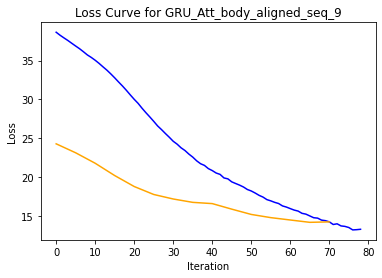

here 9


ValueError: ignored

In [ ]:
batch_size = 64
seq_len = 9
train_dataset = VisualFeatureDatasetLSTM("pose", "training_unfiltered", False, True, True,seq_len, device, True)
valid_dataset = VisualFeatureDatasetLSTM("pose", "validation_unfiltered", False, True, True, seq_len, device, True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

input_dim = len(train_dataset[0][0][0].flatten())
print(input_dim)

output_dim = seq_len
hidden_dim = 10
layer_dim = 3
learning_rate = 0.0001
model_name = "GRU_Att_body_aligned_seq_9"
model_type = "GruAtt"
num_epochs = 500
valid_freq = 5
patience = 5
bidir=True

va_padding = 1
VA=False

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = GRUModel_Att(input_dim, hidden_dim, layer_dim, output_dim, device, dropout_prob=0.2, bidir=bidir)

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_for_feat_datasetLSTM(model, 
                       (model_name, "pose", model_type), 
                       train_loader, 
                       valid_loader, 
                       criterion='weighted_MSE', 
                       optimiser=optimiser, 
                       device=device, 
                       num_epochs=num_epochs, 
                       valid_freq=valid_freq,
                       VA=(VA, va_padding),
                       patience_threshold=patience)

gen_feat_graph_and_score(model_name, "pose", model_type = model_type, VA=VA, frames_per_seq=seq_len, show_graph=True)

here 9
no of ratings 120
no of frames 120
(1080,)
error for GRU_Att_body_aligned_seq_9 on test set: tensor([[172.8238, 148.9446, 159.9729, 104.7873, 137.5934, 100.4537, 155.7637,
         124.0715, 113.6296]], device='cuda:0', dtype=torch.float64)
weighted error for GRU_Att_body_aligned_seq_9 on test set: tensor([[136.5618, 124.0939, 129.0738,  86.2731, 108.1131,  79.8793, 124.2386,
          97.5601,  87.1781]], device='cuda:0', dtype=torch.float64)
-----------------


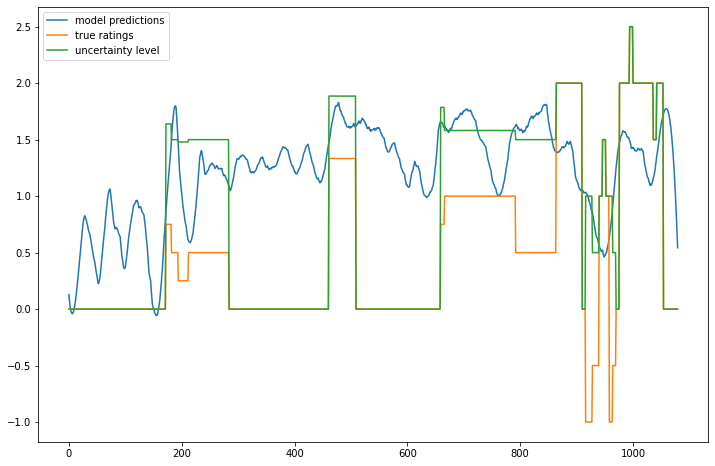

((tensor([[172.8238, 148.9446, 159.9729, 104.7873, 137.5934, 100.4537, 155.7637,
           124.0715, 113.6296]], device='cuda:0', dtype=torch.float64),
  tensor([[136.5618, 124.0939, 129.0738,  86.2731, 108.1131,  79.8793, 124.2386,
            97.5601,  87.1781]], device='cuda:0', dtype=torch.float64)),
 array([0.12825528, 0.07400242, 0.03098451, ..., 0.80171794, 0.6767866 ,
        0.5427443 ], dtype=float32))

In [ ]:
gen_feat_graph_and_score(model_name, "pose", model_type = model_type, VA=VA, frames_per_seq=seq_len, show_graph=True)


201
cuda
Epoch: 0, Iteration: 0, training loss = 351.0880
Epoch: 10, Iteration: 0, training loss = 221.5023
Epoch: 20, Iteration: 0, training loss = 197.9651
Epoch: 30, Iteration: 0, training loss = 110.3444
Epoch: 40, Iteration: 0, training loss = 109.2037
Epoch: 50, Iteration: 0, training loss = 123.4708


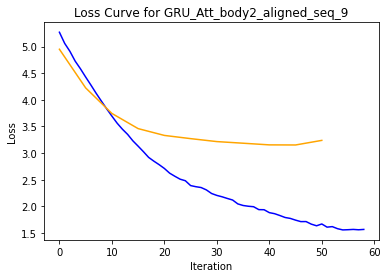

here 9
no of ratings 120
no of frames 120
error for GRU_Att_body2_aligned_seq_9 on test set: 155.07090484901465
weighted error for GRU_Att_body2_aligned_seq_9 on test set: 117.67609416132092
-----------------


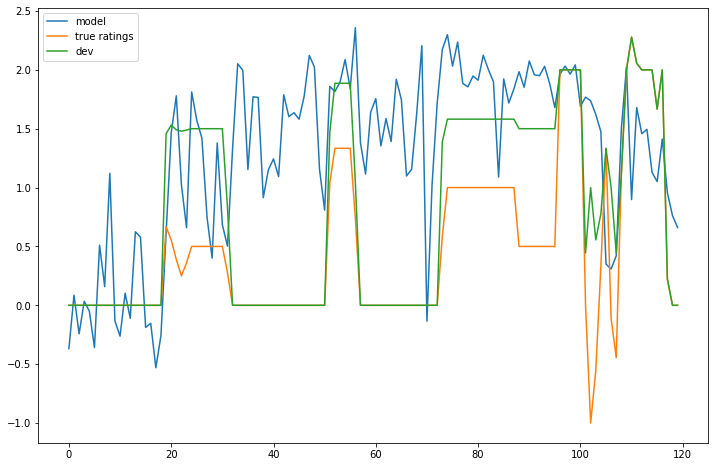

((tensor(155.0709, dtype=torch.float64),
  tensor(117.6761, dtype=torch.float64)),
 array([-0.36775354,  0.0858227 , -0.24202704,  0.03445722, -0.04947532,
        -0.35860425,  0.51070535,  0.15858132,  1.12091982, -0.13346924,
        -0.26215968,  0.10284448, -0.1107359 ,  0.62409937,  0.57914817,
        -0.18771988, -0.15322095, -0.53032124, -0.25599456,  0.60635877,
         1.46146619,  1.77935135,  1.02432263,  0.65925086,  1.81235838,
         1.5712918 ,  1.41998827,  0.75232852,  0.40074757,  1.37896574,
         0.68513429,  0.50260341,  1.32918239,  2.05164766,  1.99587011,
         1.1538198 ,  1.77121592,  1.76575863,  0.913818  ,  1.15183139,
         1.24343514,  1.09368002,  1.78857398,  1.60301542,  1.63575363,
         1.5805912 ,  1.77684045,  2.12247133,  2.02363372,  1.15366352,
         0.8085016 ,  1.85941684,  1.81591845,  1.89514613,  2.08725429,
         1.84013295,  2.35809255,  1.38122785,  1.11509264,  1.64123631,
         1.75515628,  1.35389817,  1.5860

In [ ]:
batch_size = 64
seq_len = 9
train_dataset = VisualFeatureDatasetLSTM("pose", "training_unfiltered", False, True, True,seq_len, device)
valid_dataset = VisualFeatureDatasetLSTM("pose", "validation_unfiltered", False, True, True, seq_len, device)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

input_dim = len(train_dataset[0][0][0].flatten())
print(input_dim)

output_dim = 1
hidden_dim = 25
layer_dim = 3
learning_rate = 0.00005
model_name = "GRU_Att_body2_aligned_seq_9"
model_type = "GruAtt"
num_epochs = 500
valid_freq = 5
patience = 5
bidir=True

va_padding = 1
VA=False

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

### Change the code below to try running different models:
## TODO: Also pass in bidirectional parameter and alter code for this.
# model = create_trainable_Network_Body((1+ 2*21 + 25)*3)  
model = GRUModel_Att(input_dim, hidden_dim, layer_dim, output_dim, device, dropout_prob=0.2, bidir=bidir)

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_for_feat_datasetLSTM(model, 
                       (model_name, "pose", model_type), 
                       train_loader, 
                       valid_loader, 
                       criterion='CCC', 
                       optimiser=optimiser, 
                       device=device, 
                       num_epochs=num_epochs, 
                       valid_freq=valid_freq,
                       VA=(VA, va_padding),
                       patience_threshold=patience)

gen_feat_graph_and_score(model_name, "pose", model_type = model_type, VA=VA, frames_per_seq=seq_len, show_graph=True)

#### Good Models

In [ ]:
batch_size = 64

train_dataset = VisualFeatureDataset("pose", "training_unfiltered", False, True, device)
valid_dataset = VisualFeatureDataset("pose", "validation_unfiltered", False, True, device)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

In [ ]:
seq_dim, input_dim = train_dataset[0][0].shape

output_dim = 1
hidden_dim = 64
layer_dim = 2
learning_rate = 0.0001
model_name = "GRU_body1_aligned"
model_type = "GRU"
num_epochs = 50
valid_freq = 5
patience = 5

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

### Change the code below to try running different models:
## TODO: Also pass in bidirectional parameter and alter code for this.
model = RNNModel(model_type, input_dim, hidden_dim, layer_dim, output_dim, device)

# criterion = nn.MSELoss(reduction='sum')

# criterion = lambda out, res, std : torch.sum(2/(1+std) * (out - res.float()) ** 2)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_for_feat_dataset(model, 
                       model_name, 
                       train_loader, 
                       valid_loader, 
                       criterion='weighted_MSE', 
                       optimiser=optimiser, 
                       device=device, 
                       num_epochs=num_epochs, 
                       valid_freq=valid_freq,
                       VA=True,
                       patience_threshold=patience)

cuda


NameError: ignored

201
cuda
Epoch: 0, Iteration: 0, training loss = 317.6613
Epoch: 10, Iteration: 0, training loss = 303.8371
Epoch: 20, Iteration: 0, training loss = 237.0822
Epoch: 30, Iteration: 0, training loss = 221.6136
Epoch: 40, Iteration: 0, training loss = 198.5808
Epoch: 50, Iteration: 0, training loss = 154.8276
Epoch: 60, Iteration: 0, training loss = 121.4476
Epoch: 70, Iteration: 0, training loss = 94.6259


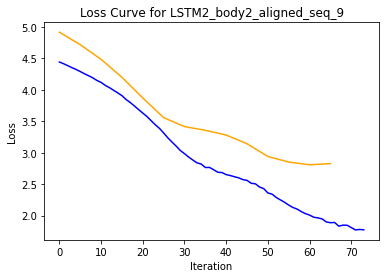

here 9
no of ratings 120
no of frames 120
error for LSTM2_body2_aligned_seq_9 on test set: 134.11023074486496
weighted error for LSTM2_body2_aligned_seq_9 on test set: 99.19978952597312
-----------------


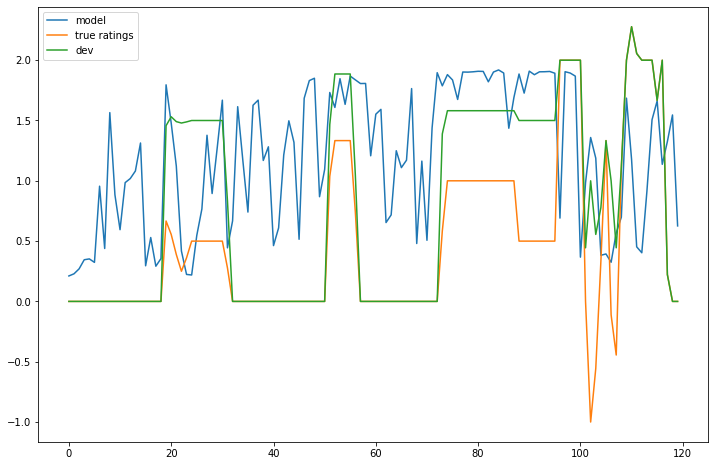

((tensor(134.1102, dtype=torch.float64), tensor(99.1998, dtype=torch.float64)),
 array([0.21112546, 0.22897448, 0.27011627, 0.34553927, 0.35251337,
        0.32362455, 0.95534289, 0.43882406, 1.56530881, 0.88414729,
        0.5947063 , 0.98496324, 1.01876676, 1.08119977, 1.31341422,
        0.29546916, 0.52979124, 0.29188049, 0.3553617 , 1.79574704,
        1.47930264, 1.12212014, 0.41778713, 0.22377342, 0.21911409,
        0.54663897, 0.76651084, 1.37763309, 0.89458042, 1.27457929,
        1.66857696, 0.4442147 , 0.66767377, 1.61447656, 1.17181659,
        0.74071383, 1.6266768 , 1.66876876, 1.16882503, 1.28194726,
        0.46277612, 0.60958153, 1.21363664, 1.4973923 , 1.31858385,
        0.51516956, 1.68463075, 1.8307811 , 1.85037267, 0.86816067,
        1.09402168, 1.73217702, 1.60827208, 1.84673202, 1.63384783,
        1.86823261, 1.83696127, 1.80634844, 1.80724275, 1.20737565,
        1.55220509, 1.59222329, 0.65380478, 0.71726376, 1.24938703,
        1.1092447 , 1.17102957, 1.76

In [ ]:
batch_size = 64
seq_len = 9
train_dataset = VisualFeatureDatasetLSTM("pose", "training_unfiltered", False, True, True,seq_len, device)
valid_dataset = VisualFeatureDatasetLSTM("pose", "validation_unfiltered", False, True, True, seq_len, device)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

input_dim = len(train_dataset[0][0][0].flatten())
print(input_dim)

output_dim = 1
hidden_dim = 10
layer_dim = 3
learning_rate = 0.0001
model_name = "LSTM2_body2_aligned_seq_9"
model_type = "LSTM"
num_epochs = 500
valid_freq = 5
patience = 5
bidir=False

va_padding = 1
VA=False

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

### Change the code below to try running different models:
## TODO: Also pass in bidirectional parameter and alter code for this.
# model = create_trainable_Network_Body((1+ 2*21 + 25)*3)  
model = RNNModel(model_type, input_dim, hidden_dim, layer_dim, output_dim, device, bidir=bidir)

# criterion = nn.MSELoss(reduction='sum')

# criterion = lambda out, res, std : torch.sum(2/(1+std) * (out - res.float()) ** 2)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_for_feat_datasetLSTM(model, 
                       (model_name, "pose", model_type), 
                       train_loader, 
                       valid_loader, 
                       criterion='weighted_MSE', 
                       optimiser=optimiser, 
                       device=device, 
                       num_epochs=num_epochs, 
                       valid_freq=valid_freq,
                       VA=(VA, va_padding),
                       patience_threshold=patience)

gen_feat_graph_and_score(model_name, "pose", model_type = model_type, VA=VA, frames_per_seq=seq_len, show_graph=True)

## Model Fusion

### All features available - model fusion

In [ ]:
def create_seq_scores(in_scores, frames_per_seq):
    scores = torch.tensor(in_scores) 
    scores = F.pad(scores, (0, (frames_per_seq- scores.shape[0] % frames_per_seq)),  "constant", 0. )
    scores = scores.reshape(scores.shape[0] // frames_per_seq, frames_per_seq)
    return scores

def eval_fusion(input_seq_len, rating_seq_len, face_model, pose_model, voice_model, fusion_model):

  outs = []

  show_individual_graphs = True
  score=0.
  score_w=0.
  ccc=0.
  
  face_model, f_model_type, VA_face = face_model 
  pose_model, p_model_type = pose_model
  model_name, v_model_type, VA_voice = voice_model

  print("eval", input_seq_len)
  audio_scores, audio_ratings = gen_voice_graph_and_score(model_name, v_model_type, VA=VA_voice, show_graph=show_individual_graphs)
  face_scores, face_ratings = gen_face_graph_and_score(face_model, model_type=f_model_type, VA=VA_face, frames_per_seq=input_seq_len, show_graph=show_individual_graphs)
  pose_scores, pose_ratings = gen_pose_graph_and_score(pose_model, model_type=p_model_type, VA=False, frames_per_seq=input_seq_len, show_graph=show_individual_graphs)

  test_overall_ratings = torch.tensor(np.load(f"{content_path}/opinions/overall_ratings_labels_test_slice.npy"))
  test_overall_ratings_dev = torch.tensor(np.load(f"{content_path}/opinions/overall_ratings_devs_test_slice.npy"))

  plt.figure(figsize=(12, 8))
  test_overall_ratings = create_seq_scores(test_overall_ratings, input_seq_len)
  test_overall_ratings = torch.mean(test_overall_ratings, dim=1)

  test_overall_ratings_dev = create_seq_scores(test_overall_ratings_dev, input_seq_len)
  test_overall_ratings_dev = torch.mean(test_overall_ratings_dev, dim=1)

  face_ratings = create_seq_scores(face_ratings, rating_seq_len)
  pose_ratings = create_seq_scores(pose_ratings, rating_seq_len)

  audio_ratings = create_seq_scores(audio_ratings, rating_seq_len)

  print(audio_ratings.shape)
  print(face_ratings.shape)
  print(test_overall_ratings.shape)

  model = torch.load(f"{content_path}/models/{fusion_model}")
  model.eval()

  for seq in range(min(face_ratings.shape[0], audio_ratings.shape[0])): 
    # fusion
    f=face_ratings[seq]
    p=pose_ratings[seq]
    v=audio_ratings[seq]

    input = torch.stack([f, p, v], dim=1)
    # print(input.shape)
    # seq_dim = input.shape[0]
    input_dim = len(input[0].flatten())
    seq_len = input.shape[0]
    feature = Variable(input.view(-1, seq_len, input_dim).to(device))

    network_prediction = model(feature.float()).squeeze(-1)
    outs.append(network_prediction)

    
    score += torch.sum((network_prediction - test_overall_ratings[seq])**2)
    score_w += torch.sum(((network_prediction - test_overall_ratings[seq])**2 * (1/(1 + test_overall_ratings_dev[seq]))))
  
  outs = torch.stack(outs, 0)
  outs = outs.flatten().detach().cpu()
  test_overall_ratings = test_overall_ratings.flatten().cpu()

  plt.plot(range(outs.shape[0]), outs, label = 'Model Predictions')
  plt.plot(range(len(test_overall_ratings)), test_overall_ratings, label='True Mean Ratings')
  plt.plot(range(len(test_overall_ratings_dev)), test_overall_ratings_dev, label='Uncertainty factor')
  
  ccc += ccc_loss(outs, test_overall_ratings)

  plt.title("Engagement for Overall Performance predictions")
  # plt.xticks(range(0, outs.shape[0], 30), [i//6 for i in range(0, outs.shape[0], 30)])
  plt.xlabel("Time (seconds)")
  plt.ylabel("Predicted score")

  print()
  print(f'error for {fusion_model} on test set: {score.item()}')
  print(f'weighted error for {fusion_model} on test set: {score_w.item()}') 
  print()
  print(f'CCC score for {fusion_model} on test set: {ccc}')

  score_overall = 1.0 - torch.sum(torch.abs(test_overall_ratings) * (1/(1 + test_overall_ratings_dev))) / len(outs)
  
  print(f"overall score: {score_overall}")
  print('-----------------')
  plt.legend()
  plt.show() 

def train_fusion(network, name, loader_train, loader_val, criterion, optimiser, device="cpu", num_epochs=10, valid_freq=1, VA=False, patience_threshold = 5):
      network.to(device)

      losses = []
      losses_validation = []
      iterations = []
      patience_threshold = patience_threshold
      patience = patience_threshold

      for epoch in range(num_epochs):
        network.train()
        loss_train = 0
        train_total = 0
        ############################### Loop over training iterations  
        for iter, ((f,f_std), (p, p_std), (v, v_std), (o, o_std)) in enumerate(loader_train):
          optimiser.zero_grad()
          input = torch.stack([f, p, v], dim = -1)

          input_dim = input.shape[-1]
          seq_len = input.shape[1]

          feature = Variable(input.view(-1, seq_len, input_dim).to(device))
          # stds = (f_std + p_std + v_std)/3.
          std = Variable(o_std.to(device))
          o = Variable(o.to(device))
 
          network_prediction = network(feature.float()).squeeze(-1)
          
          if criterion == 'MSE':
            loss = torch.nn.MSELoss(reduction='sum')(network_prediction.float(), o.float())
          else:
            loss = torch.sum(2/(1+ std) * (network_prediction - o) ** 2)

          loss.backward()
          loss_value = loss.item()

          train_total += o.size(0)
          loss_train += loss_value

          optimiser.step()
          if epoch % 10 == 0 and iter % 20 == 0: 
            print('Epoch: %d, Iteration: %d, training loss = %.4f' % (epoch, iter, loss_value))         

        losses.append(loss_train/train_total)
        iterations.append(epoch)

        ###################### check performance on validation set
        if epoch % valid_freq == 0:
          network.eval()
          v_loss = 0
          v_total = 0
          with torch.no_grad():
            for v_iter, ((f,f_std), (p, p_std), (v, v_std), (vo, vo_std)) in enumerate(loader_val):

              input = torch.cat([f, p, v], dim=1)
              feature = Variable(input.view(-1, seq_len, input_dim).to(device))
              # stds = (f_std + p_std + v_std)/3.
              vo_std = Variable(vo_std.to(device))
              vo = Variable(vo.to(device))
              
              v_outputs = network(feature).squeeze(-1)
              # vo_std = Variable(vo_std.to(device))

              v_total += o.size(0)
              # loss = criterion(v_outputs.float(), v_labels.float())
              if criterion == 'MSE':
                loss = torch.nn.MSELoss(reduction='sum')(v_outputs.float(), o.float())
              else:
                loss = torch.sum(2/(1+ vo_std) * (v_outputs - vo) ** 2)

              v_loss_value = loss.item()
              v_loss += v_loss_value

              if iter % 20 == 0: 
                print('Epoch: %d, Iteration: %d, valid loss = %.4f' % (epoch, v_iter, v_loss_value))         
              
          losses_validation.append(v_loss/v_total)

        if epoch > 10 and (losses_validation[int(epoch / valid_freq) - 1] < losses_validation[int(epoch / valid_freq)]):
            patience -= 1
        else:
            patience = patience_threshold

        if patience == 0:
            break

      plot_loss_iters(name, content_path, valid_freq, losses, losses_validation)
      torch.save(network, f"{content_path}/models/{name}")
      # (name, feat, model_type = model_type, VA=VA, show_graph=True)

class PredictionDataset(Dataset):

    def __init__(self, dataset, seq_len=12, transform = True):

      frames_per_seq = seq_len
      self.features = []
      self.features_dev = []
      for i, f in enumerate(["face", "pose", "voice", "overall"]):
        self.features.append(Tensor(np.load(f"{content_path}/opinions/{f}_ratings_labels_{dataset}.npy")))
        self.features_dev.append(Tensor(np.load(f"{content_path}/opinions/{f}_ratings_devs_{dataset}.npy")))

        self.features[i] = F.pad(self.features[i], (0,(frames_per_seq- self.features[i].shape[0] % frames_per_seq)),  "constant", 0. )
        self.features[i] = self.features[i].reshape(self.features[i].shape[0]//frames_per_seq, frames_per_seq)
      
        self.features_dev[i] = F.pad(self.features_dev[i], (0,(frames_per_seq- self.features_dev[i].shape[0] % frames_per_seq)),  "constant", 0. )
        self.features_dev[i] = self.features_dev[i].reshape(self.features_dev[i].shape[0]//frames_per_seq, frames_per_seq)
          
    def __len__(self):
        return len(self.features[0])

    def __getitem__(self, idx):
      face = self.features[0][idx]
      pose = self.features[1][idx]
      voice = self.features[2][idx]

      face_std = self.features_dev[0][idx]
      pose_std = self.features_dev[1][idx]
      voice_std = self.features_dev[2][idx]

      o = self.features[3][idx]
      o_std = self.features_dev[3][idx]

      return (face, face_std), (pose, pose_std), (voice, voice_std), (o, o_std)


#### Training

In [ ]:
seq_len = 6
batch_size = 64

train_dataset = PredictionDataset(dataset="training_unfiltered", seq_len=seq_len)
valid_dataset = PredictionDataset(dataset="validation_unfiltered", seq_len=seq_len)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

input_dim = 3
output_dim = seq_len
hidden_dim = 8
layer_dim = 2
learning_rate = 0.0001
model_name = "Model_Fusion_all_feature3"
model_type = "LSTM"
num_epochs = 2000
valid_freq = 5
patience = 5
bidir=False

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

### Change the code below to try running different models:
## TODO: Also pass in bidirectional parameter and alter code for this.
model = RNNModel(model_type, input_dim, hidden_dim, layer_dim, output_dim, device, bidir=bidir)

# criterion = nn.MSELoss(reduction='sum')

# criterion = lambda out, res, std : torch.sum(2/(1+std) * (out - res.float()) ** 2)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_fusion(model, 
            model_name, 
            train_loader, 
            valid_loader, 
            criterion='weighted_MSE', 
            optimiser=optimiser, 
            device=device, 
            num_epochs=num_epochs, 
            valid_freq=valid_freq,
            VA=True,
            patience_threshold=patience)


NameError: ignored

#### Evaluations

In [ ]:
eval_fusion_att(9, "Model_Fusion_all_feature3", att = False)

faces: torch.Size([120, 9, 1, 70, 3])
poses: torch.Size([120, 9, 1, 67, 3])
voices: 115
torch.Size([114])
torch.Size([120])


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([114])) that is different to the input size (torch.Size([120])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored

eval 9
(116,)
119
no of ratings 116
no of video clips 116
error for GRU_voice_va_short_seq on test set: 186.80956696462053
weighted error for GRU_voice_va_short_seq on test set: 137.3201967499893


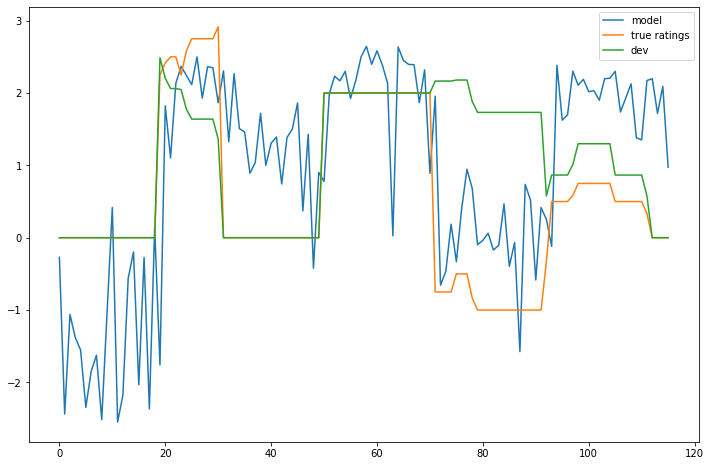

here 9
no of ratings 118
no of frames 118
error for LSTM_face_align_seq_of_9 on test set: 228.0698669359362
weighted error for LSTM_face_align_seq_of_9 on test set: 165.18419323646611
-----------------


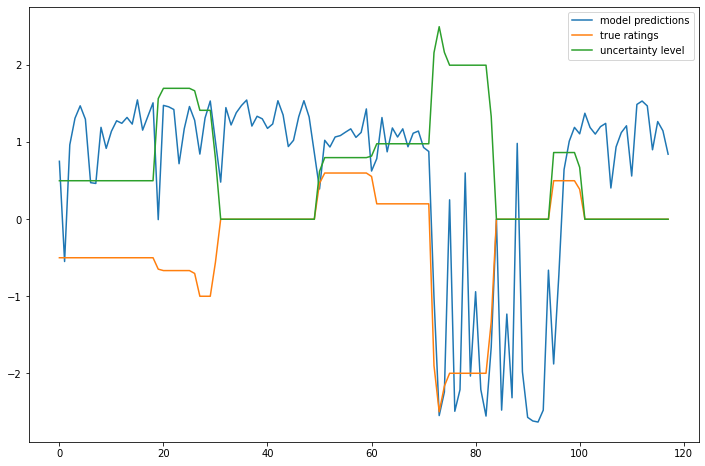

here 9
no of ratings 120
no of frames 120
error for GRU_Att_body_aligned_seq_9 on test set: 137.28291829645102
weighted error for GRU_Att_body_aligned_seq_9 on test set: 95.80524082313946
-----------------


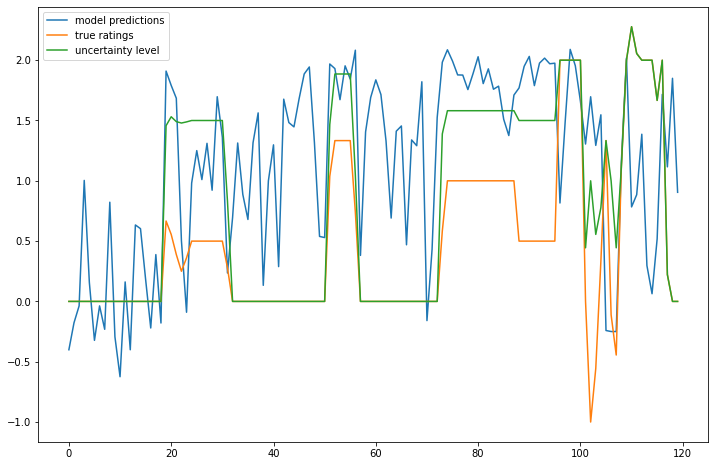

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([20, 6])
torch.Size([21, 6])
torch.Size([120])

error for Model_Fusion_all_feature3 on test set: 32.06917953491211
weighted error for Model_Fusion_all_feature3 on test set: 31.76032066345215

CCC score for Model_Fusion_all_feature3 on test set: 0.9846777847056004
overall score: 0.8520935908759917
-----------------


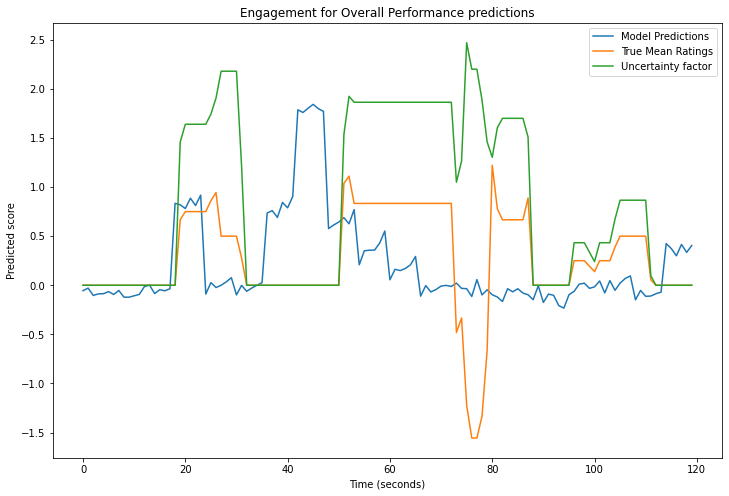

In [ ]:
eval_fusion(9, 6, ("LSTM_face_align_seq_of_9", "LSTM", True), ("GRU_Att_body_aligned_seq_9", "GRU"), ("GRU_voice_va_short_seq", "GRU", True), "Model_Fusion_all_feature3" )

eval 9
no of ratings 56
no of video clips 56
error for GRU_voice3 on test set: 94.962413189729
weighted error for GRU_voice3 on test set: 70.55528054292488


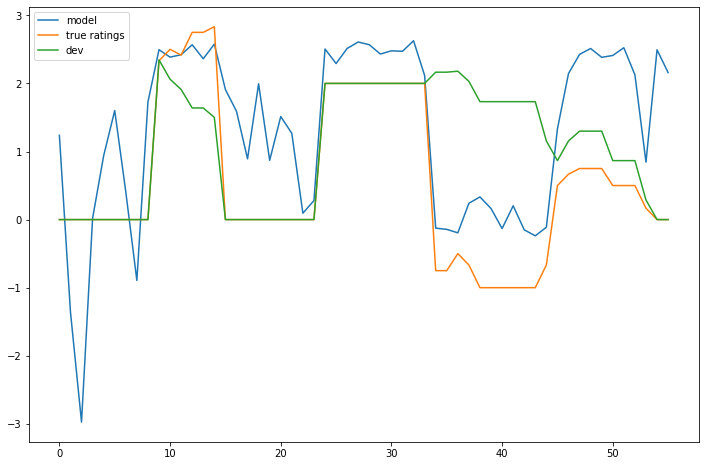

here 9
no of ratings 118
no of frames 118
error for LSTM_face_align_seq_of_9 on test set: 228.0698320157229
weighted error for LSTM_face_align_seq_of_9 on test set: 165.1841785698271
-----------------


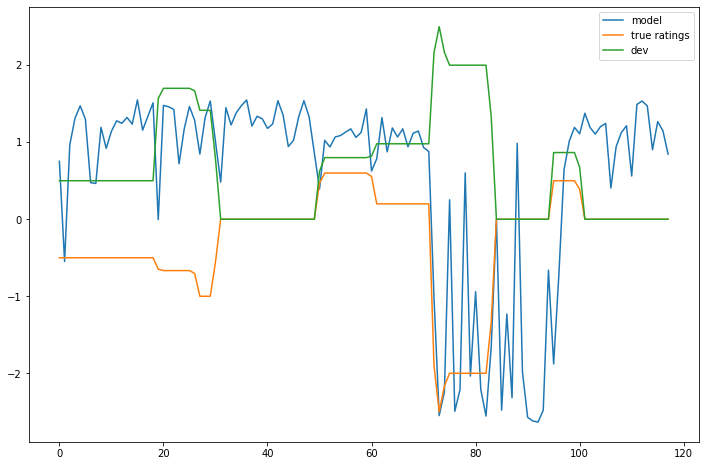

here 9
no of ratings 120
no of frames 120
error for LSTM2_body1_aligned_seq_9 on test set: 108.49919234337737
weighted error for LSTM2_body1_aligned_seq_9 on test set: 86.92955810580646
-----------------


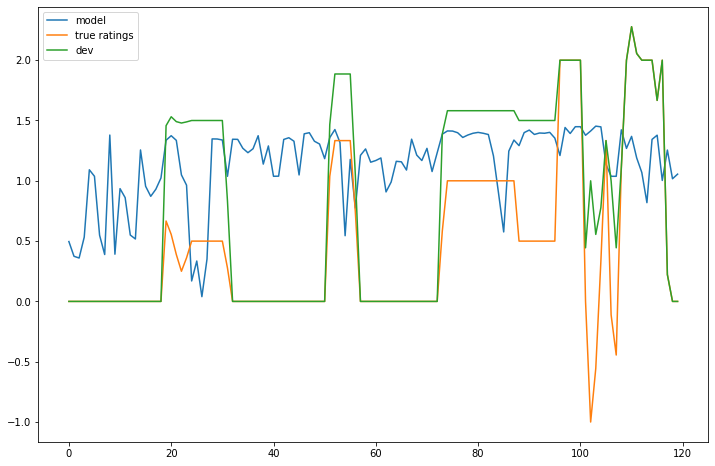


error for Model_Fusion_all_feature3 on test set: 26.619897842407227
weighted error for Model_Fusion_all_feature3 on test set: 22.436649322509766
overall score: 0.8591367532152302
-----------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


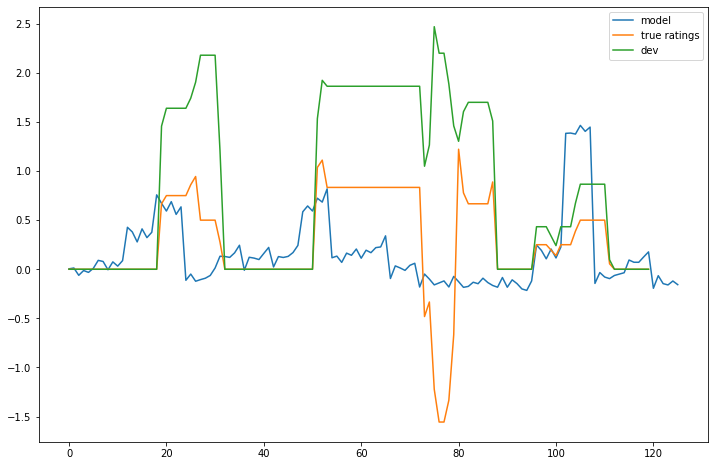

In [ ]:
eval_fusion(9, 6, ("LSTM_face_align_seq_of_9", "LSTM", True), ("LSTM2_body1_aligned_seq_9", "LSTM"), ("GRU_voice3", "GRU", True), "Model_Fusion_all_feature3" )

eval 9
(116,)
118
no of ratings 116
no of video clips 115
error for GRU_voice_va_short_seq on test set: 413.35227131781534
weighted error for GRU_voice_va_short_seq on test set: 413.35227131781534


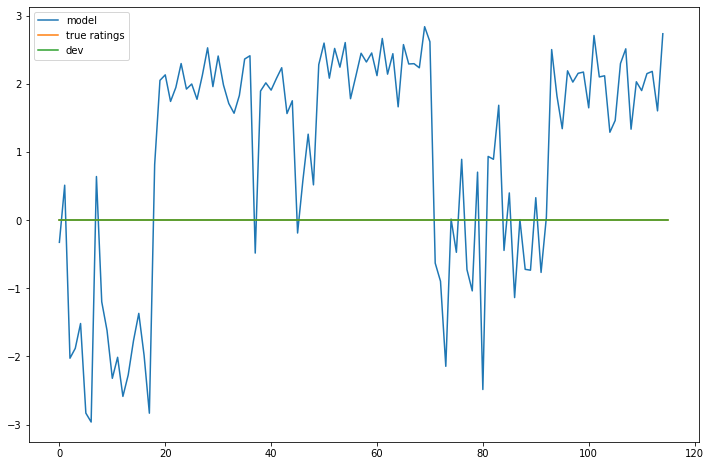

here 9
no of ratings 118
no of frames 118
error for BGRU_Att_face_align_seq_of_9 on test set: 211.22180327778182
weighted error for BGRU_Att_face_align_seq_of_9 on test set: 160.39504385484423
-----------------


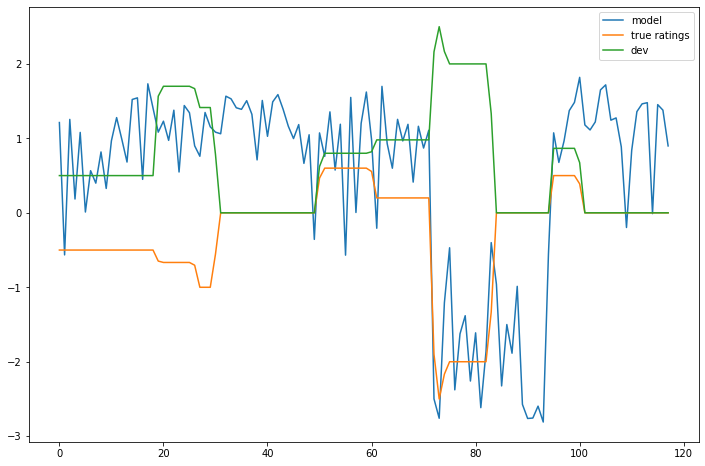

here 9
no of ratings 120
no of frames 120
error for GRU_Att_body_aligned_seq_9 on test set: 128.03049645584804
weighted error for GRU_Att_body_aligned_seq_9 on test set: 95.78093683358422
-----------------


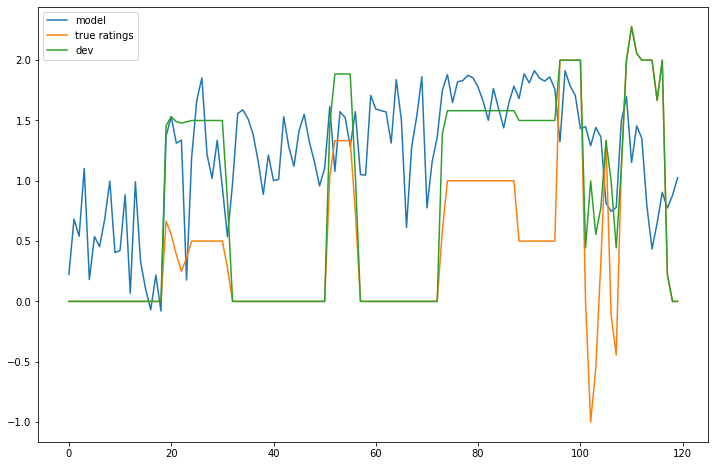


error for Model_Fusion_all_feature3 on test set: 13.091211318969727
weighted error for Model_Fusion_all_feature3 on test set: 11.869096755981445
overall score: 0.8520935908759917
-----------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


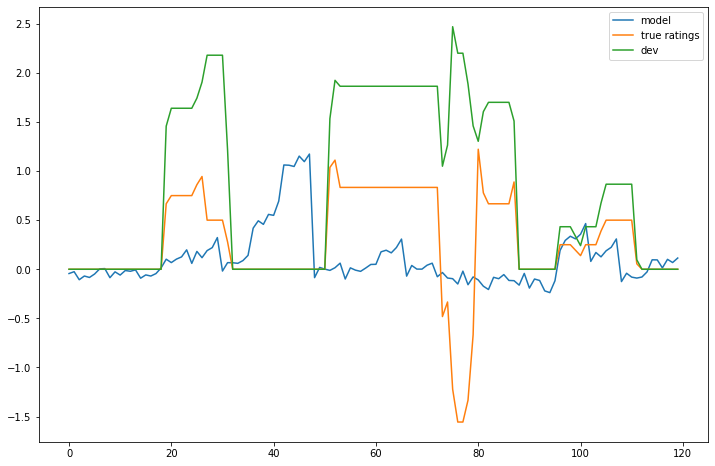

In [ ]:
eval_fusion(9, 6, ("BGRU_Att_face_align_seq_of_9", "GRU", False), ("GRU_Att_body_aligned_seq_9", "LSTM"), ("GRU_voice_va_short_seq", "GRU", False), "Model_Fusion_all_feature3" )

### Attention-based fusion

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def eval_fusion_att(seq_len, network_name, out_len=6, single_cue_nets=None, att=True):

  outs = []
  test_ratings =[]
  test_ratings_dev =[]

  score_MSE=0
  score_wMSE=0
  score_CCC=0

  batch_size=1

  # video_label_path=f'{content_path}/test_pipeline/opinions_visual.csv'
  # video_path=f'{content_path}/test_pipeline/videos_eval/video_b2_'

  video_label_path=f'{content_path}/video_features/opinions_visual.csv'
  video_path=f'{content_path}/video_features/video_b1_'

  # audio_label_path = f"{content_path}/test_pipeline/opinions_audio.csv"
  # audio_path = f"{content_path}/test_pipeline/videos_eval/dataset/dataset_audio_segments"

  audio_label_path = f"{content_path}/dataset/audio/opinions_audio.csv"
  audio_path = f"{content_path}/dataset/audio/"

  # test_dataset = AttentionPredictionDataset("test",  frames_per_seq=seq_len, device=device)
  # test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
  #                                         batch_size=batch_size,
  #                                         shuffle=False)

  test_dataset = MultiModalDataset("test",  audio_path, audio_label_path,
                                 video_path, video_label_path,
                                 frames_per_seq=9, device=device)

  test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

  network = torch.load(f'{content_path}/models/{network_name}')
  network.eval()

  if single_cue_nets != None:  
    f, p, v = single_cue_nets

  else:
    f, p, v = ("BGRU_Att_face_align_seq_of_9", "GRU_Att_body_aligned_seq_9" ,"GRU_voice_va_short_seq")
  
  path_f = f'{content_path}/models/{f}'
  path_p = f'{content_path}/models/{p}'
  path_v = f'{content_path}/models/{v}'

  scorer_f=torch.load(path_f)
  scorer_p=torch.load(path_p)
  scorer_v=torch.load(path_v)

  scorer_f.eval().to(device)
  scorer_p.eval().to(device)
  scorer_v.eval().to(device)

  with torch.no_grad():
    for iter, (features, o, o_std) in enumerate(test_loader):
      if out_len==1:
        o = torch.mean(o, dim=-1) 
        o_std = torch.mean(o_std, dim=-1)

      std = Variable(o_std.to(device))
      o = Variable(o.to(device))

      with torch.no_grad():
        if att:
          f, f_h = scorer_f(features[0].to(device), att)
          p, _= scorer_p(features[1].to(device), att) 
          v, _= scorer_v(features[2].to(device), att)

          network_prediction = network(f,p,v)

        else:  
          f = scorer_f(features[0].to(device), att)
          p = scorer_p(features[1].to(device), att) 
          v = scorer_v(features[2].to(device), att)

          seq=6

          f = f.unsqueeze(0)
          p = p.unsqueeze(0)
          v = v.unsqueeze(0)

          o = torch.mean(o, dim=-1).unsqueeze(0)
          o_std = torch.mean(o_std, dim=-1).unsqueeze(0)

          input = torch.stack([f, p, v], dim=-1)
          input_dim = 3
          seq_len = input.shape[1]
          feature = Variable(input.view(-1, seq_len, input_dim).to(device))
          network_prediction = network(feature.float()).squeeze(-1)

          # print(network_prediction.shape)

      outs.append(network_prediction.squeeze(0))
      test_ratings.append(o.squeeze(0))
      test_ratings_dev.append(o_std.squeeze(0))

  outs= torch.stack(outs)
  outs=outs.flatten()

  # outs = torch.tensor(moving_average(outs.cpu(), 50))
  # with torch.no_grad():
  #   outs = torch.nn.Conv1d(1, 1, 11, padding=5, bias=False, padding_mode='zeros', device=device)(outs.unsqueeze(0))
  #   outs = outs.squeeze()
  outs = torch.tensor(savgol_filter(np.array(outs.cpu()), 21, 3))
  outs = outs.to(device)

  test_ratings = torch.stack(test_ratings).flatten()
  test_ratings_dev = torch.stack(test_ratings_dev).flatten()

  test_ratings =test_ratings.to(device)
  test_ratings_dev = test_ratings_dev.to(device)
  print(test_ratings.shape)
  print(outs.shape)

  loss = torch.nn.MSELoss(reduction='sum')(outs.float(), test_ratings.float())
  score_MSE+= loss.item() 
  loss = concordance_cc2(outs, test_ratings)
  score_CCC+=loss.item()
  loss = torch.sum(2/(1+ test_ratings_dev) * (outs - test_ratings) ** 2)      
  score_wMSE+=loss.item()   
                                    
  plt.figure(figsize=(12, 8))

  print()
  # test_ratings = torch.stack(test_ratings).flatten()
  score = 1.0 - (torch.sum(torch.abs(outs - test_ratings) * (1/(1+test_ratings_dev)))) / len(outs)
  print(f"Weigthed score for the current model after smoothening: {score}")
  print(f'CCC score for {network_name} on test set: {score_CCC}')

  plt.plot(range(outs.shape[0]), outs.cpu(), label = 'Model Predictions')
  plt.plot(range(len(test_ratings)), test_ratings.cpu(), label='True Ratings')
  plt.plot(range(len(test_ratings_dev)), test_ratings_dev.cpu(), label='Uncertainty Factor')
  print()
  print(f'MSE error for {network_name} on test set: {score_MSE}')
  print(f'weighted MSE error for {network_name} on test set: {score_wMSE}')

  # score_overall = 1.0 - torch.sum(torch.abs(test_overall_ratings) * (1/(1 + test_overall_ratings_dev))) / len(outs)
  
  # print(f"overall score: {score_overall}")
  # print('-----------------')
  plt.legend()
  plt.show() 

def ccc_loss(y_hat, y):
        a = concordance_cc2(y_hat.view(-1), y.view(-1), 'none')
        if a == 0: 
          return torch.tensor(1.)
        return 1 - a.squeeze()

def concordance_cc2_np(r1, r2):
    mean_cent_prod = ((r1 - r1.mean()) * (r2 - r2.mean())).mean()
    return (2 * mean_cent_prod) / (r1.var() + r2.var() + (r1.mean() - r2.mean()) ** 2)

def concordance_cc2(r1, r2, reduction='mean'):
    '''
    Computes batch sequence-wise CCC.
    '''
    # print(type(r1), type(r2))
    r1_mean = torch.mean(r1, dim=-1, keepdim=True)
    r2_mean = torch.mean(r2, dim=-1, keepdim=True)
    mean_cent_prod = torch.mean(((r1 - r1_mean) * (r2 - r2_mean)), dim=-1, keepdim=True)
    
    # print((r1.var(dim=-1, keepdim=True) + r2.var(dim=-1, keepdim=True) + (r1_mean - r2_mean) ** 2))
    # print((torch.var(r1, dim=-1, keepdim=True) + torch.var(r2, dim=-1, keepdim=True) + (r1_mean - r2_mean) ** 2))
    ccc = (2 * mean_cent_prod) / (r1.var(dim=-1, keepdim=True) + r2.var(dim=-1, keepdim=True) + (r1_mean - r2_mean) ** 2)
    if reduction == 'none':
        return ccc
    elif reduction == 'mean':

        return ccc.mean()  

class AttentionPredictionDataset(Dataset):

    def __init__(self, dataset, frames_per_seq=12, device=device):

      self.vectors = []

      self.audio_ratings = pd.read_csv(f'{content_path}/dataset/aud_3s/{dataset}/{dataset}_labels_stddev.csv')
      self.audio_dir = f'{content_path}/dataset/aud_3s/{dataset}'
      # print("audio", len(os.listdir(self.audio_dir))-2)

      for i, f in enumerate(["face", "pose"]):
        
        self.feat_dataset = torch.load(f"{content_path}/dataset/{f}_{dataset}_unfiltered")

        self.feat_dataset = F.pad(self.feat_dataset, (0, 0, 0, 0, 0, 0, 0, (frames_per_seq- self.feat_dataset.shape[0] % frames_per_seq)),  "constant", 0. )
        self.feat_dataset = self.feat_dataset.reshape(self.feat_dataset.shape[0]//frames_per_seq, frames_per_seq, self.feat_dataset.shape[1], self.feat_dataset.shape[2], self.feat_dataset.shape[3]) 
        self.vectors.append(self.feat_dataset)
  
      self.overall = (Tensor(np.load(f"{content_path}/opinions/overall_ratings_labels_{dataset}.npy")))
      self.overall_dev = (Tensor(np.load(f"{content_path}/opinions/overall_ratings_devs_{dataset}.npy")))

      self.overall = F.pad(self.overall, (0,(frames_per_seq- self.overall.shape[0] % frames_per_seq)),  "constant", 0. )
      self.overall = self.overall.reshape(self.overall.shape[0]//frames_per_seq, frames_per_seq)
      
      self.overall_dev = F.pad(self.overall_dev, (0,(frames_per_seq- self.overall_dev.shape[0] % frames_per_seq)),  "constant", 0. )
      self.overall_dev = self.overall_dev.reshape(self.overall_dev.shape[0]//frames_per_seq, frames_per_seq)

      print("faces:", self.vectors[0].shape)
      print("poses:", self.vectors[1].shape)
      print("voices:", len(self.audio_ratings)-1)

    def __len__(self):
      return min(len(self.overall), len(self.audio_ratings)-1)

    def __getitem__(self, idx):
      sample_file = f'{self.audio_dir}/{self.audio_ratings.iloc[idx, 0]}'
      clip = read(sample_file)
      audio_features = librosa.feature.mfcc(y=clip[1].astype(float), sr=clip[0], hop_length=512, n_fft=2048).transpose().astype(np.float32)

      self.feats= []
      for i,f in enumerate(["face","pose"]):
        vec = self.vectors[i][idx]
        frame_seq = align_crop_resize_per_seq(f, data=vec)
        frame_seq = frame_seq.flatten(start_dim=1)
        self.feats.append((frame_seq.float()))

      self.feats.append(torch.tensor(audio_features))  

      o = self.overall[idx]
      o_std = self.overall_dev[idx]

      return (self.feats, o, o_std)

def train_fusion_with_att(name, loader_train, loader_val, criterion, device="cpu", 
                          num_epochs=10, learning_rate=0.0001, valid_freq=1,
                          VA=False, patience_threshold = 5, out_seq=9):
      losses = []
      losses_validation = []
      iterations = []
      patience_threshold = patience_threshold
      patience = patience_threshold

      f, p, v = ("BGRU_Att_face_align_seq_of_9", "GRU_Att_body_aligned_seq_9" ,"GRU_voice_va_short_seq")
      path_f = f'{content_path}/models/{f}'
      path_p = f'{content_path}/models/{p}'
      path_v = f'{content_path}/models/{v}'

      scorer_f=torch.load(path_f)
      scorer_p=torch.load(path_p)
      scorer_v=torch.load(path_v)

      scorer_f.eval().to(device)
      scorer_p.eval().to(device)
      scorer_v.eval().to(device)

      network = AttentionFusion([64,20,128], out_dim=out_seq)
      optimiser = torch.optim.Adam(network.parameters(), lr=learning_rate)
      network.to(device)

      for epoch in range(num_epochs):
        network.train()
        loss_train = 0
        train_total = 0
        ############################### Loop over training iterations  
        for iter, (features, o, o_std) in enumerate(loader_train):
          optimiser.zero_grad()

          std = Variable(o_std.to(device))
          o = Variable(o.to(device))

          with torch.no_grad():
            f, f_h = scorer_f(features[0].to(device), True)
            p, _= scorer_p(features[1].to(device), True) 
            v, _= scorer_v(features[2].to(device), True)

          network_prediction = network(f,p,v)
          # print('...................')
          # print(o.shape)
          # print(network_prediction.shape)

          if out_seq == 1:
            o = torch.mean(o, dim=-1)

          if criterion == 'MSE':
            loss = torch.nn.MSELoss(reduction='sum')(network_prediction.float(), o.float())
          elif criterion == "CCC" and o.shape[0]>1:
            loss = ccc_loss(network_prediction.float(), o.float())
          else:
            loss = torch.sum(2/(1+ std) * (network_prediction - o) ** 2)

          loss.backward()
          loss_value = loss.item()

          train_total += o.size(0)

          if np.isnan(loss_value):
            print(loss)
            print(network_prediction)

          loss_train += loss_value

          optimiser.step()
          if iter % 20 == 0: 
            print('Epoch: %d, Iteration: %d, training loss = %.4f' % (epoch, iter, loss_value))         

        losses.append(loss_train/train_total)
        iterations.append(epoch)

        ###################### check performance on validation set
        if epoch % valid_freq == 0:
          network.eval()
          v_loss = 0
          v_total = 0
          with torch.no_grad():
            for v_iter, (v_features, vo, vo_std) in enumerate(loader_val):

              f, _= scorer_f(v_features[0].to(device), True)
              p, _= scorer_p(v_features[1].to(device), True) 
              v, _= scorer_v(v_features[2].to(device), True)

              v_outputs = network(f,p,v)
              
              if out_seq ==1:
                vo = torch.mean(vo, dim=-1)

              v_total += vo.size(0)

              # loss = criterion(v_outputs.float(), v_labels.float())
              if criterion == 'MSE':

                loss = torch.nn.MSELoss(reduction='sum')(v_outputs.float(), vo.float())
              elif criterion == "CCC" and vo.shape[0]>1:
                loss = ccc_loss(v_outputs, vo)
              else:
                loss = torch.sum(2/(1+ vo_std) * (v_outputs - vo) ** 2)

              v_loss_value = loss.item()
              v_loss += v_loss_value

              if iter % 20 == 0: 
                print('Epoch: %d, Iteration: %d, valid loss = %.4f' % (epoch, v_iter, v_loss_value))         
              
          losses_validation.append(v_loss/v_total)

        if epoch > 10 and (losses_validation[int(epoch / valid_freq) - 1] < losses_validation[int(epoch / valid_freq)]):
            patience -= 1
        else:
            patience = patience_threshold

        if patience == 0:
            break

      plot_loss_iters(name, content_path, valid_freq, losses, losses_validation)
      torch.save(network, f"{content_path}/models/{name}")
      # (name, feat, model_type = model_type, VA=VA, show_graph=True)

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.uniform_(-stdv, stdv)

    def forward(self, hidden, encoder_outputs):
        timestep = encoder_outputs.size(1)
        h = hidden.repeat(timestep, 1, 1).transpose(0, 1) # B*T*H
        # encoder_outputs: [B*T*H]
        attn_energies = self.score(h, encoder_outputs)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

    def score(self, hidden, encoder_outputs):
        # [B*T*2H]->[B*T*H]
        energy = F.relu(self.attn(torch.cat([hidden, encoder_outputs], 2)))
        energy = energy.transpose(1, 2)  # [B*H*T]
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)  # [B*1*H]
        energy = torch.bmm(v, energy)  # [B*1*T]
        return energy.squeeze(1)  # [B*T]


class AttFusion(nn.Module):
    # def __init__(self, input_dim=[512, 512, 512]):
    #     super(AttFusion, self).__init__()
    #     hidden_dim = 128
    #     seq_len = 1
        
    #     self.scorer_f = GRUModel_Att(input_dim[2], hidden_dim, 1, seq_len, device=device, bidir=True)
    #     self.scorer_p = GRUModel_Att(input_dim[2], hidden_dim, 1, seq_len, device=device, bidir=True)
    #     self.scorer_v = GRUModel_Att(input_dim[2], hidden_dim, 1, seq_len, device=device, bidir=True)

    #     self.scorer_f.train()
    #     self.scorer_p.train()
    #     self.scorer_v.train()

    # def forward(self, x_f, x_p, x_v):
        # x_f = x_f[:, -1,:].unsqueeze(1)
        # x_p = x_p[:, -1,:].unsqueeze(1)
        # x_v = x_v[:, -1,:].unsqueeze(1)

        # x_p = F.pad(x_p, (0, (x_v.shape[-1]-x_p.shape[-1])), "constant", 0.)
        # x_f = F.pad(x_f, (0, (x_v.shape[-1]-x_f.shape[-1])), "constant", 0.)

        # f= self.scorer_f(x_f.to(device))
        # p = self.scorer_p(x_p.to(device))
        # v= self.scorer_v(x_v.to(device))

        # h_f = torch.sigmoid(f)
        # h_p = torch.sigmoid(p)
        # h_v = torch.sigmoid(v)
        
        # h = torch.cat((h_f, h_p, h_v), dim=-1) # (B, T, 3)
        # h = F.softmax(h, dim=-1)

        # f = h[..., 2].unsqueeze(-1) * x_v[:, -1,:] + h[..., 0].unsqueeze(-1) * x_f[:, -1,:] +  h[..., 1].unsqueeze(-1) * x_p[:, -1,:]
        
        # return f

    def __init__(self, input_dim=[512, 512, 512]):
        super(AttFusion, self).__init__()
        hidden_dim = 64
        seq_len = 9
        
        self.scorer_f = GRUModel_Att(input_dim[2], hidden_dim, 1, seq_len, device=device, bidir=True)
        self.scorer_p = GRUModel_Att(input_dim[2], hidden_dim, 1, seq_len, device=device, bidir=True)
        self.scorer_v = GRUModel_Att(input_dim[2], hidden_dim, 1, seq_len, device=device, bidir=True)

        self.projection = torch.nn.Linear(259, 9)
        
        self.scorer_f.train()
        self.scorer_p.train()
        self.scorer_v.train()

    def forward(self, x_f, x_p, x_v):
        x_f = F.pad(x_f, (0, (x_v.shape[-1]-x_f.shape[-1])), "constant", 0.)
        x_p = F.pad(x_p, (0, (x_v.shape[-1]-x_p.shape[-1])), "constant", 0.)
        
        x_v = self.projection(x_v.reshape(x_v.shape[0], x_v.shape[2], x_v.shape[1]))
        x_v = x_v.reshape(x_v.shape[0], x_v.shape[2], x_v.shape[1])
        
        # x_f = 64, 9, 64

        f = self.scorer_f(x_f.to(device))
        p = self.scorer_p(x_p.to(device))
        v = self.scorer_v(x_v.to(device))

        h_f = torch.sigmoid(f.unsqueeze(-1))
        h_p = torch.sigmoid(p.unsqueeze(-1))
        h_v = torch.sigmoid(v.unsqueeze(-1))

        # 64, 259, 1
        # 64, 259, 1
        # 64, 259, 1 
        
        h = torch.cat((h_f, h_p, h_v), dim=-1) # (B, T, 3)
        h = F.softmax(h, dim=-1)

        f = h[..., 2].unsqueeze(-1) * x_v +  h[..., 0].unsqueeze(-1)* x_f+  h[..., 1].unsqueeze(-1) * x_p
        # print(f.shape)

        return f

class AttentionFusion(nn.Module):
  def __init__(self, input_dims, out_dim=9):
    super(AttentionFusion, self).__init__()
    self.att_fuse = AttFusion(input_dims)
    self.att_fuse.to(device).train()
    self.hidden = 64
    self.fcs = torch.nn.Sequential( nn.Linear(2*self.hidden, self.hidden),
                                    nn.ReLU(True),
                                    nn.Dropout(0.5),
                                    nn.Linear(self.hidden, out_dim)
                                   )

    self.fusion = GRUModel_Att(128, self.hidden, layer_dim=1, output_dim=out_dim, device=device, bidir = True)
    self.fusion.train()
    
  def forward(self, face, pose, voice):
    features = self.att_fuse(face, pose, voice)
    # print(features.shape)
    # return self.fusion(features.unsqueeze(1))
    fused,_ = self.fusion(features, True)
    # print(fused.shape)
    res = self.fcs(fused[:,-1,:])
    return res

#### Training

faces: torch.Size([833, 9, 1, 70, 3])
poses: torch.Size([833, 9, 1, 67, 3])
voices: 835
faces: torch.Size([238, 9, 1, 70, 3])
poses: torch.Size([238, 9, 1, 67, 3])
voices: 238
cuda


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 0, Iteration: 0, training loss = 1.0024
Epoch: 3, Iteration: 0, training loss = 0.9800
Epoch: 6, Iteration: 0, training loss = 0.8479
Epoch: 9, Iteration: 0, training loss = 0.5426


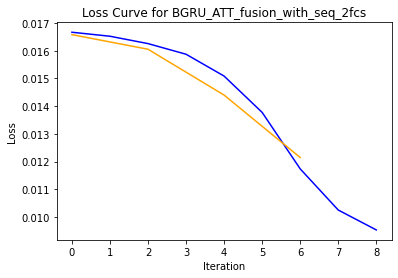

In [ ]:
import pandas as pd
seq_len = 9
batch_size = 64

train_dataset = AttentionPredictionDataset("training",  frames_per_seq=seq_len, device=device)
valid_dataset = AttentionPredictionDataset("validation", frames_per_seq=seq_len, device=device)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

va_padding = 1
VA=True

# input_dim = (70 + va_padding)*3

hidden_dim = 128
layer_dim = 5
learning_rate = 0.0001
model_name = "BGRU_ATT_fusion_with_seq_2fcs"
model_type = "GRU"
num_epochs = 100
valid_freq = 2
patience = 5
bidir=True

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

train_fusion_with_att(model_name, train_loader, valid_loader, "CCC", device=device, learning_rate=learning_rate, valid_freq=valid_freq,
                      patience_threshold=patience)

In [ ]:
eval_fusion_att(seq_len=9, network_name="BGRU_ATT_fusion_with_seq_2fcs_att")

In [ ]:
import pandas as pd
seq_len = 9
batch_size = 64

train_dataset = AttentionPredictionDataset("training",  frames_per_seq=seq_len, device=device)
valid_dataset = AttentionPredictionDataset("validation", frames_per_seq=seq_len, device=device)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

va_padding = 1
VA=True

# input_dim = (70 + va_padding)*3

hidden_dim = 128
layer_dim = 5
learning_rate = 0.0001
model_name = "BGRU_ATT_fusion_with_seq_2fcs"
model_type = "GRU"
num_epochs = 100
valid_freq = 2
patience = 5
bidir=True

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

train_fusion_with_att(model_name, train_loader, valid_loader, "CCC", device=device, learning_rate=learning_rate, valid_freq=valid_freq,
                      patience_threshold=patience)

faces: torch.Size([833, 9, 1, 70, 3])
poses: torch.Size([833, 9, 1, 67, 3])
voices: 835
faces: torch.Size([238, 9, 1, 70, 3])
poses: torch.Size([238, 9, 1, 67, 3])
voices: 238
cuda


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 0, Iteration: 0, training loss = 1.0014
Epoch: 0, Iteration: 20, training loss = 0.9745
Epoch: 1, Iteration: 0, training loss = 0.9753
Epoch: 1, Iteration: 20, training loss = 0.9728
Epoch: 2, Iteration: 0, training loss = 0.9684
Epoch: 2, Iteration: 20, training loss = 0.9468
Epoch: 3, Iteration: 0, training loss = 0.8851
Epoch: 3, Iteration: 20, training loss = 0.9142
Epoch: 4, Iteration: 0, training loss = 0.8641
Epoch: 4, Iteration: 20, training loss = 0.8728
Epoch: 5, Iteration: 0, training loss = 0.8969
Epoch: 5, Iteration: 20, training loss = 0.7939
Epoch: 6, Iteration: 0, training loss = 0.7433
Epoch: 6, Iteration: 20, training loss = 0.8523
Epoch: 7, Iteration: 0, training loss = 0.6708
Epoch: 7, Iteration: 20, training loss = 0.7209
Epoch: 8, Iteration: 0, training loss = 0.6535
Epoch: 8, Iteration: 20, training loss = 0.7336
Epoch: 9, Iteration: 0, training loss = 0.6574
Epoch: 9, Iteration: 20, training loss = 0.4678


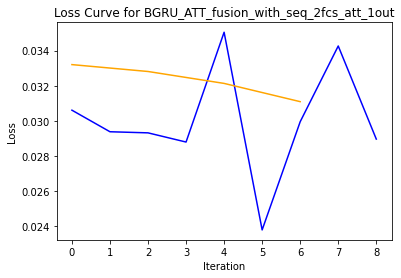

In [ ]:
import pandas as pd
seq_len = 9
batch_size = 32

train_dataset = AttentionPredictionDataset("training",  frames_per_seq=seq_len, device=device)
valid_dataset = AttentionPredictionDataset("validation", frames_per_seq=seq_len, device=device)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

va_padding = 1
VA=True

# input_dim = (70 + va_padding)*3

hidden_dim = 128
layer_dim = 5
learning_rate = 0.0001
model_name = "BGRU_ATT_fusion_with_seq_2fcs_att_1out_hyper"
model_type = "GRU"
num_epochs = 100
valid_freq = 2
patience = 5
bidir=True

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

train_fusion_with_att(model_name, train_loader, valid_loader, "CCC", device=device, learning_rate=learning_rate, valid_freq=valid_freq,
                      patience_threshold=patience, out_seq = 1)


In [ ]:
execfile(f'{content_path}/API/helpers.py')
execfile(f'{content_path}/API/RNN.py')
execfile(f'{content_path}/API/fusion.py')

faces: torch.Size([120, 9, 1, 70, 3])
poses: torch.Size([120, 9, 1, 67, 3])
voices: 115
torch.Size([115])
torch.Size([115])

Weigthed score for the current model after smoothening: 0.5599530935287476
CCC score for BGRU_ATT_fusion_with_seq_2fcs_att_1out on test set: 0.36521807312965393

MSE error for BGRU_ATT_fusion_with_seq_2fcs_att_1out on test set: 59.250205993652344
weighted MSE error for BGRU_ATT_fusion_with_seq_2fcs_att_1out on test set: 82.13380432128906


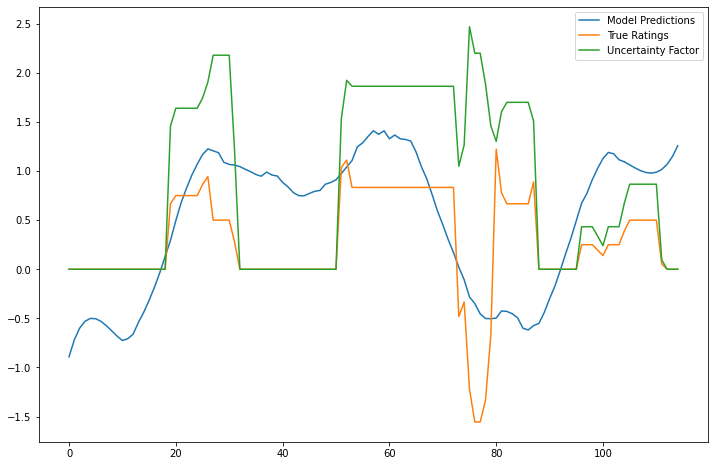

In [ ]:
eval_fusion_att(seq_len=9, out_len=1, network_name="BGRU_ATT_fusion_with_seq_2fcs_att_1out")

#### Evals

# Tests and Graphs - used in old structure

In [ ]:
def record_performance(name, score, score_w):
  if not os.path.exists(f'{content_path}/models/model_performance.csv'):
    f = open(f'{content_path}/models/model_performance.csv', 'w')     
    row = ('model_name', 'performance on test set - score', 'performance on test set weighted score')
  else:
    f = open(f'{content_path}/models/model_performance.csv', '+a')
    row = (name, score)
   
  writer = csv.writer(f)
  writer.writerow(row)
  f.close()  
  
def gen_voice_graph_and_score(model_name, model_type = None, VA=False, show_graph=True):
  # audio processing
  audios = []
  path = f'{content_path}/dataset/aud_3s/test/'
  ratings = np.load(f"{content_path}/opinions/audio_ratings_labels_test.npy")
  ratings_dev = np.load(f"{content_path}/opinions/audio_ratings_devs_labels_test.npy")
  # ratings = pd.read_csv(f'{content_path}/dataset/aud_3s/test/test_labels_stddev.csv')
      
  print(ratings.shape)
  print(len(os.listdir(path)))

  score = 0
  score_w = 0

  idx=0
  for j, filename in enumerate(np.array(os.listdir(path))[:-1]):
    if(filename[-3:] == "wav"):

      if model_type is not None:
        if 'LSTM' in model_type or 'GRU' in model_type:
          voice_model = torch.load(f"{content_path}/models/{model_name}")
          clip = read(f'{content_path}/dataset/aud_3s/test/{filename}')
          features = librosa.feature.mfcc(y=clip[1].astype(float), sr=clip[0], hop_length=512, n_fft=2048).transpose().astype(np.float32)
          
          if VA:
            va, l = aT.file_regression(f'{path}/{filename}', f"{content_path}/models/va_voice_svm", "svm")
            p1d = (0, features[1] - len(va))
            va = F.pad(torch.Tensor(va).view(1,2), (0, 18), "constant", 0)
            features = torch.cat((va.to(device), torch.tensor(features).to(device)), dim=0)

          seq_dim, input_dim = features.shape
          
          audio = Variable(Tensor(features).view(-1, seq_dim, input_dim).to(device))    
          acc = voice_model(audio).squeeze(-1)
          acc = acc.item()

        elif model_type == 'svm':  
          v, l = aT.file_regression(f'{content_path}/dataset/aud_3s/test/{filename}', f"{content_path}/models/voice_svm", model_type)
          acc = v[0]

        elif model_type == 'randomforest':
          v, l = aT.file_regression(f'{content_path}/dataset/aud_3s/test/{filename}', f"{content_path}/models/voice_rdmforrest", model_type)
          acc = v[0]

        else:
          acc = 0
          print(model_name)   

        score_w += (ratings[j-2] - acc)**2 *(1/(1+ratings_dev[j-2]))
        score += (ratings[j-2] - acc)**2
        # score_w += (ratings[idx,1] - acc)**2 *(1/(1+ratings_dev[idx,2]))
        # score += (ratings[idx,1] - acc)**2
        idx+=1
        audios.append(acc)

  if show_graph:
    plt.figure(figsize=(12, 8))
    print('no of ratings', len(ratings))
    print('no of video clips', len(audios))
    plt.plot(range(len(audios)), audios, label = 'model')
    plt.plot(range(len(ratings)), ratings, label='true ratings')
    plt.plot(range(len(ratings_dev)), ratings_dev, label='dev')

    print(f'error for {model_name} on test set: {score.item()}')
    print(f'weighted error for {model_name} on test set: {score_w.item()}')
    plt.legend()
    plt.show()

  record_performance(model_name, score.item() ,score_w.item())
  return (score.item(), score_w.item()), audios  

def gen_face_graph_and_score(model_name, model_type = None, VA=True, frames_per_seq = 12, show_graph=True):
  return gen_feat_graph_and_score(model_name, "face", model_type, VA, frames_per_seq, show_graph)

def gen_pose_graph_and_score(model_name, model_type = None, VA=False, frames_per_seq = 12, show_graph=True):
  return gen_feat_graph_and_score(model_name, "pose", model_type, VA, frames_per_seq, show_graph)

def gen_feat_graph_and_score(model_name, feat, model_type = None, VA=True, frames_per_seq:int = 12, show_graph=True):

  test_dataset_feat = torch.load(f"{content_path}/dataset/{feat}_test_unfiltered")
  test_genders = torch.load(f"{content_path}/dataset/genders_test_slice")

  test_dataset_feat = test_dataset_feat.to(device)
  test_genders = test_genders.to(device)

  test_feat_ratings = torch.tensor(np.load(f"{content_path}/opinions/{feat}_ratings_labels_test_unfiltered.npy"))
  stds = torch.tensor(np.load(f"{content_path}/opinions/{feat}_ratings_devs_test_unfiltered.npy"))

  print("here", frames_per_seq)
  if VA:
    test_va = torch.load(f"{content_path}/opinions/{feat}_va_best_test_slice_va")

    if  model_type != 'regression':
      test_va = torch.cat(test_va, 0)
      test_va = F.pad(test_va, (0, 1 ,0,(frames_per_seq- test_va.shape[0] % frames_per_seq)),  "constant", 0. )
      test_va = test_va.reshape(test_va.shape[0]//frames_per_seq, frames_per_seq, 1,1, 3)
      test_va=test_va.to(device)
  
  if model_type != 'regression':

    test_feat_ratings = F.pad(test_feat_ratings, (0,(frames_per_seq- test_feat_ratings.shape[0] % frames_per_seq)),  "constant", 0. )
    test_feat_ratings = test_feat_ratings.reshape(test_feat_ratings.shape[0]//frames_per_seq, frames_per_seq)
    # test_feat_ratings= torch.mean(test_feat_ratings, dim=1)
    test_feat_ratings.to(device)

    stds = F.pad(stds, (0,(frames_per_seq- stds.shape[0] % frames_per_seq)),  "constant", 0. )
    stds = stds.reshape(stds.shape[0]//frames_per_seq, frames_per_seq)
    # stds = torch.mean(stds, dim=1 )
    stds.to(device)

    test_dataset_feat = F.pad(test_dataset_feat, (0, 0, 0, 0, 0, 0, 0, (frames_per_seq- test_dataset_feat.shape[0] % frames_per_seq)),  "constant", 0. )
    test_dataset_feat = test_dataset_feat.reshape(test_dataset_feat.shape[0]//frames_per_seq, frames_per_seq, test_dataset_feat.shape[1], test_dataset_feat.shape[2], test_dataset_feat.shape[3])
    test_dataset_feat.to(device)

  model_feat = torch.load(f"{content_path}/models/{model_name}")
  model_feat = model_feat.to(device)

  out_feat = [] 

  score = 0
  score_w = 0
  count = 0

  mask =[]

  for f in range(test_dataset_feat.shape[0]):
    model_feat.eval()
    if not torch.all(test_dataset_feat[f] == 0) and torch.any(test_dataset_feat[f] > -99.0):
      with torch.no_grad():
        if model_type == 'regression':
          input = torch.cat((test_genders[f].float(), test_dataset_feat[f].to(device)), 1).flatten(start_dim=1)
          input = input.squeeze(-1)
          input = Variable(input.to(device))

        else: #LSTM or GRU
          if 'align' in model_name: 
            input = align_crop_resize_per_seq(feat, data=test_dataset_feat[f])
          #   face_frame= align_crop_resize_per_frame(data_feature=test_dataset_feat[f],feature=feat)
          #   test_dataset_feat[f] = F.pad(face_frame, (0,1), "constant", 0.)  
          if VA:
            input = torch.cat((test_va[f], input), 2)
          
          # print(input.shape)
          input = input.flatten(start_dim=1)
          seq_dim = input.shape[0]
          # input_dim = input.shape[-1]
          # seq_dim = test_dataset_feat[0].shape[0]
          input_dim = len(input[0].flatten())
          # print(input_dim)
          # print(seq_dim)
          input = Variable(input.view(-1, seq_dim, input_dim).to(device))

        out = model_feat(input.float())
        out_feat.append(out.cpu())
        score += (out - test_feat_ratings[f].cuda())**2
        score_w += ((out - test_feat_ratings[f].cuda())**2 * (1/(1 + stds[f].cuda())))

        count +=1
        mask.append(True)

    else:
      out_feat.append(-5)
      stds[f] = 0
      test_feat_ratings[f] = -5
      mask.append(False)

  if show_graph:
    plt.figure(figsize=(12, 8))
    stds = np.array(stds)
    out_feat = np.array(torch.cat(out_feat))
    test_feat_ratings = np.array(test_feat_ratings)
    
    # print('no of ratings', len(test_feat_ratings[mask]))
    # print('no of frames', len(out_feat[mask]))

    # plt.plot(range(len(out_feat[mask])), out_feat[mask], label = 'model predictions')
    # plt.plot(range(len(test_feat_ratings[mask])), test_feat_ratings[mask], label='true ratings')
    # plt.plot(range(len(stds[mask])), stds[mask], label='uncertainty level')

    print('no of ratings', len(test_feat_ratings[mask]))
    print('no of frames', len(out_feat[mask]))

    print(out_feat.flatten().shape)
    out_feat = (savgol_filter(np.array(out_feat.flatten()), 51, 3))
    # outs = out_feat.to(device)

    plt.plot(range(len(out_feat.flatten())), out_feat.flatten(), label = 'model predictions')
    plt.plot(range(len(test_feat_ratings.flatten())), test_feat_ratings.flatten(), label='true ratings')
    plt.plot(range(len(stds.flatten())), stds.flatten(), label='uncertainty level')

    print(f'error for {model_name} on test set: {score}')
    print(f'weighted error for {model_name} on test set: {score_w}')
    print('-----------------')
    plt.legend()
    plt.show()    

  record_performance(model_name, score, score_w)
  return (score, score_w), out_feat


In [ ]:
def test_overall_performance(face_model, pose_model, voice_model, show_individual_graphs=False):

  face_model, VA_face = face_model 
  model_name, model_type, VA_voice = voice_model
  audio_scores, audio_ratings = gen_voice_graph_and_score(model_name, model_type, VA=VA_voice, show_graph=show_individual_graphs)
  face_scores, face_ratings = gen_face_graph_and_score(face_model, VA=VA_face, show_graph=show_individual_graphs)
  pose_scores, pose_ratings = gen_pose_graph_and_score(pose_model, show_graph=show_individual_graphs)

  test_overall_ratings = np.load(f"{content_path}/opinions/overall_ratings_labels_test_slice.npy")
  test_overall_ratings_dev = np.load(f"{content_path}/opinions/overall_ratings_devs_test_slice.npy")

  audio_padded = np.repeat(audio_ratings, 3*6) 
  pad = np.full((len(face_ratings) - len(audio_ratings)), 0.0)
  audio_ratings = np.concatenate([pad, audio_ratings])

  outs=[]
  for f in range(len(face_ratings)):
    out_face = face_ratings[f]
    out_pose = pose_ratings[f]
    out_voice = audio_ratings[f]

    if out_face>-5 and out_pose > -5:

      # this formula obtained 0.71
      # outs.append((2*out_face + out_pose + audio_models)/5 - 0.5 )
      # this obtains 0.65
      outs.append((2*out_face + out_pose + out_voice)/4 - 1)
    elif out_face > -5:
      outs.append((2 * out_face + out_voice)/4)
    elif out_pose > -5:
      outs.append((out_pose + out_voice)/4)
    else:
      outs.append(0)  

  outs = np.array(outs)

  print()
  print(f'Test sequence consists of {len(test_overall_ratings)/6} seconds')

  score = 1.0 - (np.sum(np.abs(np.array(outs) - test_overall_ratings) * (1/(1+test_overall_ratings_dev)))) / len(outs)
  print('-------------')
  print(f"Face model {face_model} with score: {face_scores[0]} and weighted score: {face_scores[1]}")
  print(f"Pose model {pose_model} with score: {pose_scores[0]} and weighted score: {pose_scores[1]}")
  print(f"Voice model {voice_model[0]} with score: {audio_scores[0]} and weighted score: {audio_scores[1]}")
  
  print('-------------')
  print(f"Score for the overall model: {score}")

  plt.figure(figsize=(13, 13))
  plt.title(f'Network prediction vs measured results ')

  plt.plot(range(len(outs)), outs, color='blue', alpha=0.8, linewidth=1.0, label='network prediction')
  plt.plot(range(len(test_overall_ratings_dev)), test_overall_ratings_dev, color='red', linewidth=2.0, label = 'uncertainty factor')
  plt.plot(range(len(test_overall_ratings)), test_overall_ratings, color='orange', linewidth=3.0, label= 'real engagement rating')

  plt.legend()
  plt.show()  

# Hyper Parameter Tuning

In [ ]:
#parameters to tune
lrs = [0.0005, 0.0001, 0.00008, 0.00005, 0.00001]
seq_lens = [12, 9, 6]
batch_sizes = [32, 64]
hidden_dims = [2, 5, 8, 10, 15, 20]
layer_dims = [1,2,3]
valid_freq = [1, 5, 10]

best_score = 0
best_model = ""
params = []

count = 0

valid_freq = 5
patience = 5
bidir=False

va_padding = 1
VA=False

for seq_len in seq_lens:
  for batch_size in batch_sizes:
    for learning_rate in lrs:
      for hidden_dim in hidden_dims:
        for layer_dim in layer_dims:
          count += 1

          train_dataset = VisualFeatureDatasetLSTM("pose", "training_unfiltered", False, True, True, seq_len, device)
          valid_dataset = VisualFeatureDatasetLSTM("pose", "validation_unfiltered", False, True, True, seq_len, device)

          train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                    batch_size=batch_size,
                                                    shuffle=True)

          valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                    batch_size=batch_size,
                                                    shuffle=False)

          input_dim = len(train_dataset[0][0][0].flatten())

          output_dim = 1
          model_name = f"LSTM_body_aligned_seq_tunned{count}"
          model_type = "LSTM"
          num_epochs = 1

          device = "cuda" if torch.cuda.is_available() else "cpu"
          print(device)

          model = RNNModel(model_type, input_dim, hidden_dim, layer_dim, output_dim, device, bidir=bidir)

          optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

          train_for_feat_datasetLSTM(model, 
                                (model_name, "pose", model_type), 
                                train_loader, 
                                valid_loader, 
                                criterion='weighted_MSE', 
                                optimiser=optimiser, 
                                device=device, 
                                num_epochs=num_epochs, 
                                valid_freq=valid_freq,
                                VA=(VA, va_padding),
                                patience_threshold=patience)

          scores, _ = gen_feat_graph_and_score(model_name, "pose", model_type = model_type, VA=VA, frames_per_seq=seq_len, show_graph=False)
          if scores[1] > best_score:
            best_score = scores[1]
            best_model = model_name
            params = [seq_len, batch_size, learning_rate, layer_dim]

print('#############################')
print('Best model is: ', best_model, 'with score', best_score)
print('Parameters used: ', params)



In [ ]:
VA_available = False
batch_size = 32

path_labels = f"{content_path}/dataset/audio/opinions_audio.csv"
path_audio = f"{content_path}/dataset/audio/"

train_dataset = VocalSnippetsDatasetfromDF(path_labels, path_audio, "training", 
                                           transform=True, VA=VA_available)
valid_dataset = VocalSnippetsDatasetfromDF(path_labels, path_audio, "validation", 
                                           transform=True, VA=VA_available)
test_dataset = VocalSnippetsDatasetfromDF(path_labels, path_audio, "test", 
                                          transform=True, VA=VA_available)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

output_dim = 1
hidden_dim = 100
layer_dim = 2
learning_rate = 0.0003
model_name = "GRU_audio_more_features"
model_type = "GRU_Att"
num_epochs = 50
valid_freq = 2
patience = 3
seq_dim, input_dim = train_dataset[0][0].shape
device = "cuda" if torch.cuda.is_available() else "cpu"
bidir=True

model = GRUModel_Att(input_dim, hidden_dim, layer_dim, output_dim, device, dropout_prob=0.2, bidir=bidir)
      
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_for_audio_dataset(model, model_name, train_loader, valid_loader,
                        'weighted_MSE', optimiser, device, num_epochs,
                        valid_freq, VA=False, patience_threshold=patience)

eval_single_cue(model_name, 'voice', test_dataset, smoothen=False)
eval_single_cue_with_score_classes(model_name, 'voice', test_dataset, smoothen=True)

# Final Graphs


load from dataframe - raw frames
torch.Size([1072])
torch.Size([1072])
torch.Size([1072, 1, 70, 3])
torch.Size([120, 9, 1, 70, 3])

here - number of sequences for face
torch.Size([120, 9, 1, 70, 3])
torch.Size([120])

Weigthed score for BGRU_Att_face_align_seq_of_9 for face after smoothening: 0.22260829621704725
CCC score for BGRU_Att_face_align_seq_of_9 for face on test set: 0.28044681479584704


MSE error for BGRU_Att_face_align_seq_of_9 on test set: 174.899169921875
weighted MSE error for BGRU_Att_face_align_seq_of_9 on test set: 251.52789555006444
120
120


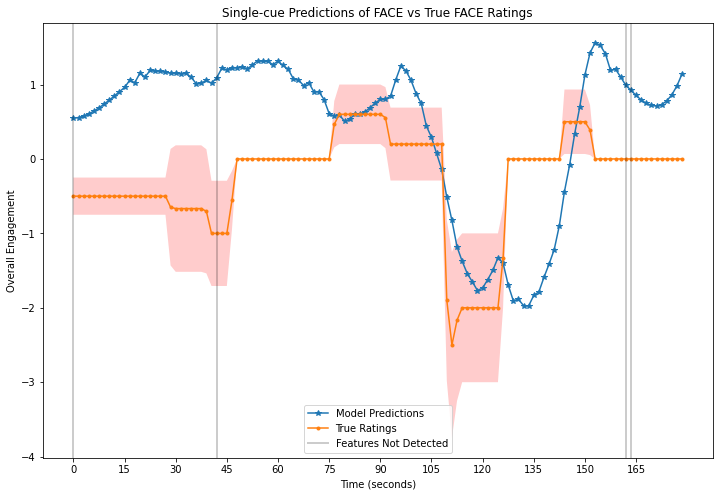


torch.Size([8])
torch.Size([8])
CCC score for BGRU_Att_face_align_seq_of_9 for face on test set: 0


MSE error for BGRU_Att_face_align_seq_of_9 on test set: 11.25
weighted MSE error for BGRU_Att_face_align_seq_of_9 on test set: 0
8
120


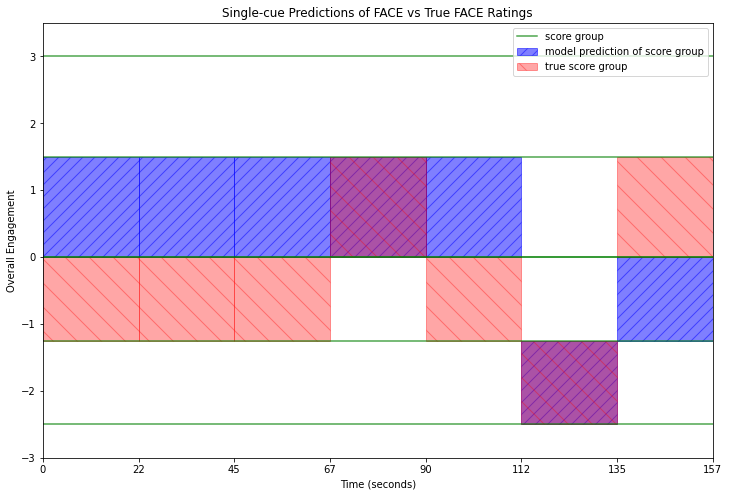

In [ ]:
reg_outs = torch.load("face_regression_outputs")

execfile(f'{content_path}/API/helpers.py')
execfile(f'{content_path}/API/RNN.py')

# Attention
batch_size = 32

seq_len = 9
va_padding = 0
VA=False
model_name=  "BGRU_Att_face_align_seq_of_9"

path_labels=f'{content_path}/video_features/opinions_visual.csv'
path_frames=f'{content_path}/video_features/video_b1_'

test_dataset = VisualFeatureDatasetLSTMfromDF("face", "test", path_frames, path_labels, 
                                              VA=False, augment=False, transform=True , 
                                              align=True, frames_per_seq=seq_len, device=device)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

eval_single_cue(model_name, 'face', test_dataset, smoothen=True)
eval_single_cue_with_score_classes(model_name, 'face', test_dataset, smoothen=True)


load from dataframe - raw frames
torch.Size([1072])
torch.Size([1072])
torch.Size([1072, 1, 70, 3])
torch.Size([120, 9, 1, 70, 3])

here - number of sequences for face
torch.Size([120, 9, 1, 70, 3])
torch.Size([120])

Weigthed score for BGRU_Att_face_align_seq_of_9 for face after smoothening: 0.2715376718061019
CCC score for BGRU_Att_face_align_seq_of_9 for face on test set: 0.1153308977518557


MSE error for BGRU_Att_face_align_seq_of_9 on test set: 380.92694091796875
weighted MSE error for BGRU_Att_face_align_seq_of_9 on test set: 347.93900059144437
120
120


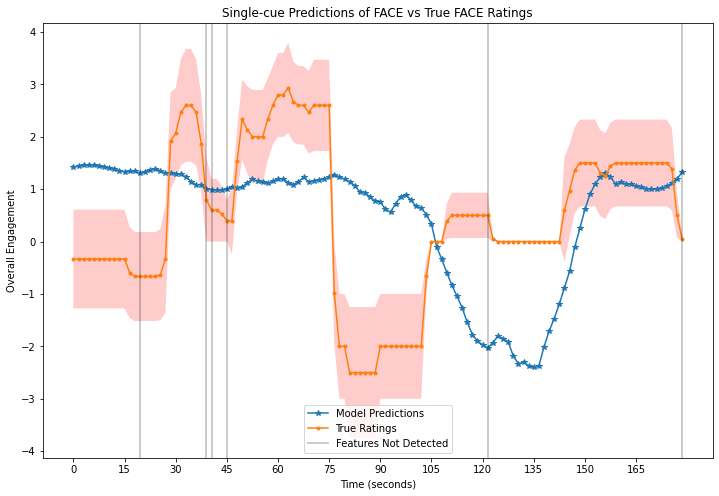


torch.Size([8])
torch.Size([8])
CCC score for BGRU_Att_face_align_seq_of_9 for face on test set: 0


MSE error for BGRU_Att_face_align_seq_of_9 on test set: 18.8125
weighted MSE error for BGRU_Att_face_align_seq_of_9 on test set: 0
8
120


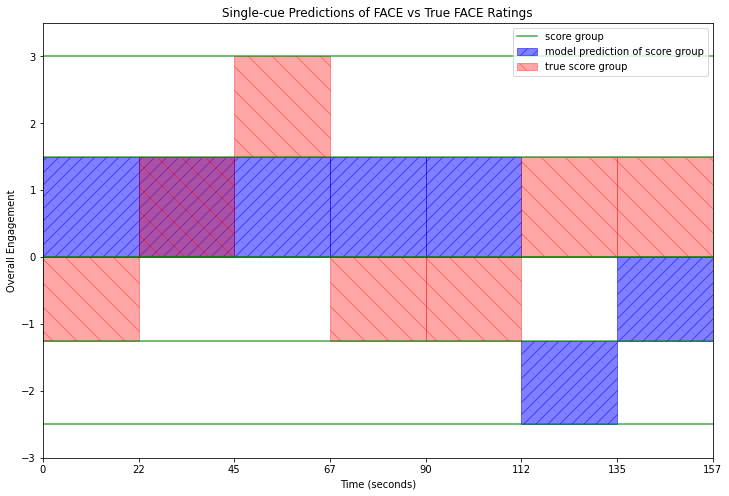

In [ ]:
reg_outs = torch.load("face_regression_outputs")

execfile(f'{content_path}/API/helpers.py')
execfile(f'{content_path}/API/RNN.py')

# Attention
batch_size = 32

seq_len = 9
va_padding = 0
VA=False
model_name=  "BGRU_Att_face_align_seq_of_9"

path_labels=f'{content_path}/video_features/opinions_visual.csv'
path_frames=f'{content_path}/video_features/video_b1_'

test_dataset = VisualFeatureDatasetLSTMfromDF("face", "test", path_frames, path_labels, 
                                              VA=False, augment=False, transform=True , 
                                              align=True, frames_per_seq=seq_len, device=device)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

eval_single_cue(model_name, 'face', test_dataset, smoothen=True)
eval_single_cue_with_score_classes(model_name, 'face', test_dataset, smoothen=True)